<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 21: Monte Carlo II - Advances with AI</h1>

<a name='section_22_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_1">L21.1 Variational Autoencoders for Monte Carlo based Event Generation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_22_1">L21.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_2">L21.2 Generating Bragg Scattering with Variational Autoencoders</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_22_2">L21.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_3">L21.3 Generating Full Bragg Scattering Details</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_22_3">L21.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_4">L21.4 Conditional VAEs Allowing for Energy Based Generation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_22_4">L21.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_5">L21.5 Bootstrapping</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_22_5">L21.5 Exercises</a></td>
    </tr>
     <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_22_6">L21.6 Bootstrapping For Neural Networks</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;">No Exercises</td>
    </tr>
</table>

In [50]:
#>>>RUN: L21.0-runcell00

!git init
!git remote add -f origin https://github.com/mitx-8s50/nb_LEARNER/
!git config core.sparseCheckout true
!echo 'data/L22' >> .git/info/sparse-checkout
!git pull origin main

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/mitx-8s50/nb_LEARNER
 * branch            main       -> FETCH_HEAD
Already up to date.


In [51]:
#>>>RUN: L21.0-runcell01

!pip install corner
!pip install torchvision
!pip install pylandau #from here: https://pypi.org/project/pylandau/
!pip install git+https://github.com/SengerM/landaupy

#from here: https://github.com/SengerM/landaupy
#https://github.com/SengerM/landaupy/blob/main/LICENSE

  Cloning https://github.com/SengerM/landaupy to /tmp/pip-req-build-farqyb7r
  Running command git clone --filter=blob:none --quiet https://github.com/SengerM/landaupy /tmp/pip-req-build-farqyb7r
  Resolved https://github.com/SengerM/landaupy to commit fad88ce49fee62fa45f1adb34f130b3069df8210
  Preparing metadata (setup.py) ... done


In [52]:
#>>>RUN: L21.0-runcell02

import imageio
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt
import warnings

import pandas as pd
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
import corner

from landaupy import landau

In [53]:
#>>>RUN: L21.0-runcell03
warnings.filterwarnings('ignore')

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_22_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.1 Variational Autoencoders for Monte Carlo based Event Generation</h2>  


| [Top](#section_22_0) | [Previous Section](#section_22_0) | [Exercises](#exercises_22_1) | [Next Section](#section_22_2) |


In [54]:
#>>>RUN: L21.1-runcell01

# Set random seed for reproducibility
torch.manual_seed(0)

data_dir = 'data/L22/dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [55]:
#>>>RUN: L21.1-runcell02

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

In [56]:
#>>>RUN: L21.1-runcell03

class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [57]:
#>>>RUN: L21.1-runcell04

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.kl      = 0

    def forward(self, x):
        z = self.encoder(x)
        kl = self.encoder.kl
        return self.decoder(z)

In [58]:
#>>>RUN: L21.1-runcell05

### Set the random seed for reproducible results
### If restarting the training, must run this part again
torch.manual_seed(0)
d = 2
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/10 	 train loss 154.905 	 val loss 83.754


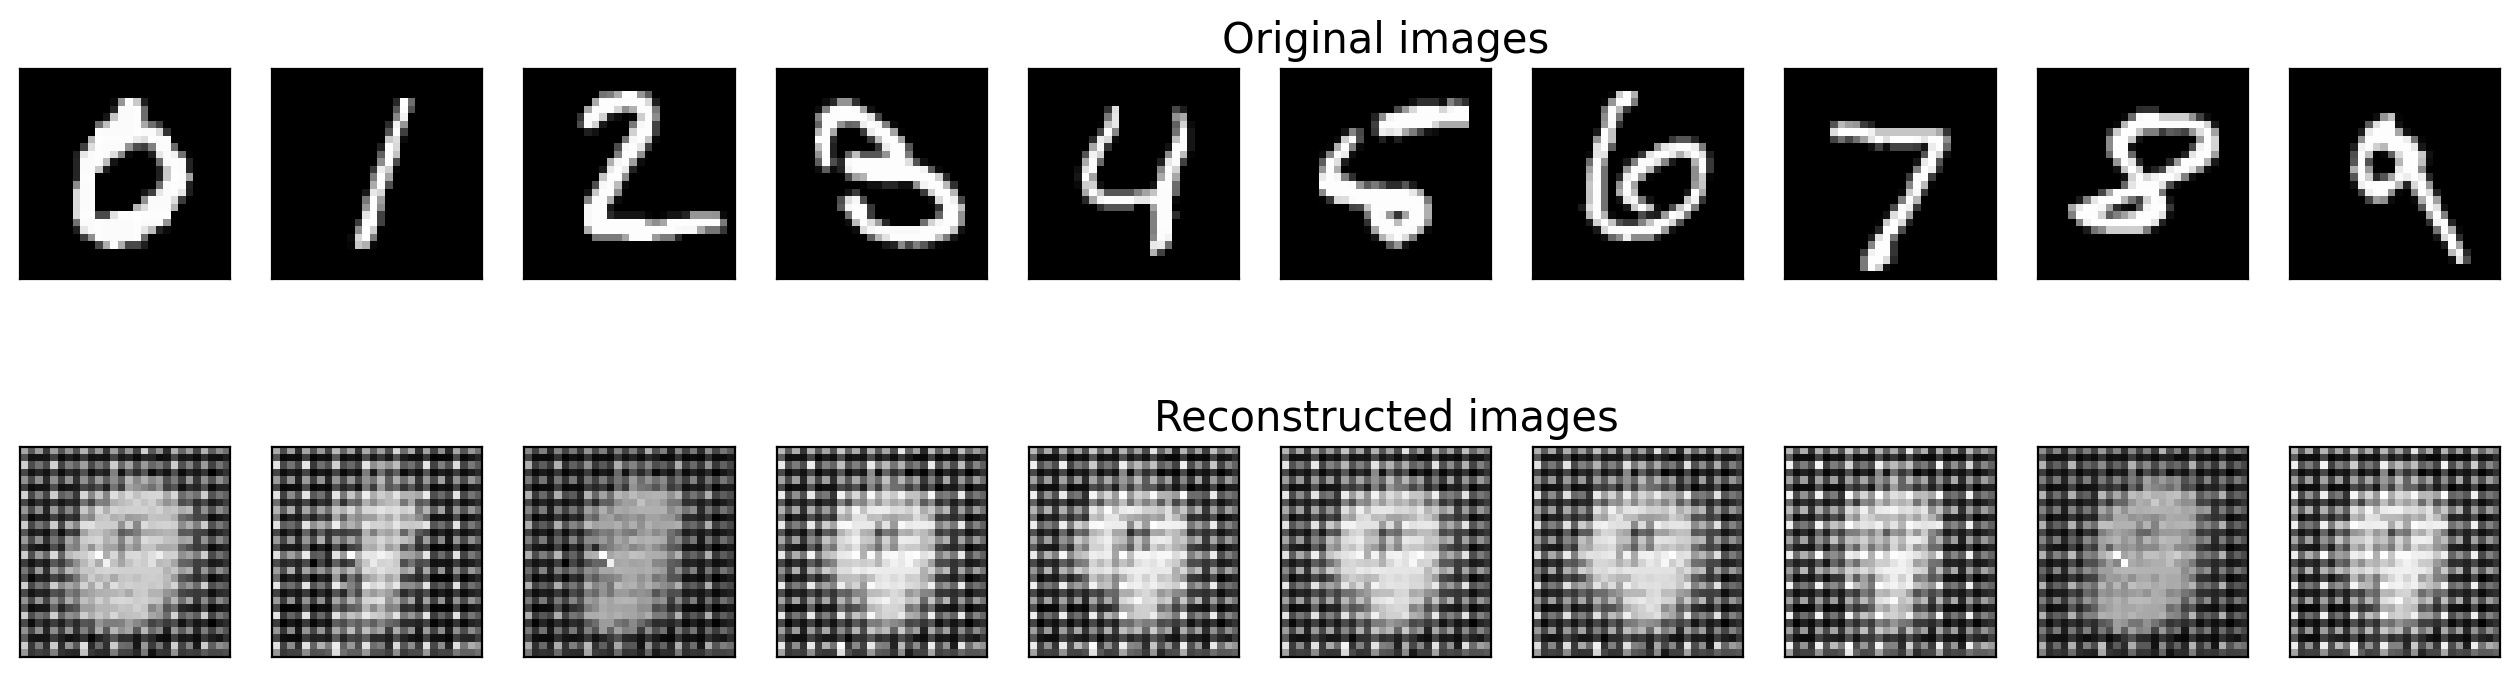


 EPOCH 2/10 	 train loss 62.882 	 val loss 48.676


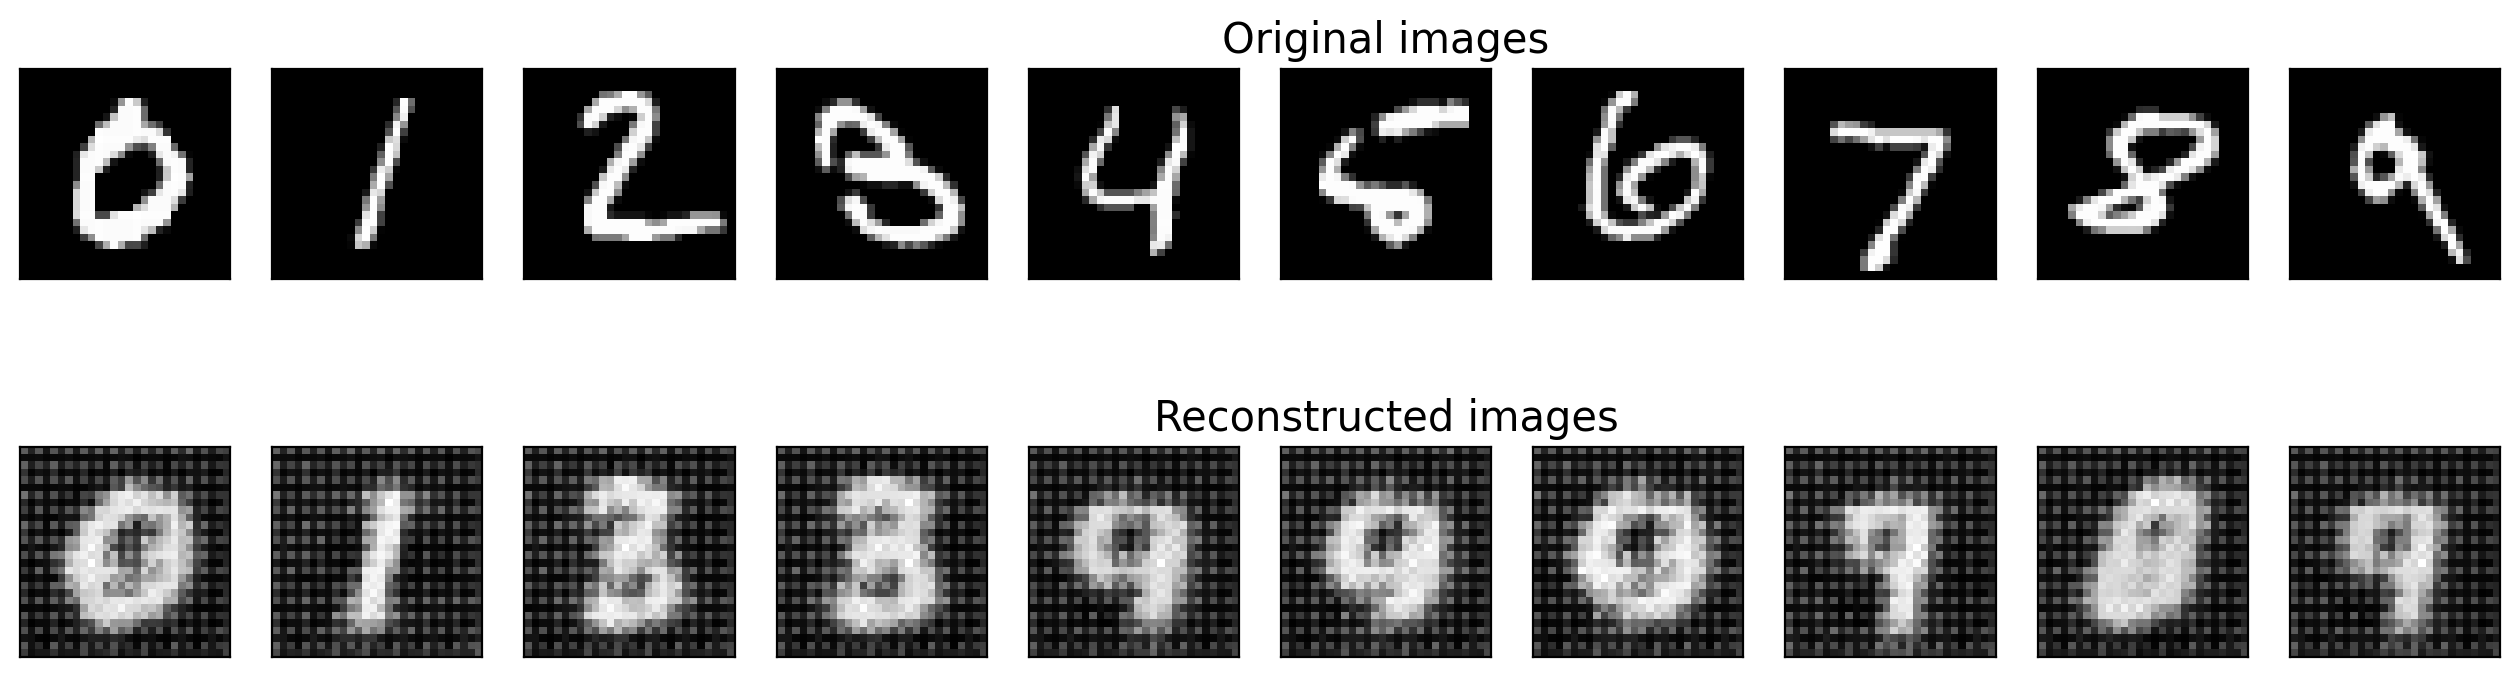


 EPOCH 3/10 	 train loss 44.037 	 val loss 40.343


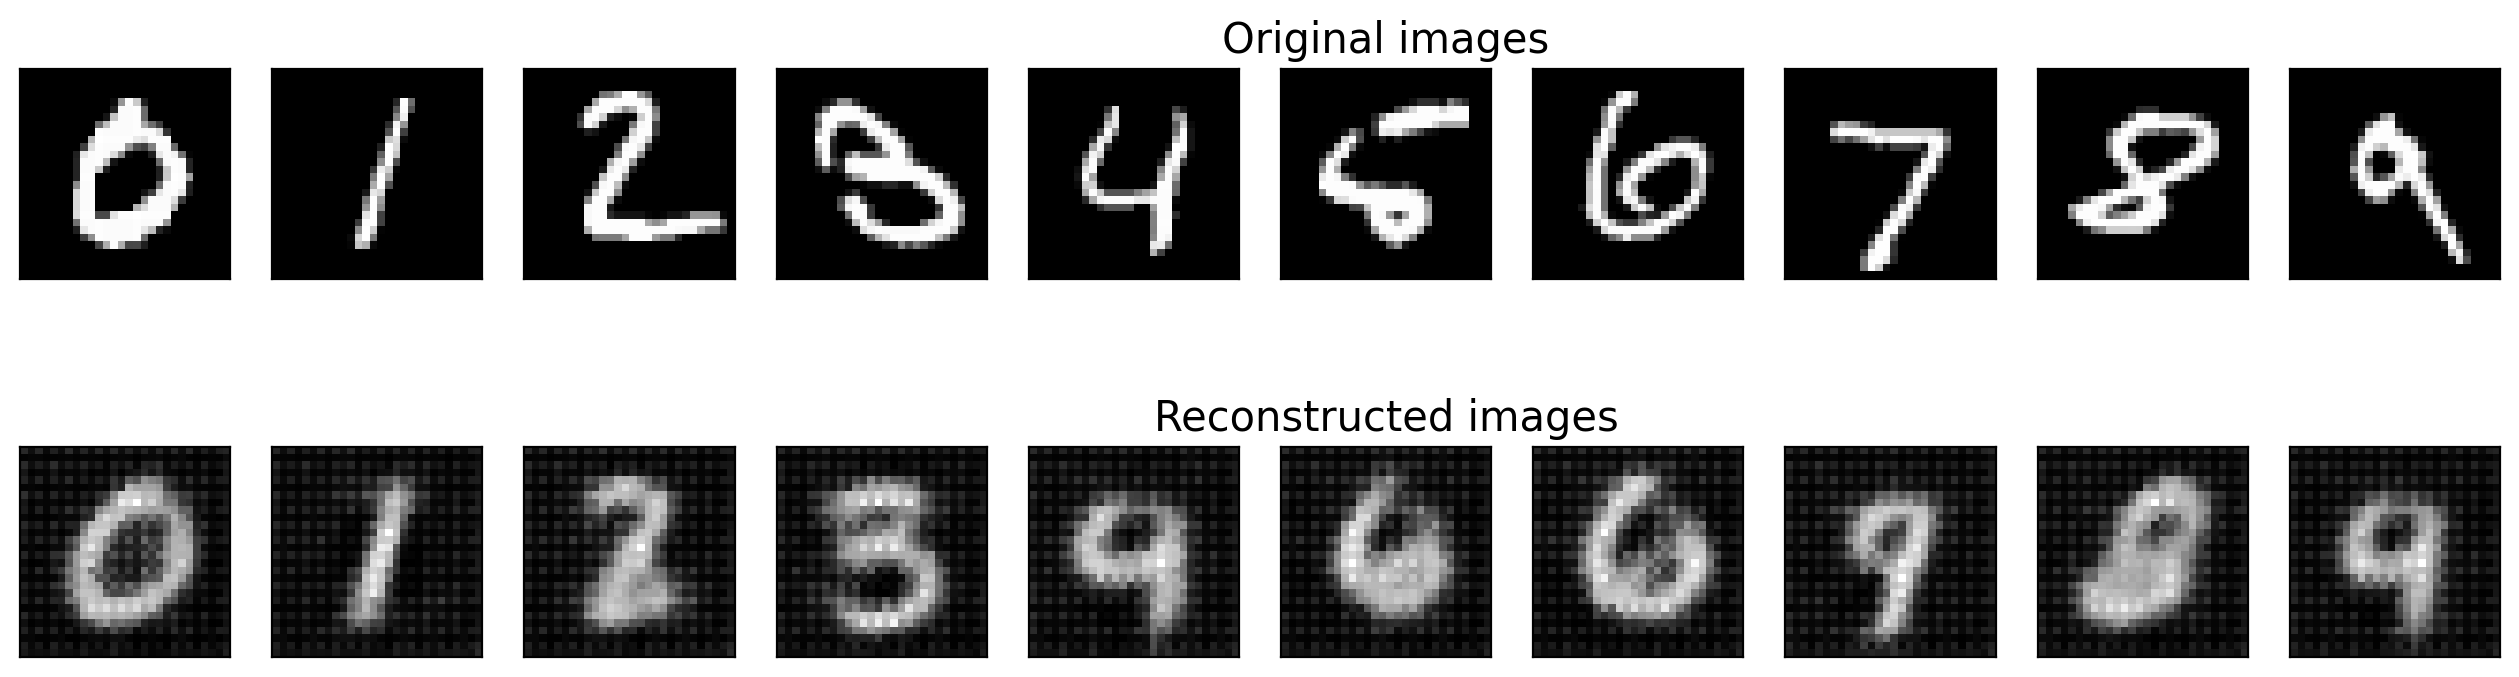


 EPOCH 4/10 	 train loss 38.437 	 val loss 37.102


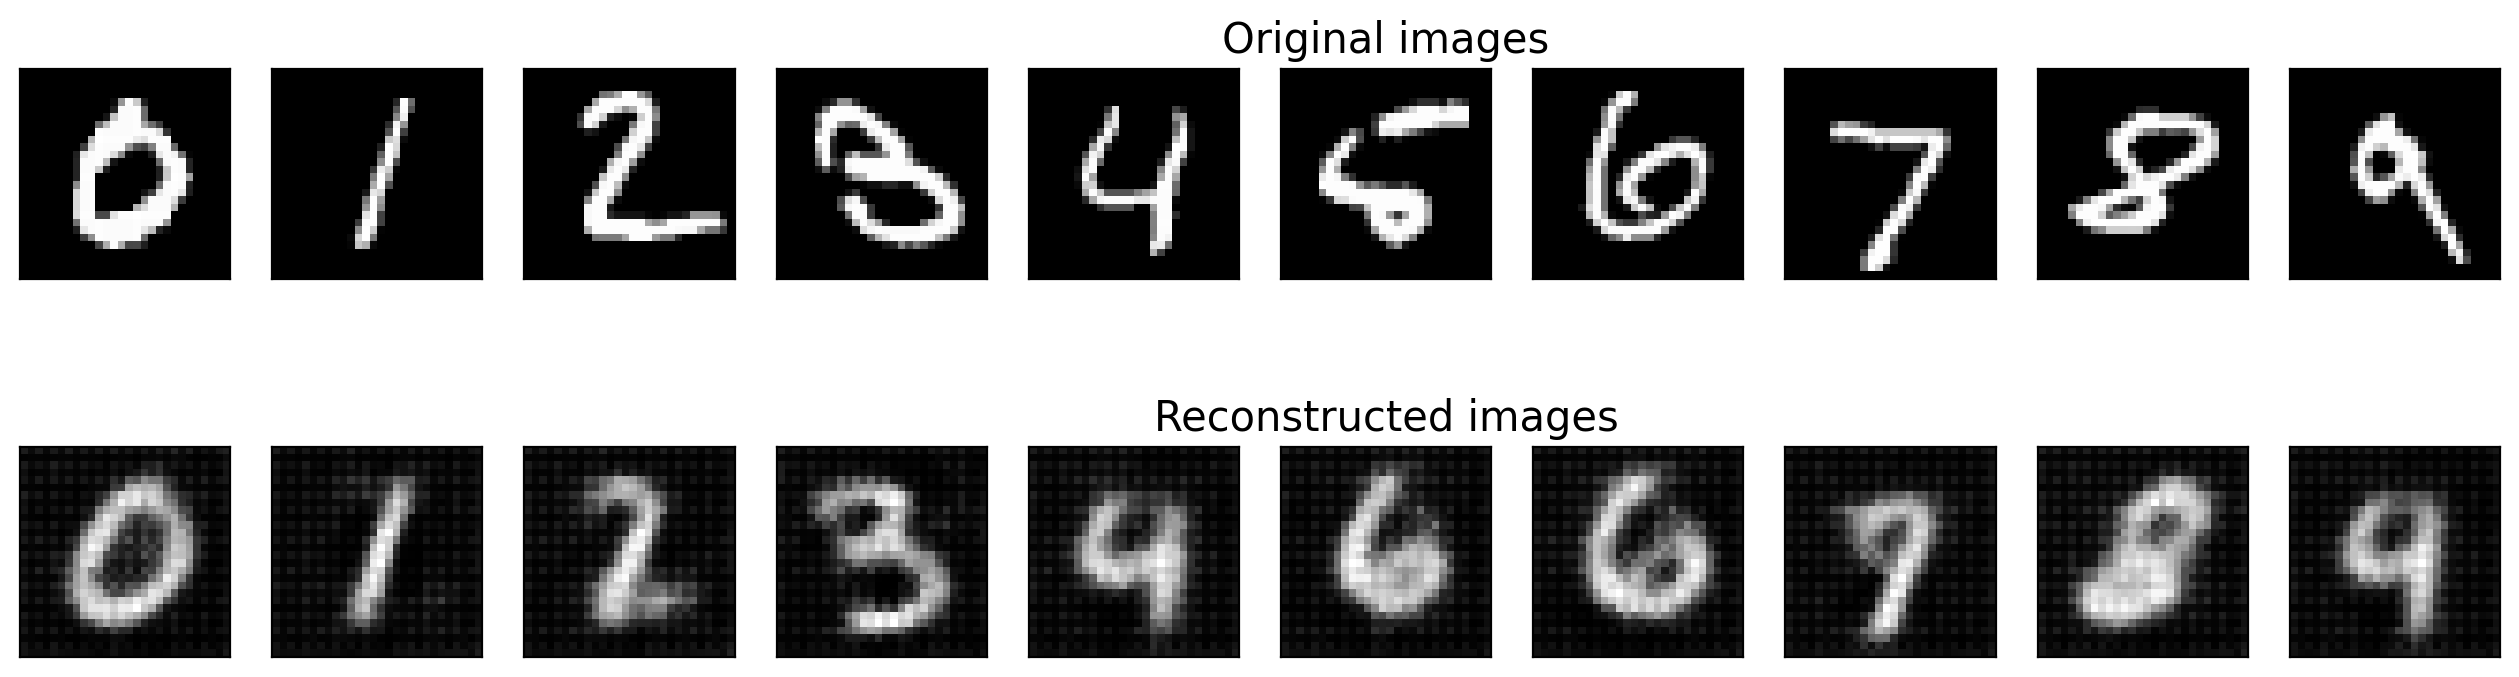


 EPOCH 5/10 	 train loss 35.990 	 val loss 35.270


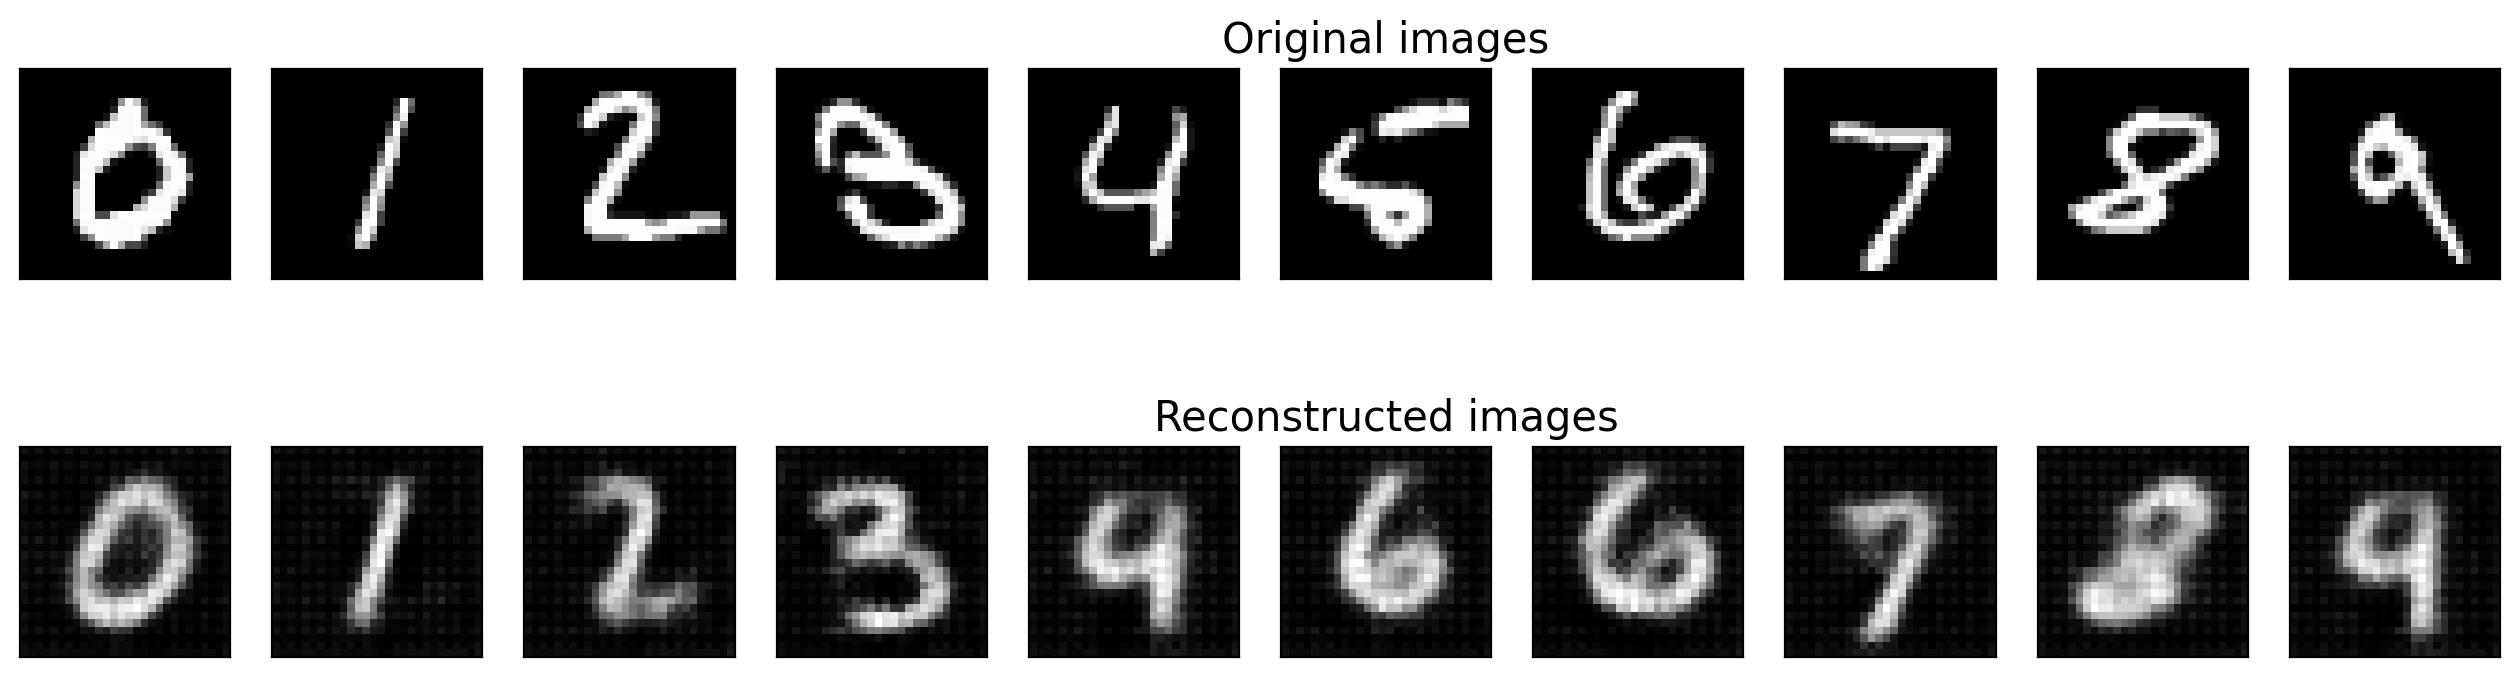


 EPOCH 6/10 	 train loss 34.569 	 val loss 34.060


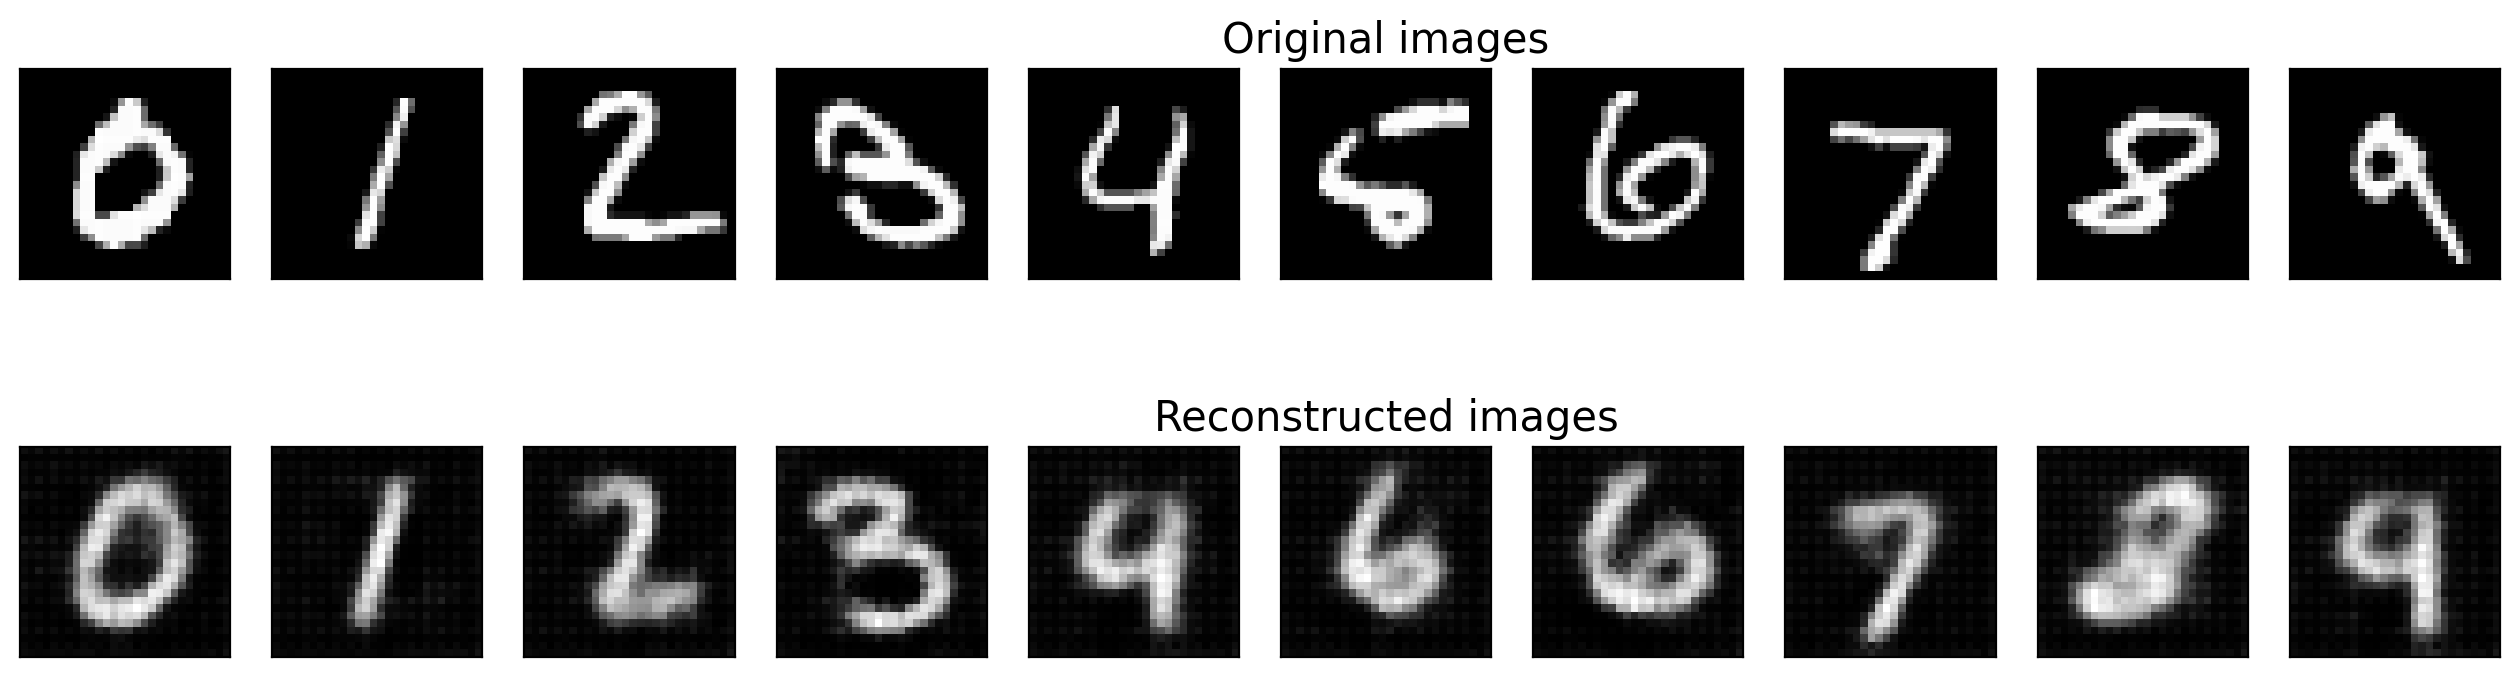


 EPOCH 7/10 	 train loss 33.639 	 val loss 33.176


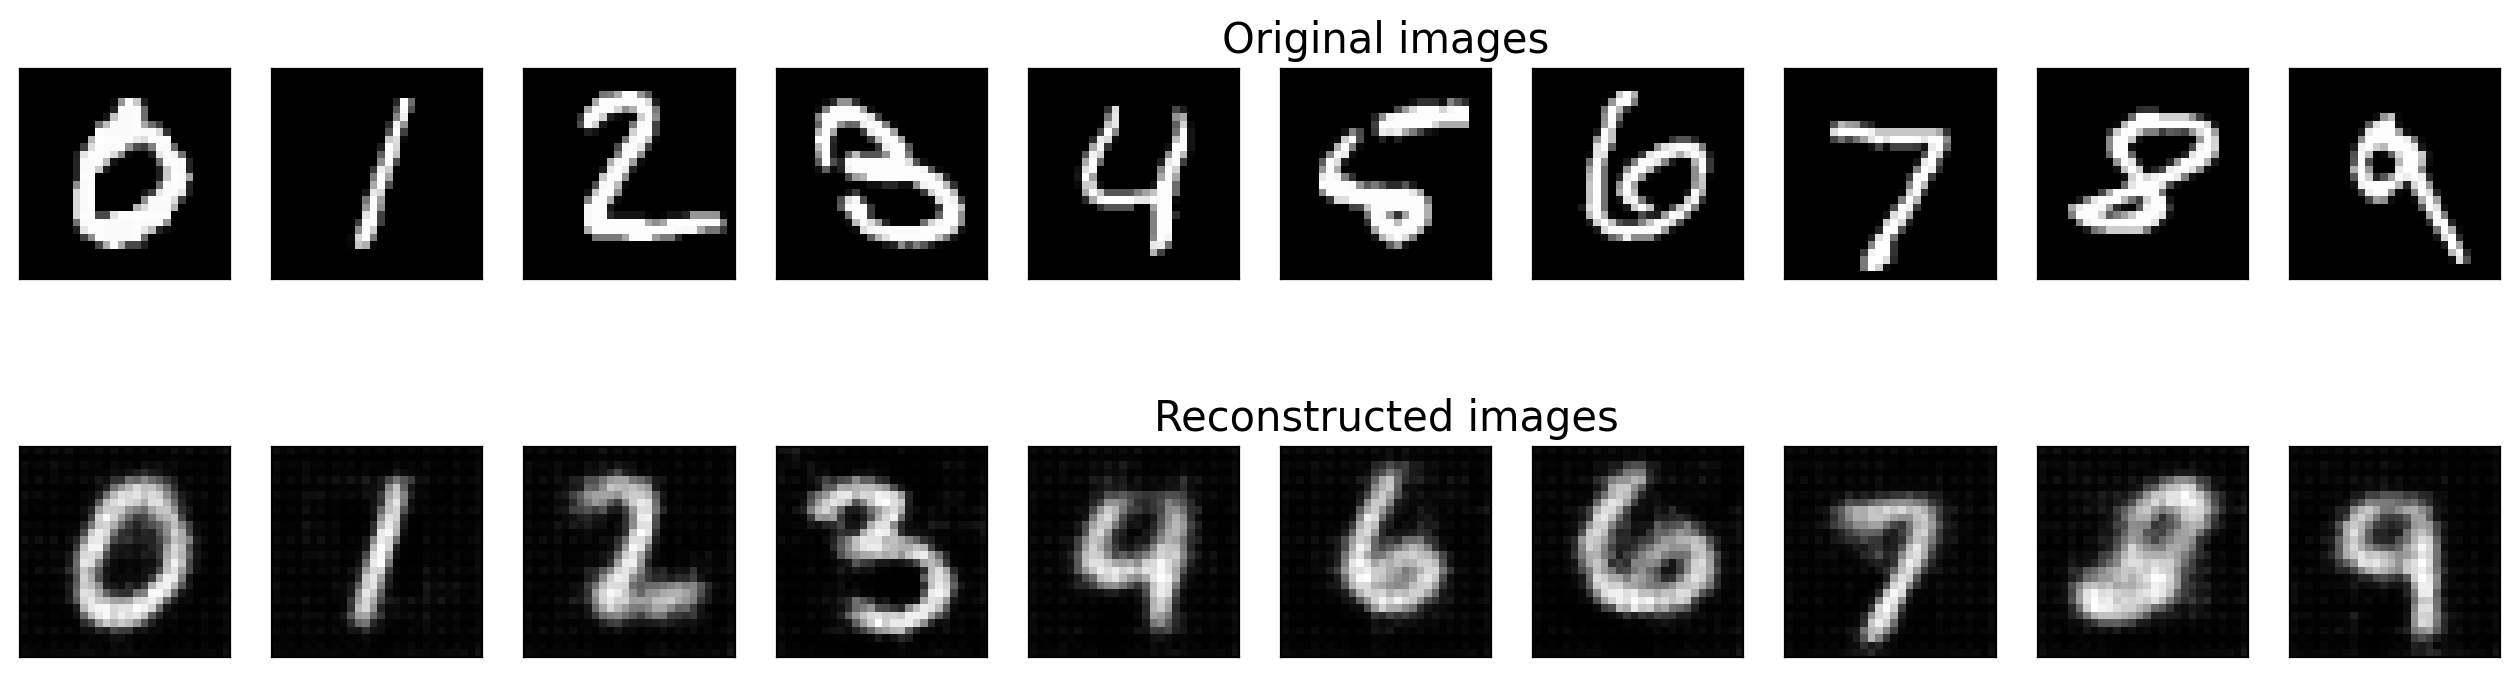


 EPOCH 8/10 	 train loss 32.884 	 val loss 32.674


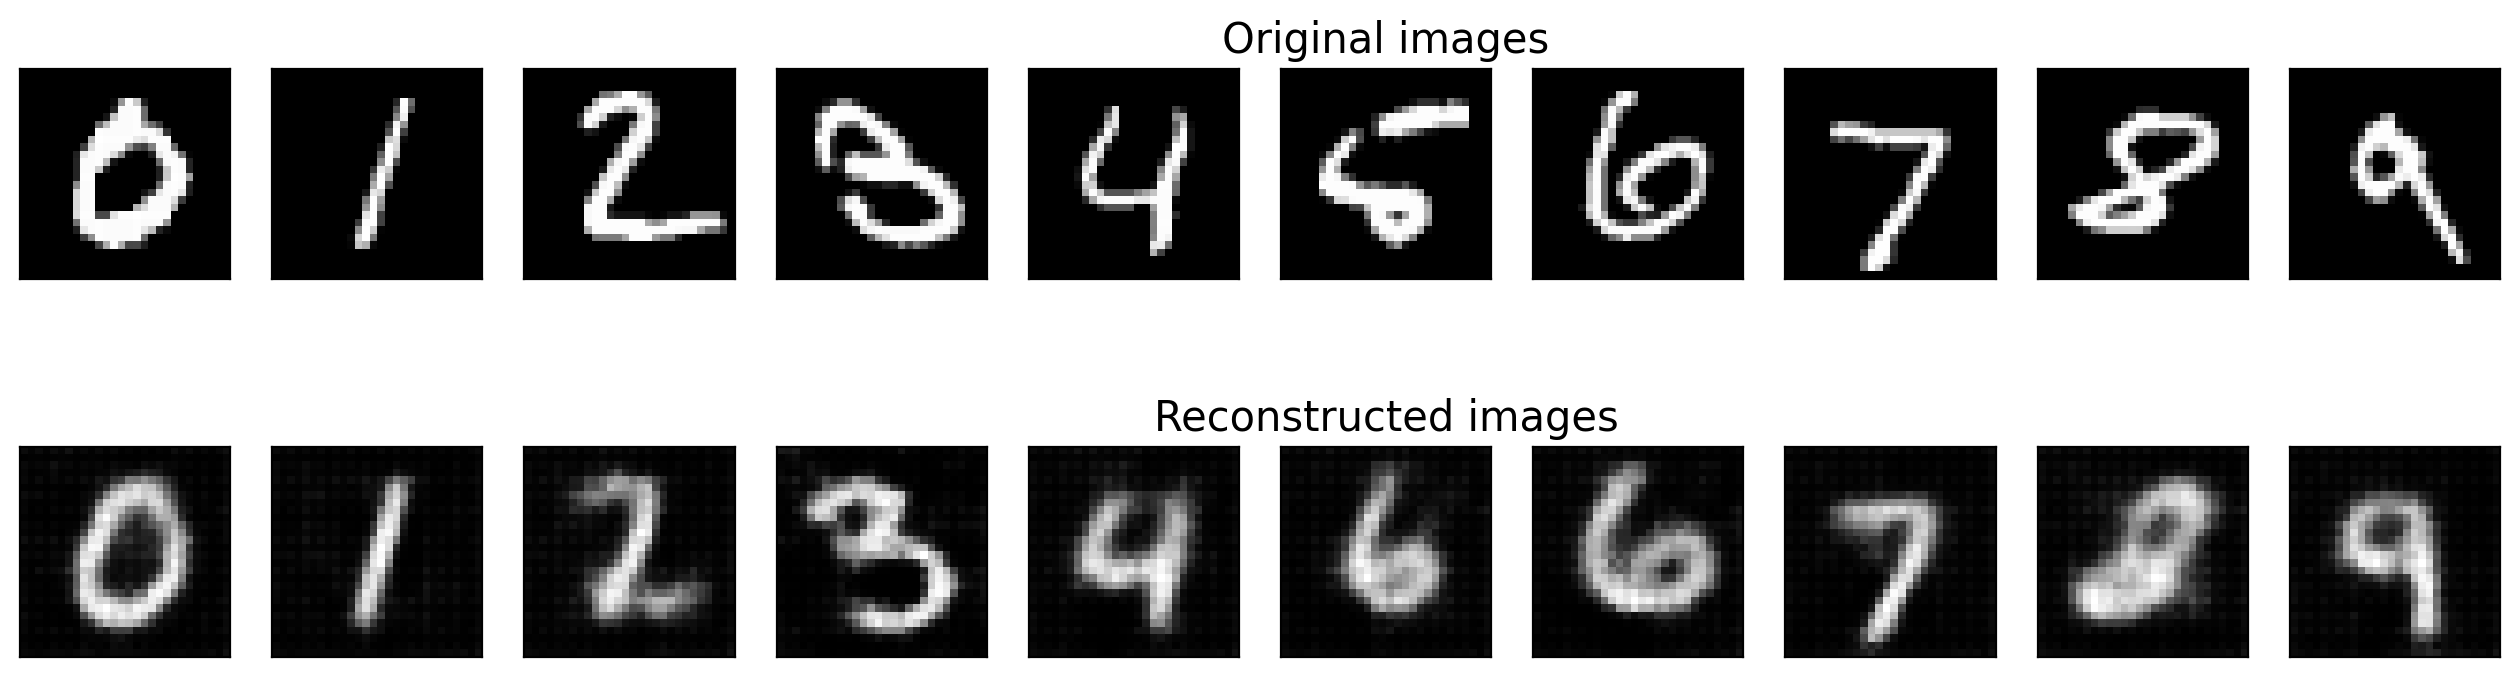


 EPOCH 9/10 	 train loss 32.305 	 val loss 32.295


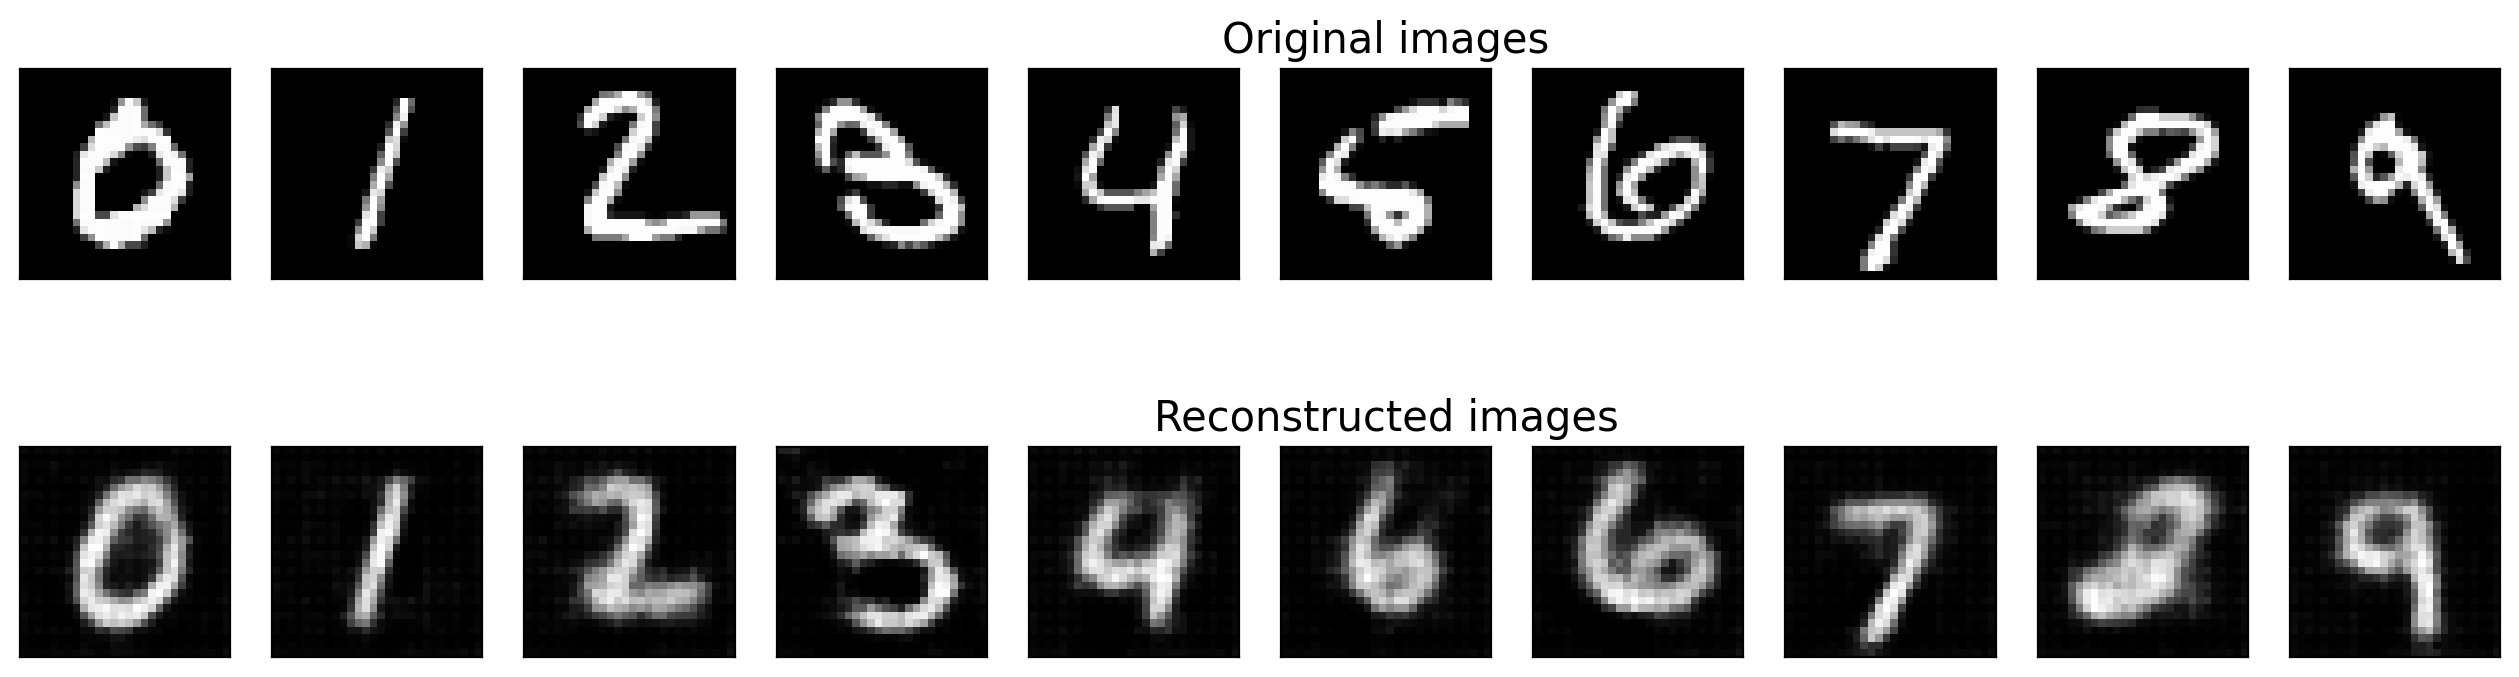


 EPOCH 10/10 	 train loss 31.863 	 val loss 31.904


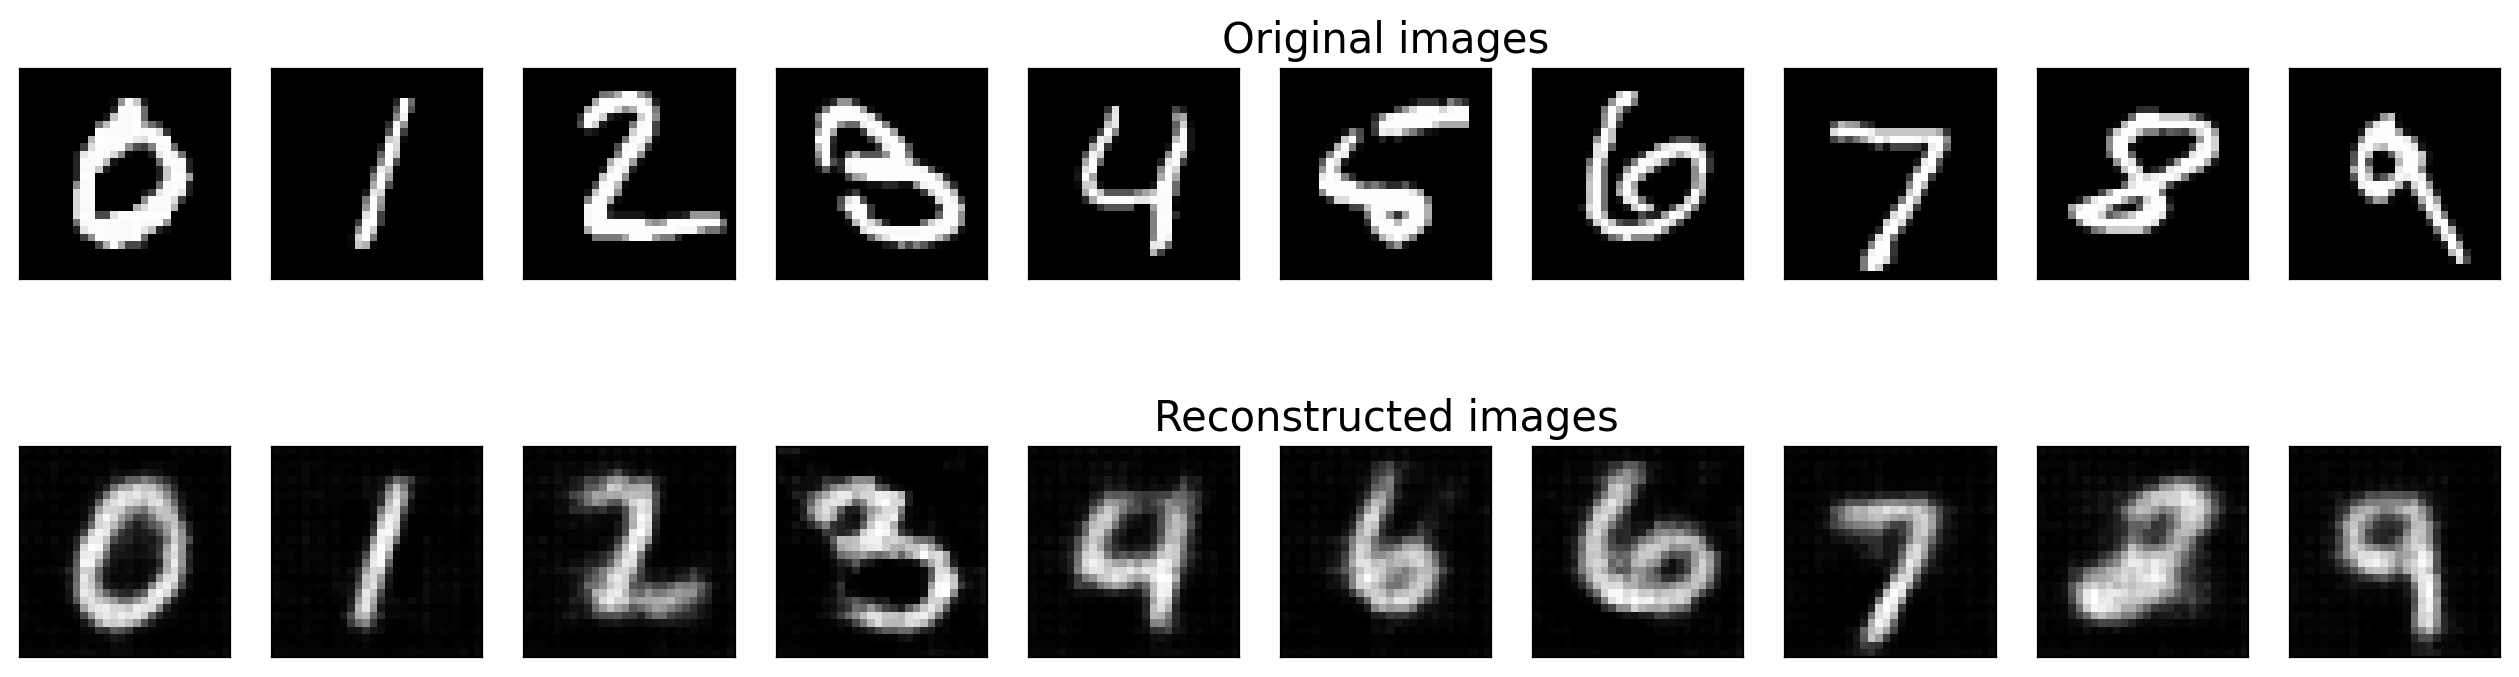

In [59]:
#>>>RUN: L21.1-runcell06

### NOTE: If restarting the training, must run lines below
"""
torch.manual_seed(0)
d = 2
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
"""

num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss = test_epoch(vae,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

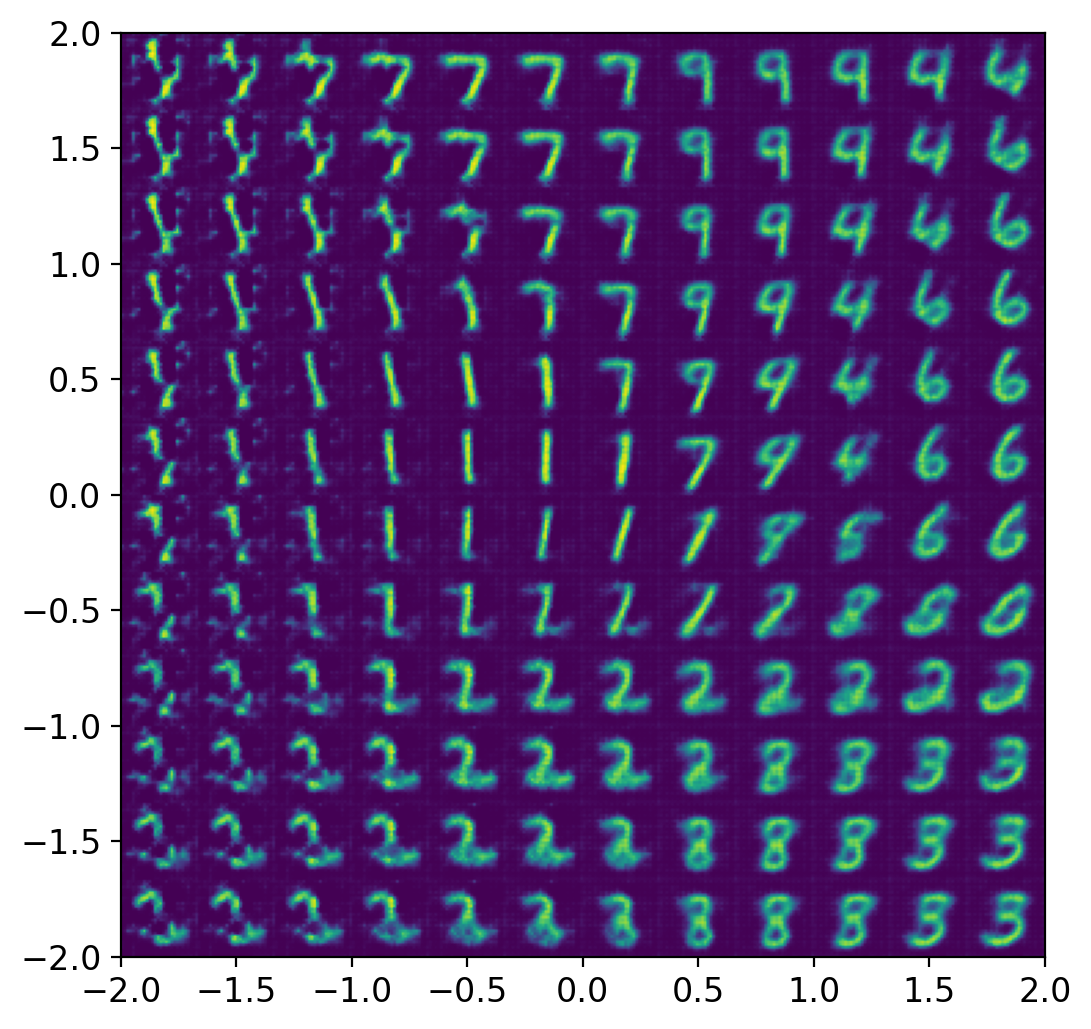

In [60]:
#>>>RUN: L21.1-runcell07

def plot_reconstructed(autoencoder, r0=(-2, 2), r1=(-2, 2), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(vae)

<a name='exercises_22_1'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_1) | [Next Section](#section_22_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.1.1</span>

What is the primary function of the latent space in a Variational Autoencoder (VAE)?

A) To provide a discrete set of vectors that uniquely represent all possible input data.\
B) To serve as a lower-dimensional, continuous representation of the input data, capturing its essential features.\
C) To act as a set of orthogonal vectors used to span the vector space of the input data.\
D) To directly output the reconstructed data from the input.

<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.1.2</span>

When comparing the inputs with the outputs found by sampling the results of the training, we see that it still has difficulty reproducing some numbers (in particular the 3 and 8, although admittedly that's a very odd looking 5). What can we do to make it better? Select ALL that apply, then try all of these for yourself!

A) Decrease the latent space dimension\
B) Increase the latent space dimension\
C) Decrease the number of training epochs\
D) Increase the number of training epochs\
E) Decrease the standard deviation\
F) Increase the standard deviation


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.1.3</span>

Adjust the code in `L21.1-runcell05` (or the commented section in `L21.1-runcell06`) to use a 3-dimensional latent space. How does this change the training and validation losses after 10 epochs, compared to using 2 dimensions? Report both numbers after 10 epochs, as a list `[train_loss, val_loss]` with single-digit precision.


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.1.4</span>


Why are variational autoencoders better or more flexible than regular autoencoders? Select ALL that apply:

A) VAEs model the latent space as a probability distribution, which allows VAEs to generate new data points by sampling from the learned latent space.

B) VAEs force the latent space to be continuous and smooth, which facilitates meaningful interpolations between data points in the latent space.

C) VAEs allow for more flexibility in designing the latent space, such as controlling the dimensionality and imposing specific distributional assumptions (e.g., Gaussian distribution).


<br>

<a name='section_22_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.2 Generating Bragg Scattering with Variational Autoencoders </h2>  

| [Top](#section_22_0) | [Previous Section](#section_22_1) | [Exercises](#exercises_22_2) | [Next Section](#section_22_3) |

In [61]:
#>>>RUN: L21.2-runcell01

import pylandau
from landaupy import landau

#values
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV

def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]


m_e = 0.511 # Mass of electron in MeV

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * np.maximum(0, (X1 - x))**m) #using np.maximum to prevent warning when x > X1
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0 , 0, f2)
    delta_full = np.where(x < X1, delta_full, f3)
    return delta_full

def dEdxF(ip,im,iZ,zpart=1,rho=1.0,nodelta=False): #Bethe-Bloch equation
    K = 0.307075 # constant K in MeV cm mol^-1
    #rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
    const   = zpart**2 * (K * rho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    logterm = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    dEdxV   =  const * (np.log(logterm)  - 2*(beta(ip,im))**2 - delta(ip,im))
    if nodelta:
        print("delta:",delta(ip,im),dEdxV)
        dEdxV    =  const * (np.log(logterm) - 2*(beta(ip,im))**2)
    return dEdxV

mproton=938
mpion=135.4
mmuon=105.4

def X0(iZ):
    const=(716.408**-1)/A(iZ)
    a = iZ/137.
    Lrad =np.log(184.15*iZ**(-1./3.))
    Lradp=np.log(1194*iZ**(-2./3.))
    fZ = a**2*((1+a**2)**(-1)+0.20206-0.0369*a**2+0.0083*a**4-0.002*a**6)
    val=const*(iZ**2*(Lrad-fZ)+iZ*Lradp)
    return 1./val

def sigmaTheta(ip,im,iX0,idx=1.0,zpart=1):
    C=13.6
    X0=iX0
    dx=idx/iX0
    const=C/(beta(ip,im)*ip)*zpart*np.sqrt(dx)
    logterm=1+0.038*np.log(dx*zpart**2/beta(ip,im)**2)
    return const*logterm

def thetaScatter(ip,im,iX0,idx,zpart=1):
    z1=np.random.normal(0,1,ip.shape[0])
    z2=np.random.normal(0,1,ip.shape[0])
    stheta=sigmaTheta(ip,im,iX0,zpart)
    dy    =z1*idx*stheta/np.sqrt(12.) + z2*idx*stheta/2
    dtheta=z2*stheta
    return dtheta,dy

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const


def simNYParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    ystep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    theta=0
    y=0
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    lX0 = X0(iZ)
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        dTheta,dy = thetaScatter(p,im,lX0,idx=dx,zpart=1)
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx*np.cos(theta)
        y      += dy + np.sin(theta)*dx
        theta  += dTheta
        xstep  = np.vstack((xstep,dist))
        ystep  = np.vstack((ystep,y))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    ystep = ystep.T
    return xstep,pstep,estep,ystep

#uncomment and run the simulation to generate the data, if desired
"""
xstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)
"""

'\nxstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)\nxstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)\nxstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)\nxstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)\n'

In [62]:
#>>>RUN: L21.2-runcell02

#load the data from the repository (equivalent to running the simulation above)

#energy 150
xstep150 = np.load('data/L22/xstep150.npy')
pstep150 = np.load('data/L22/pstep150.npy')
estep150 = np.load('data/L22/estep150.npy')
ystep150 = np.load('data/L22/ystep150.npy')

#energy 200
xstep200 = np.load('data/L22/xstep200.npy')
pstep200 = np.load('data/L22/pstep200.npy')
estep200 = np.load('data/L22/estep200.npy')
ystep200 = np.load('data/L22/ystep200.npy')

#energy 250
xstep250 = np.load('data/L22/xstep250.npy')
pstep250 = np.load('data/L22/pstep250.npy')
estep250 = np.load('data/L22/estep250.npy')
ystep250 = np.load('data/L22/ystep250.npy')

#energy 300
xstep300 = np.load('data/L22/xstep300.npy')
pstep300 = np.load('data/L22/pstep300.npy')
estep300 = np.load('data/L22/estep300.npy')
ystep300 = np.load('data/L22/ystep300.npy')

In [63]:
#>>>RUN: L21.2-runcell03

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

def createData(ixstep,ipstep,iestep,iystep):
    length=ixstep[:,-1]
    width =iystep[:,-1]
    efront=np.zeros(ixstep.shape[0])
    eback =np.zeros(ixstep.shape[0])
    for i0 in range(ixstep.shape[0]):
        efront[i0] = np.sum(iestep[i0,ixstep[i0] < 3])/3.
        eback[i0]  = np.sum(iestep[i0,ixstep[i0] > ixstep[i0,-1]-1])
    processed_data = np.vstack((length,width,efront,eback))
    trainset       = torch.tensor(processed_data).float()
    return trainset

indataset150=createData(xstep150,pstep150,estep150,ystep150)
indataset150=indataset150.T

indataset200=createData(xstep200,pstep200,estep200,ystep200)
indataset200=indataset200.T

indataset250=createData(xstep250,pstep250,estep250,ystep250)
indataset250=indataset250.T

indataset300=createData(xstep300,pstep300,estep300,ystep300)
indataset300=indataset300.T

indataset   = np.vstack((indataset150,indataset200,indataset250,indataset300))
print(indataset.shape)

(4000, 4)


In [64]:
#>>>RUN: L21.2-runcell04

class DataSet(Dataset):
    def __init__(self, samples, labels):
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def nfeatures(self):
        return self.samples.shape[1]

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

dataset150=DataSet(samples=indataset150,labels=np.ones(indataset150.shape[0])*150)
dataset=DataSet(samples=indataset,labels=np.ones(indataset.shape[0])*150)

In [65]:
#>>>RUN: L21.2-runcell05

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dims,latent_dims):
        super(VariationalAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 10*input_dims)
        self.batch = nn.BatchNorm1d(10*input_dims)
        self.linear2 = nn.Linear(10*input_dims, 10*input_dims)
        self.linear3 = nn.Linear(10*input_dims, latent_dims)
        self.linear4 = nn.Linear(10*input_dims, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, input_dims),
        )

    def encoder(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.batch(self.linear2(x)))
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear3(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear4(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

    def encoder_nosmear(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.batch(self.linear2(x)))
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear3(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear4(x)) #sigma in the space
        return mu,sigma

    def decoder(self, x):
        x = self.decoder_lin(x)
        return x

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

torch.manual_seed(0)
d = 2
vae = VariationalAutoEncoder(input_dims=dataset.nfeatures(),latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#valid_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [66]:
#>>>RUN: L21.2-runcell06

#redefine functions from the previous section (if you have not run L21.1)

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [67]:
#>>>RUN: L21.2-runcell07

num_epochs = 5001

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    #val_loss = test_epoch(vae,valid_loader)
    if epoch % 500 == 0:
        print('EPOCH {}/{} \t train loss {:.3f} \t'.format(epoch + 1, num_epochs,train_loss))


EPOCH 1/5001 	 train loss 1460.897 	
EPOCH 501/5001 	 train loss 7.416 	
EPOCH 1001/5001 	 train loss 6.524 	
EPOCH 1501/5001 	 train loss 6.348 	
EPOCH 2001/5001 	 train loss 6.219 	
EPOCH 2501/5001 	 train loss 6.145 	
EPOCH 3001/5001 	 train loss 6.126 	
EPOCH 3501/5001 	 train loss 6.111 	
EPOCH 4001/5001 	 train loss 6.083 	
EPOCH 4501/5001 	 train loss 6.100 	
EPOCH 5001/5001 	 train loss 6.046 	


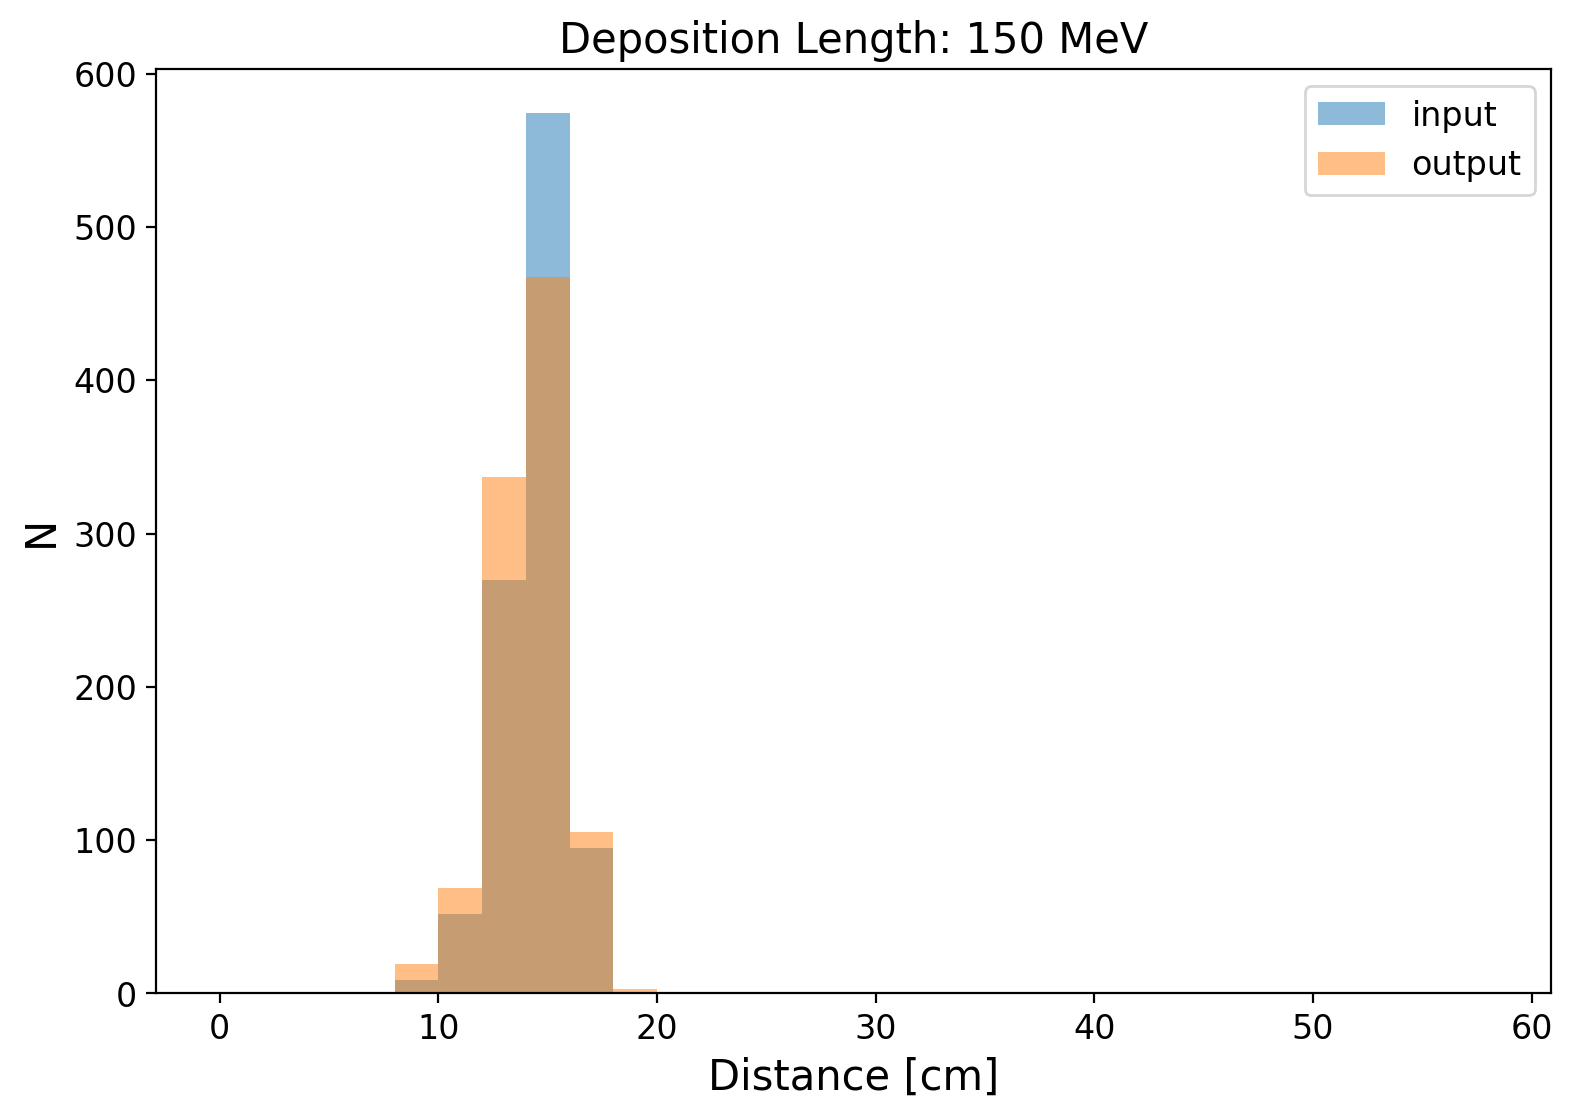

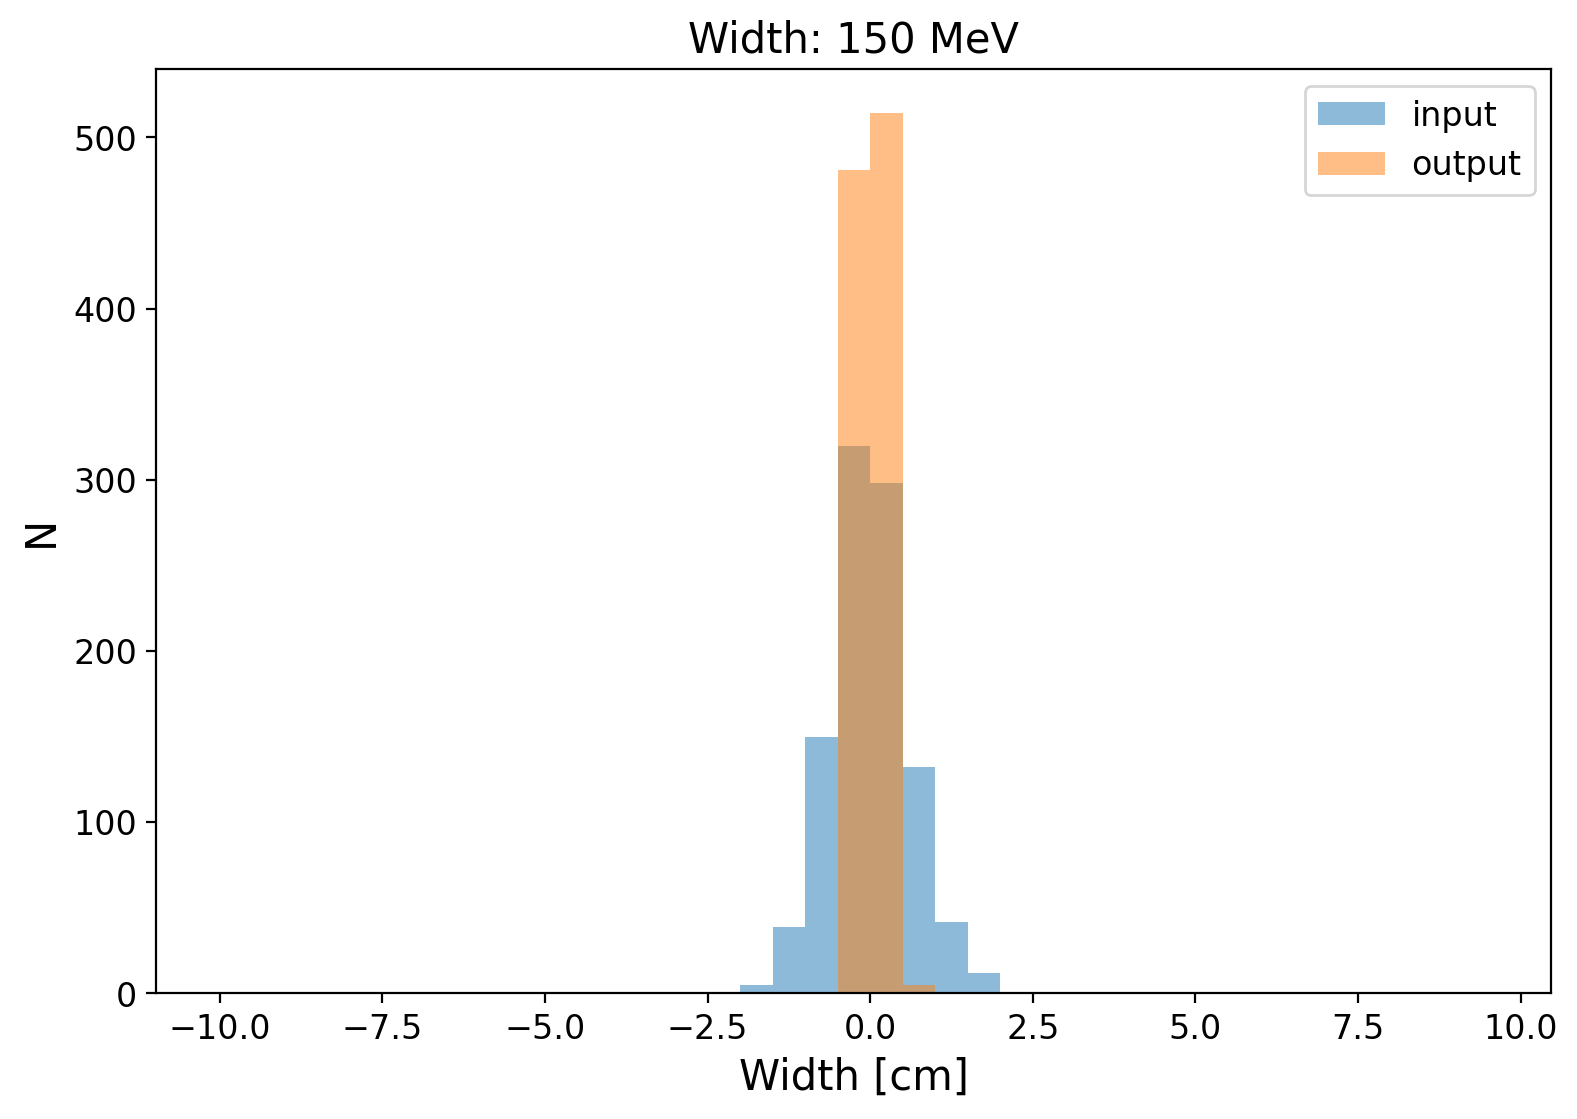

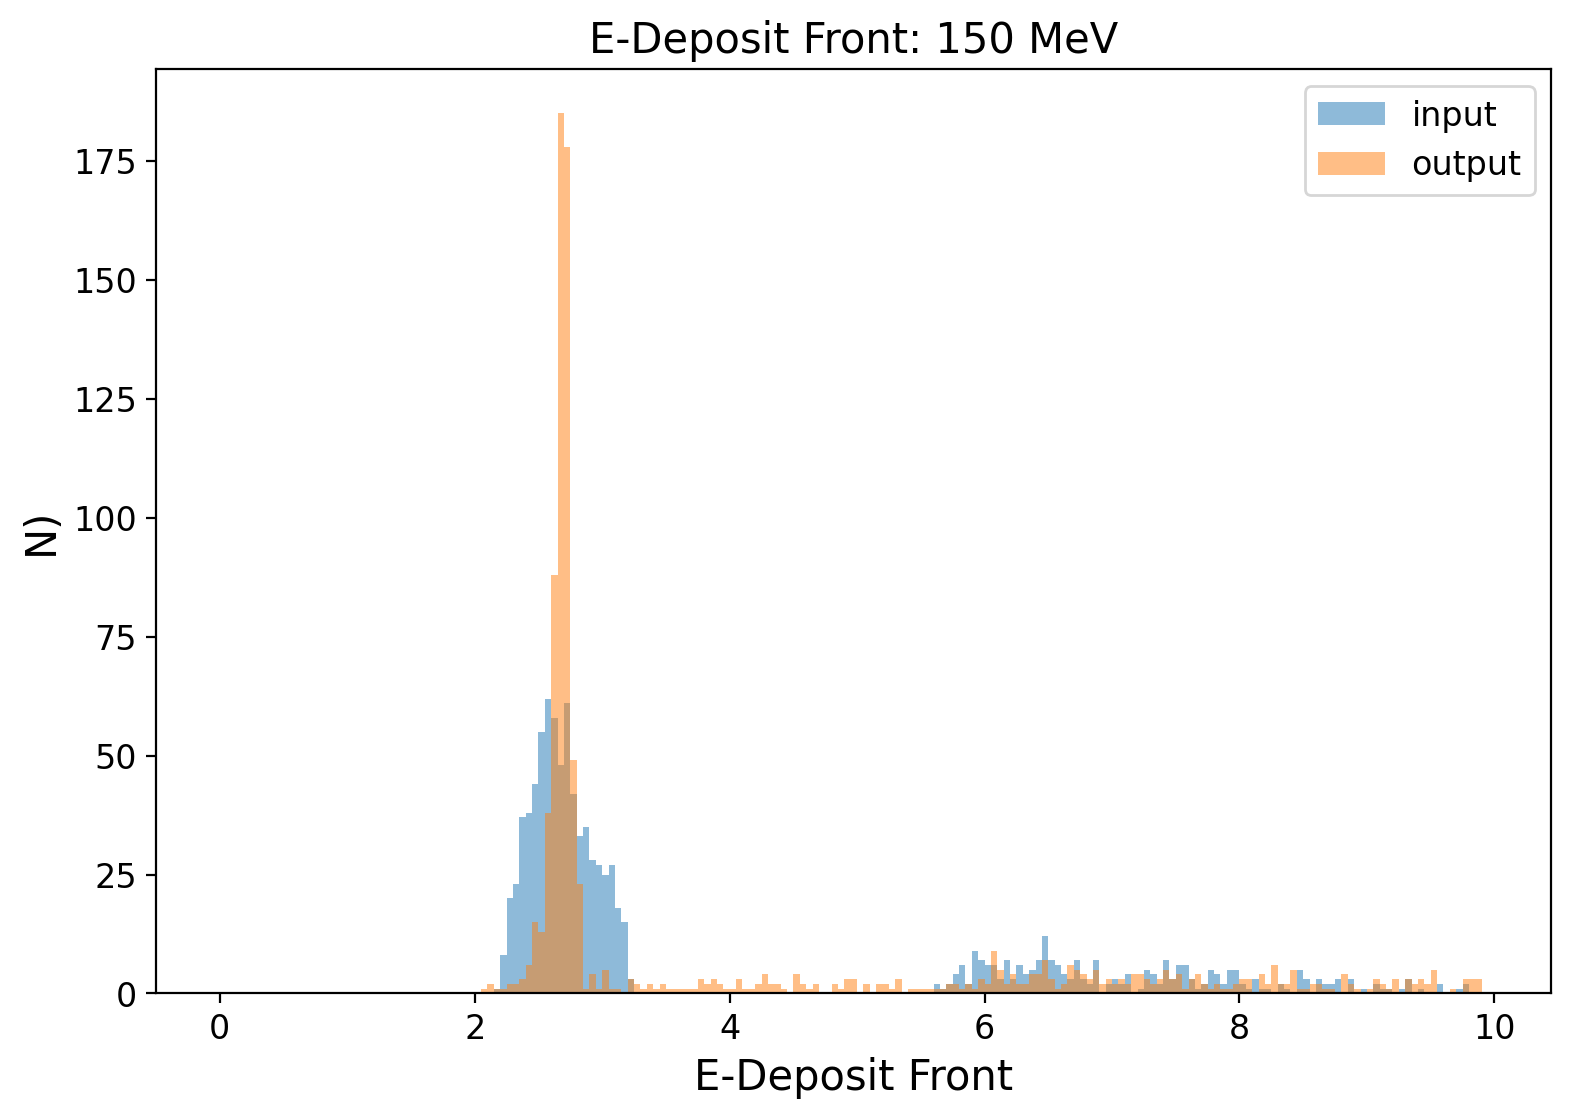

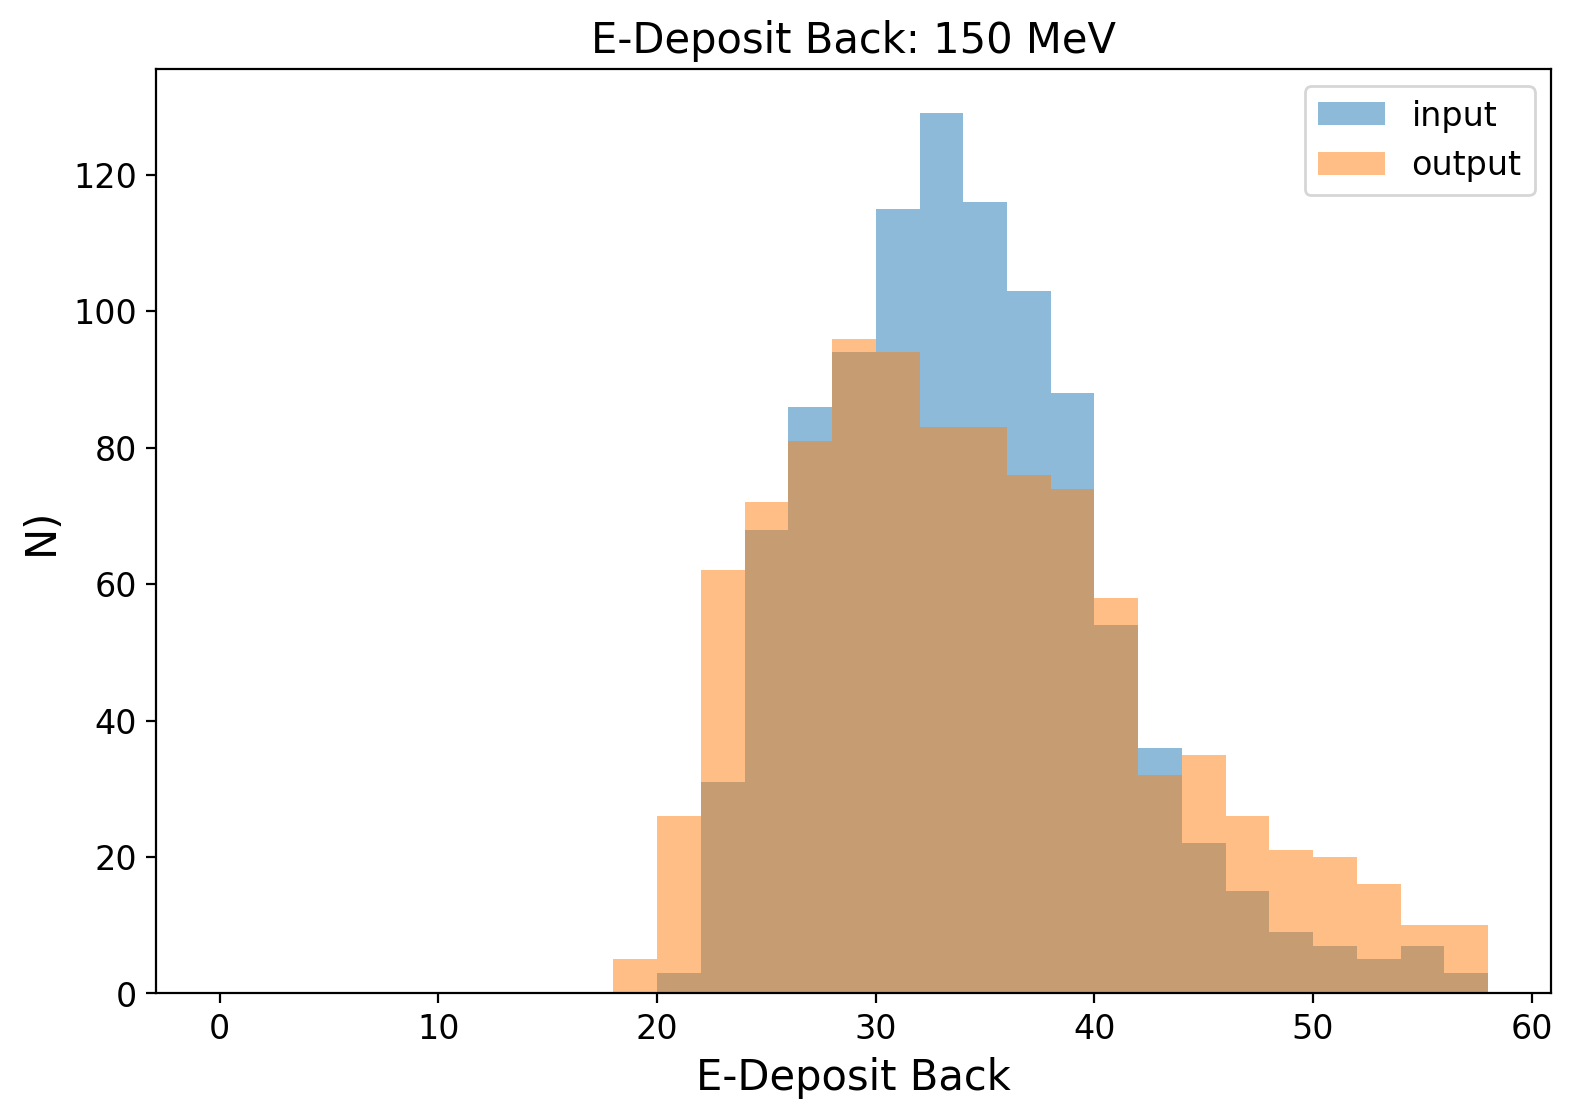

In [68]:
#>>>RUN: L21.2-runcell08

def plotVAEOutputs(iLatentDim,iDataSet):
    #generate events assuming a random normal with latent dimension given the the latent space
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    #now decode thme into observables
    outputvars=vae.decoder(testlatent)

    xrange=np.arange(0,60,2)
    plt.title('Deposition Length: 150 MeV')
    plt.xlabel('Distance [cm]')
    plt.ylabel('N')
    plt.hist(iDataSet[:,0],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,0].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(-10,10,0.5)
    plt.title('Width: 150 MeV')
    plt.xlabel('Width [cm]')
    plt.ylabel('N')
    plt.hist(iDataSet[:,1],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,1].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,10,0.05)
    plt.title('E-Deposit Front: 150 MeV')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.hist(iDataSet[:,2],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,2].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.title('E-Deposit Back: 150 MeV')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.hist(iDataSet[:,3],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,3].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

plotVAEOutputs(d,indataset150)

<a name='exercises_22_2'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_2) | [Next Section](#section_22_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.2.1</span>

Let's test the fidelity of the network. Plot the encoding of our setup using the `corner` plot function, which we will use many times in future lessons. A corner plot shows the posterior distributions of fit parameters, with 2D plots revealing any correlations between parameters. Thus, with a corner plot, we will learn the best estimates for the parameters of the latent space: $\mu_{1}$, $\mu_{2}$, $\sigma_{1}$,  and $\sigma_{2}$.

Run the code below, where use the `encoder_nosmear` function to output $\mu$ and $\sigma$ of the VAE latent space for each event. Are these values consistent with our expectation, that $\mu_{1}$, $\mu_{2}$ are 0 and $\sigma_{1}$,  and $\sigma_{2}$ are 1?

Report the values as a list of numbers `[mu1, mu2, sigma1, sigma2]` with precision `1e-2`. Since it may be the case that your code defines `mu1` and `mu2` oppositely from us (the order is arbitraty), let's explicitly define the `mu` values with `mu1` as the smallest and `mu2` as the largest. So, if you found the following set of parameters: `mu1=0.5`, `mu2=0.1`, `sigma1=0.01`, `sigma2=0.02`, then you should submit this as: `[0.1, 0.5, 0.02, 0.01]`.

<br>

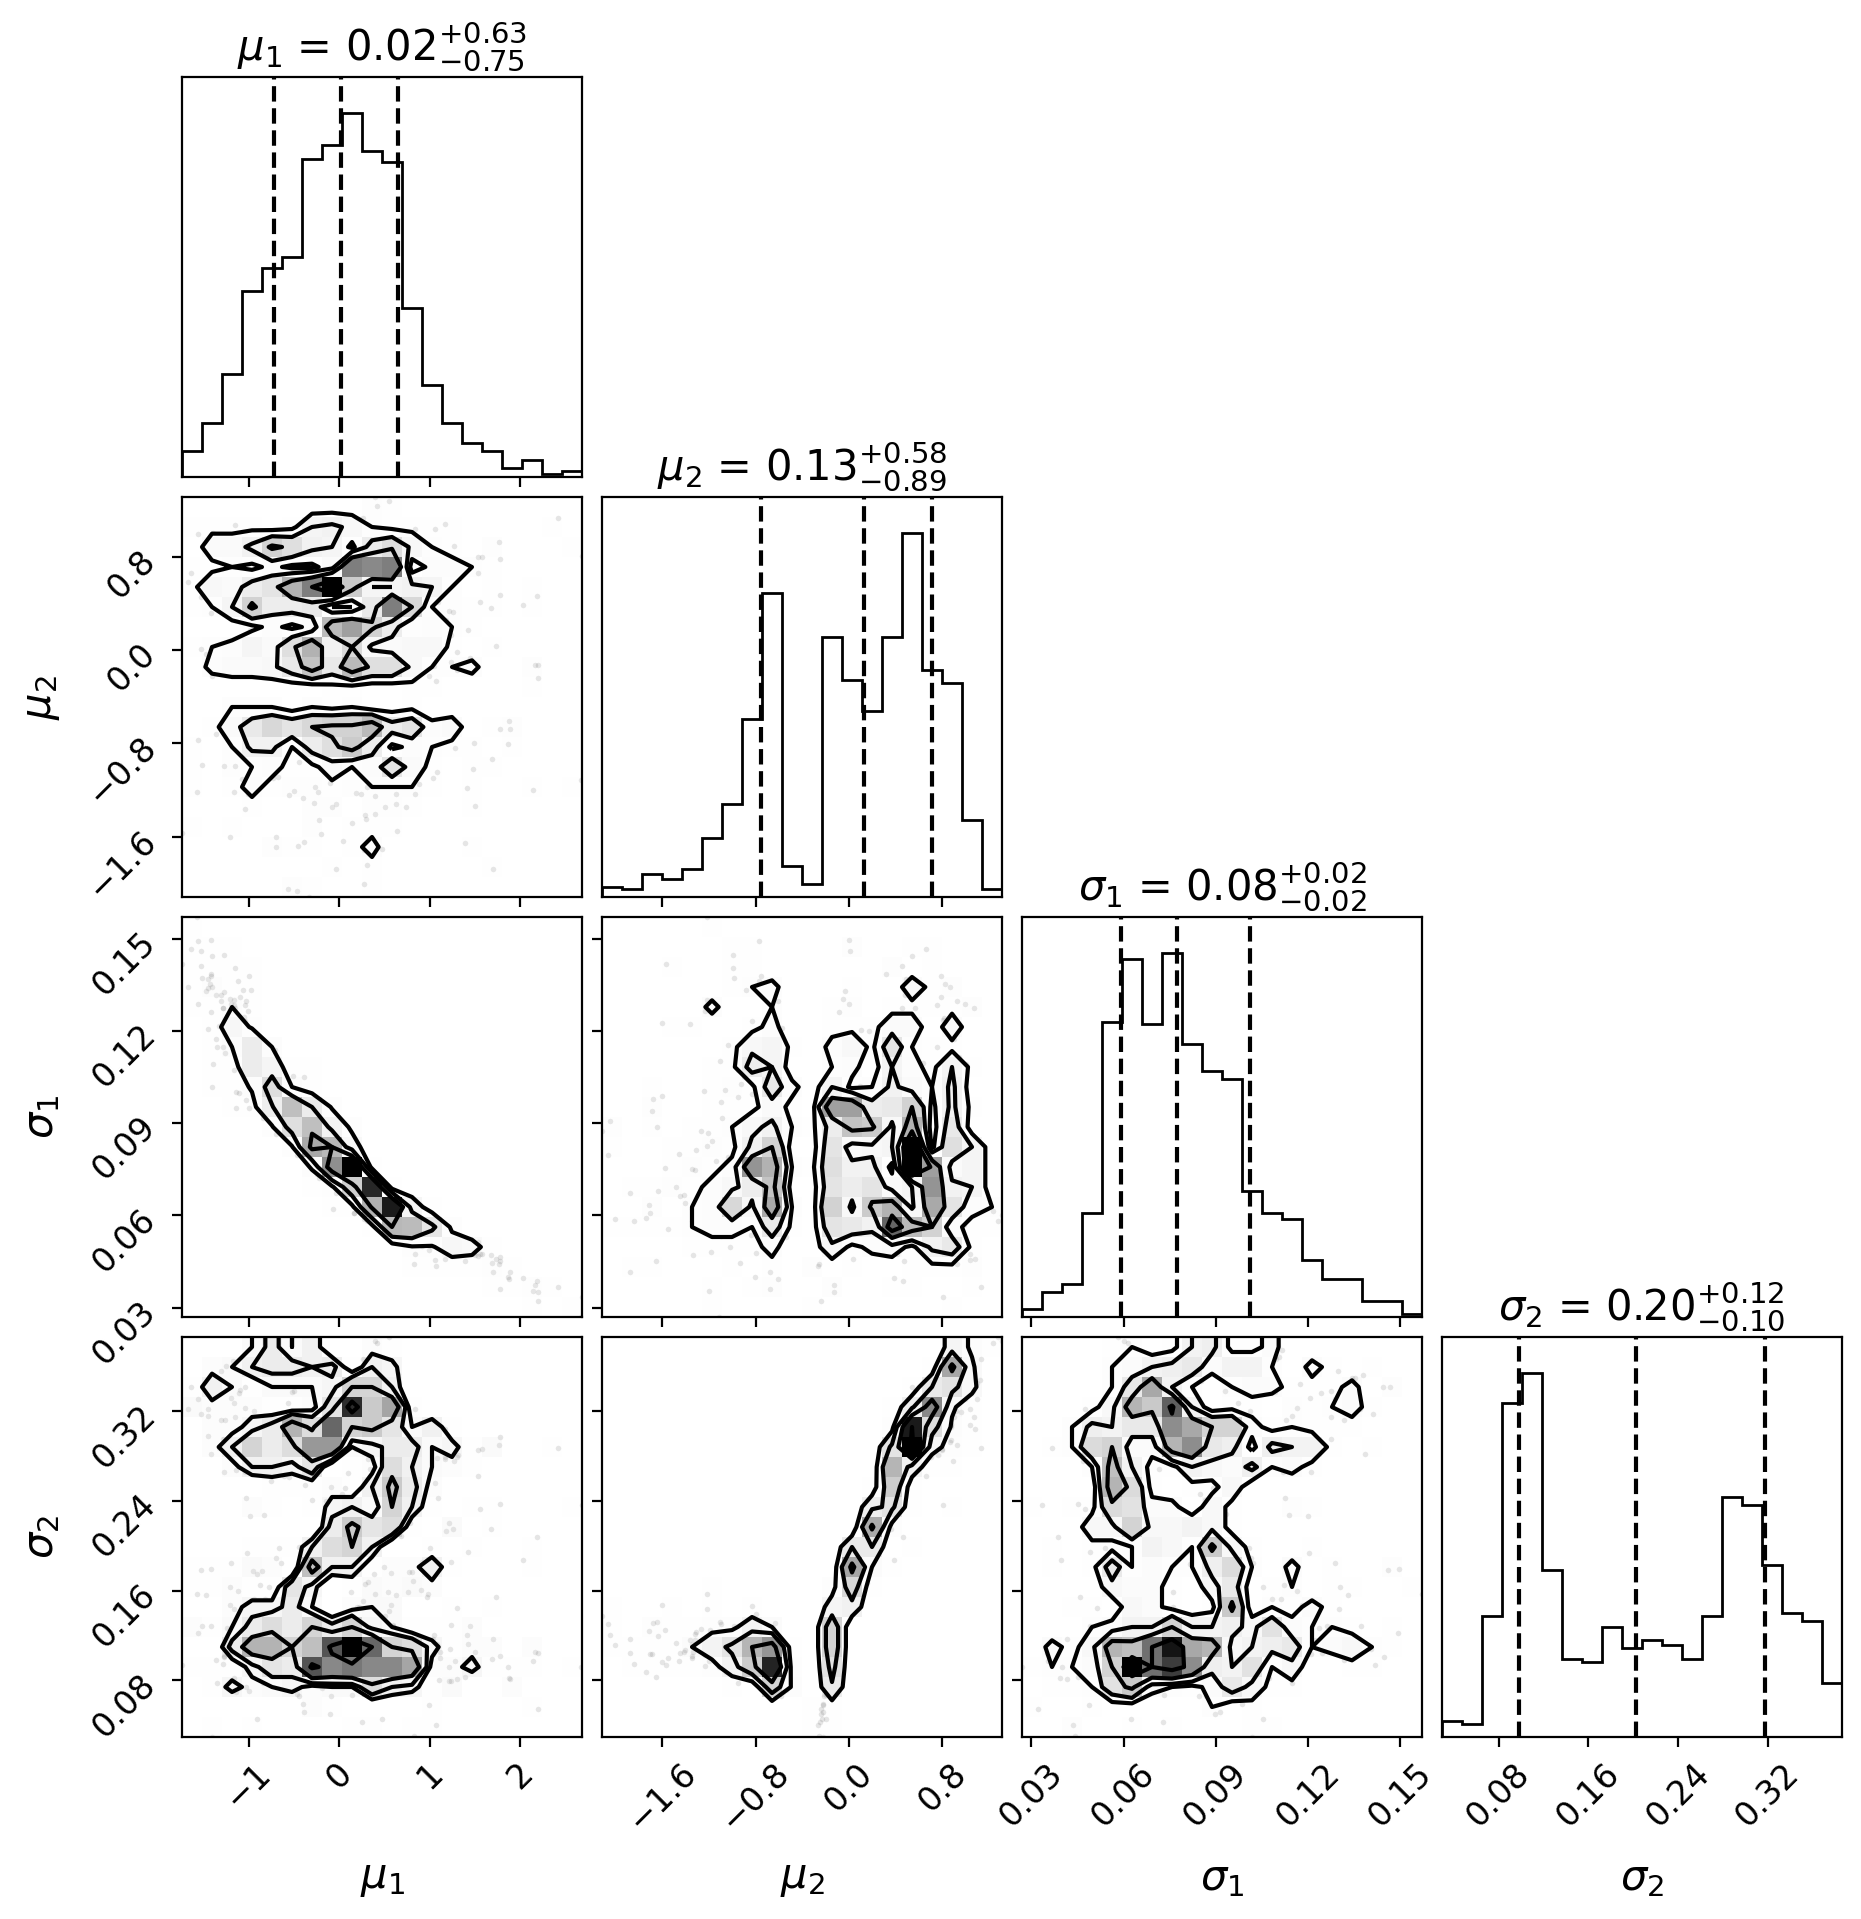

In [69]:
#>>>EXERCISE: L21.2.1

mu,sigma=vae.encoder_nosmear(indataset150)
allvars=np.hstack((mu.detach().numpy(),sigma.detach().numpy()))
corner.corner(allvars,show_titles=True,labels=['$\mu_{1}$','$\mu_{2}$','$\sigma_{1}$','$\sigma_{2}$'],plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.2.2</span>

Now we will modify the `plotVAEOutputs` function from `L21.2-runcell08` above, by giving it the values for the latent space, `mu` and `sigma`, that were found by the encoder.  We can then have it sample a normal distribution with these parameters, generate outputs, and compare to the inputs (i.e., true distributions). Run the code below and determine which one of the following characteristics has the most improved agreement between the inputs and outputs of the VAE.

A) Deposition Length\
B) Width\
C) E-Deposit Front\
D) E-Deposit Back

<br>

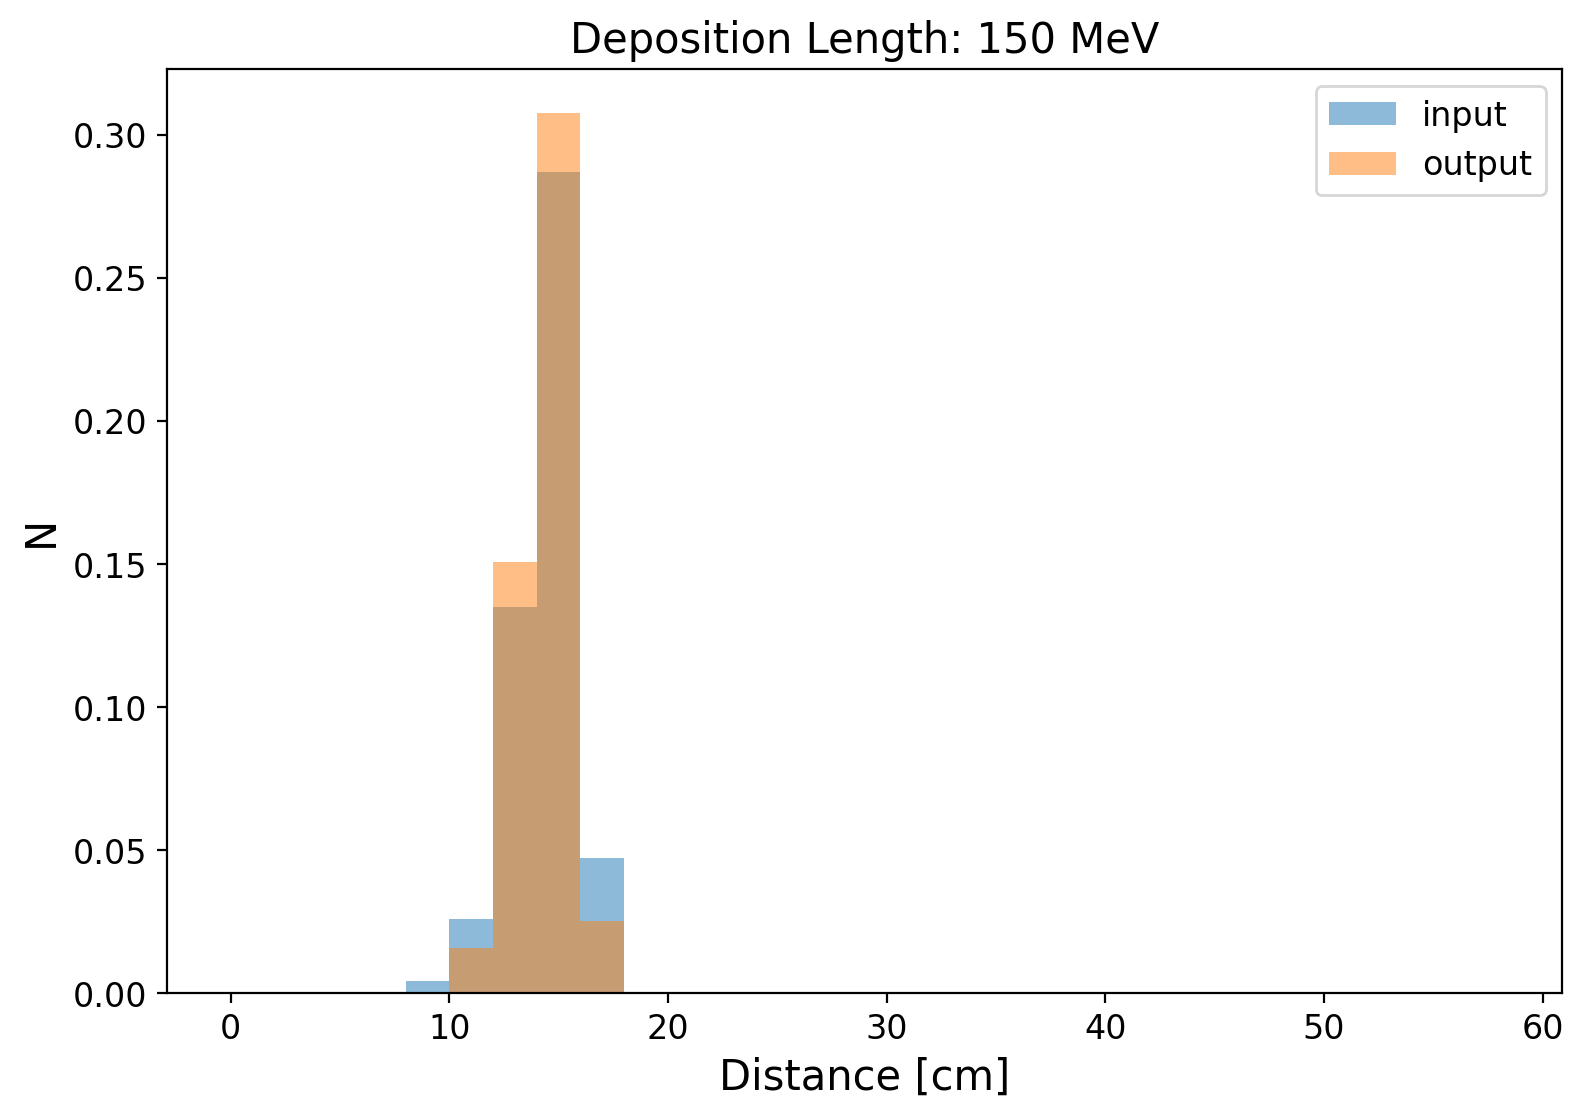

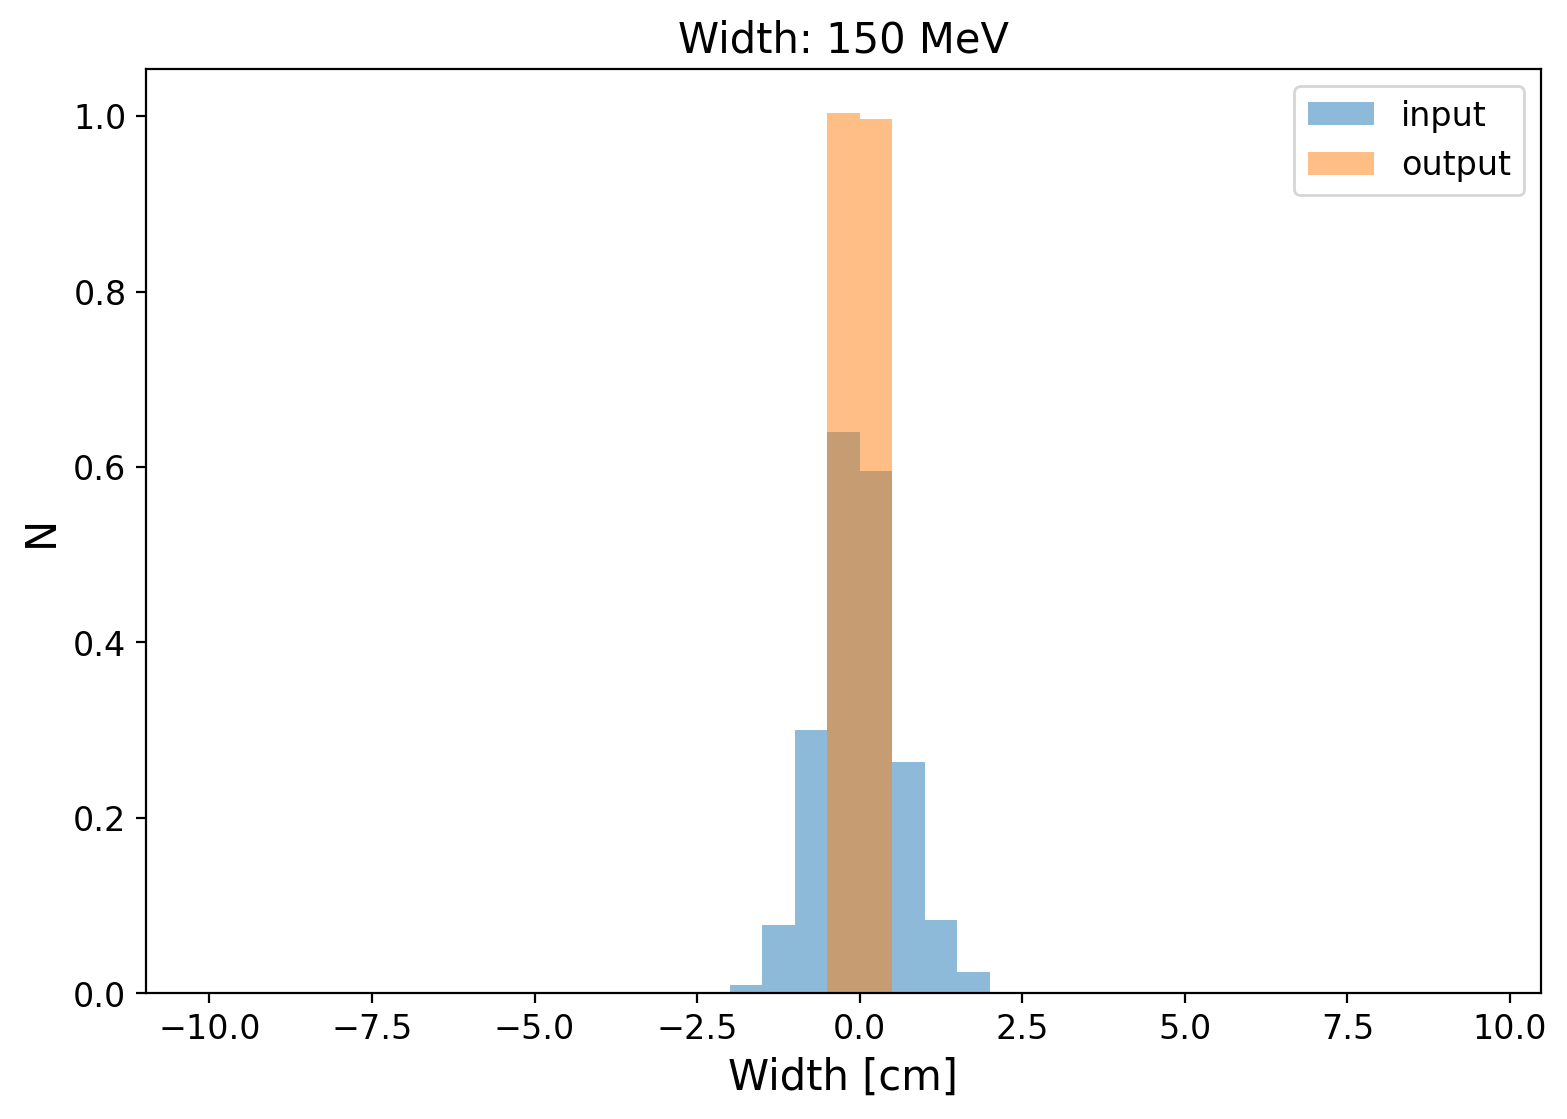

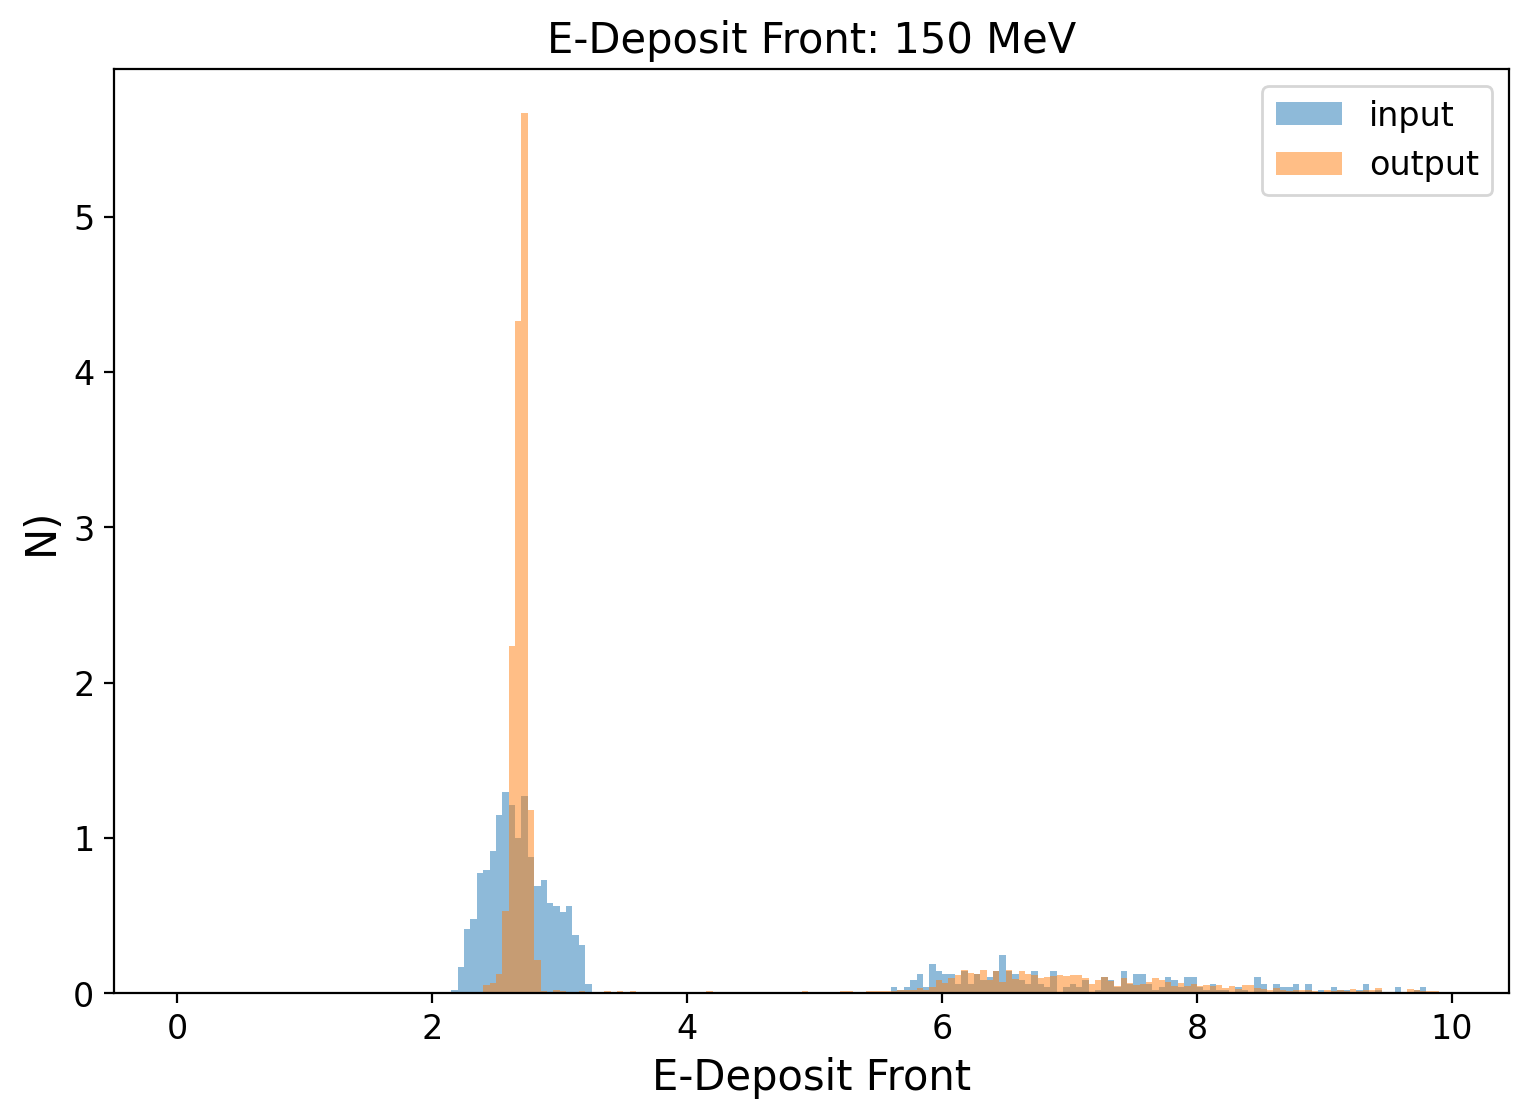

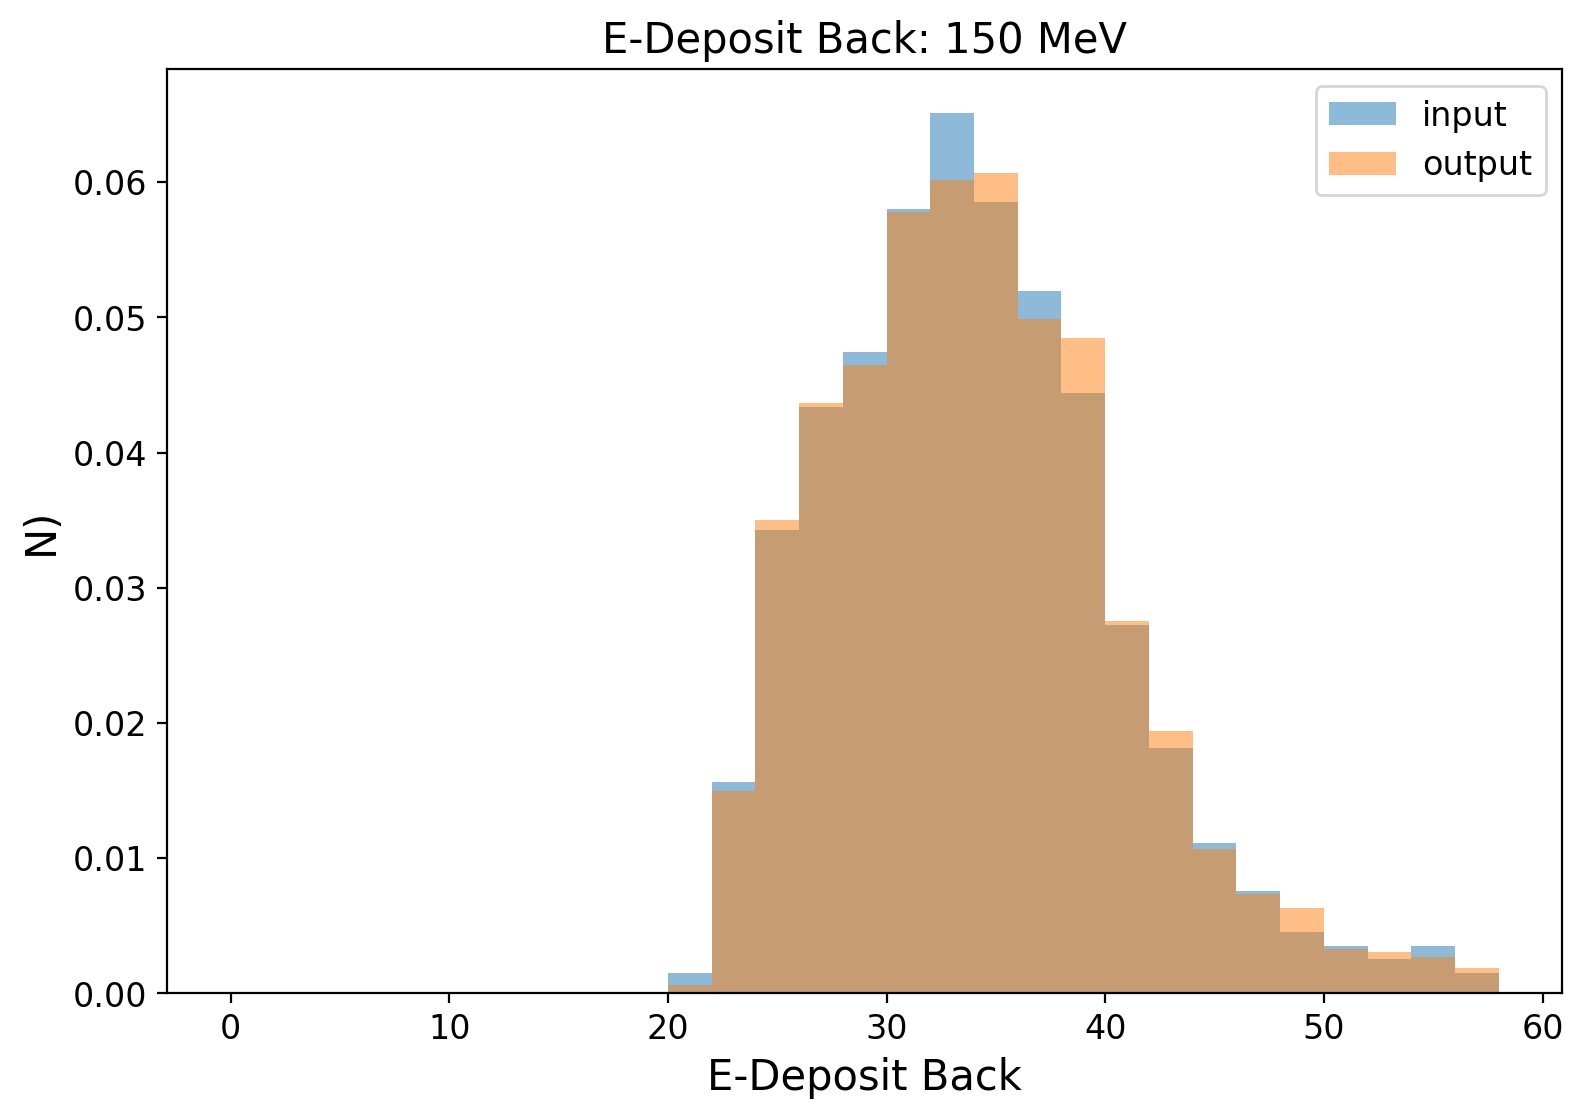

In [70]:
#>>>EXERCISE: L21.2.2

def plotVAEOutputs_Real(iMu,iSigma,iLatentDim,iDataSet):
    #generate events assuming a random normal, based on the latent space values iMu and iSigma
    testlatent=torch.randn(iMu.shape)
    testlatent=testlatent*iSigma+iMu
    #now decode thme into observables
    outputvars = vae.decoder(testlatent)
    #now because we can, lets ust generate 5 times as many events
    for i in range(0,5):
        testlatent=torch.randn(iMu.shape)
        testlatent=testlatent*iSigma+iMu
        outputvars=torch.cat((outputvars,vae.decoder(testlatent)))

    xrange=np.arange(0,60,2)
    plt.title('Deposition Length: 150 MeV')
    plt.xlabel('Distance [cm]')
    plt.ylabel('N')
    plt.hist(iDataSet[:,0],label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(outputvars[:,0].detach().numpy(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(-10,10,0.5)
    plt.title('Width: 150 MeV')
    plt.xlabel('Width [cm]')
    plt.ylabel('N')
    plt.hist(iDataSet[:,1],label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(outputvars[:,1].detach().numpy(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,10,0.05)
    plt.title('E-Deposit Front: 150 MeV')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.hist(iDataSet[:,2],label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(outputvars[:,2].detach().numpy(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.title('E-Deposit Back: 150 MeV')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.hist(iDataSet[:,3],label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(outputvars[:,3].detach().numpy(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

mu,sigma=vae.encoder_nosmear(indataset150)
plotVAEOutputs_Real(mu,sigma,d,indataset150)

<a name='section_22_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.3 Generating Full Bragg Scattering Details </h2>  

| [Top](#section_22_0) | [Previous Section](#section_22_2) | [Exercises](#exercises_22_3) | [Next Section](#section_22_4) |

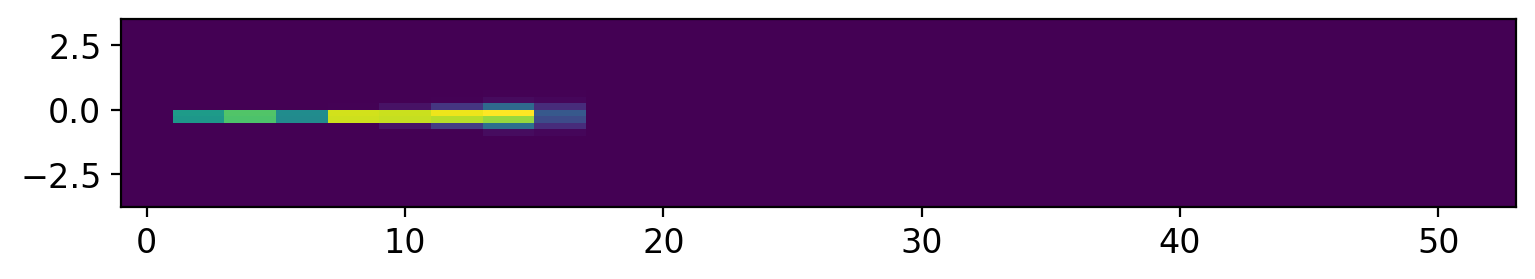

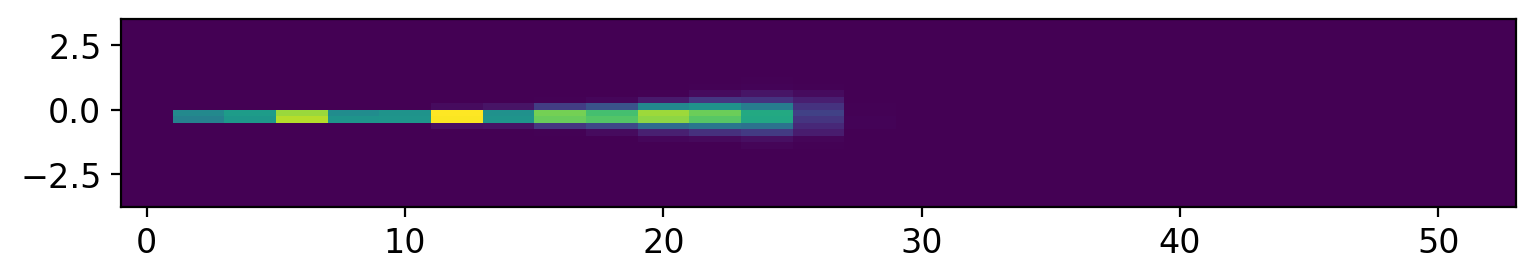

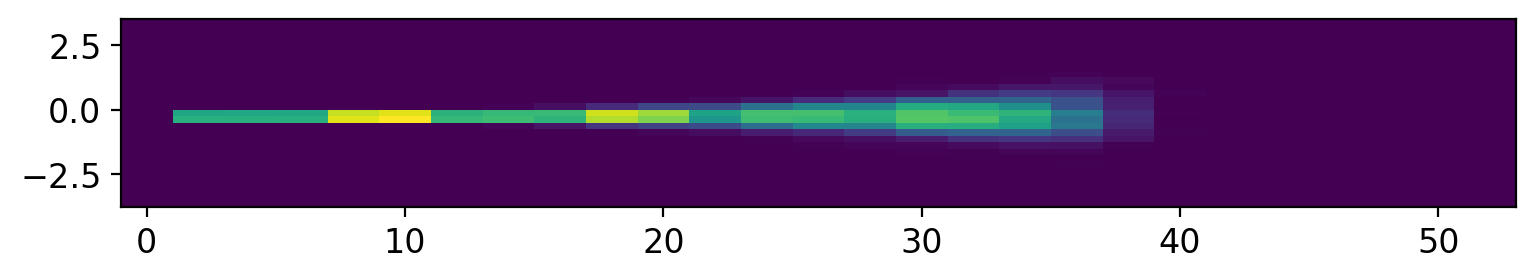

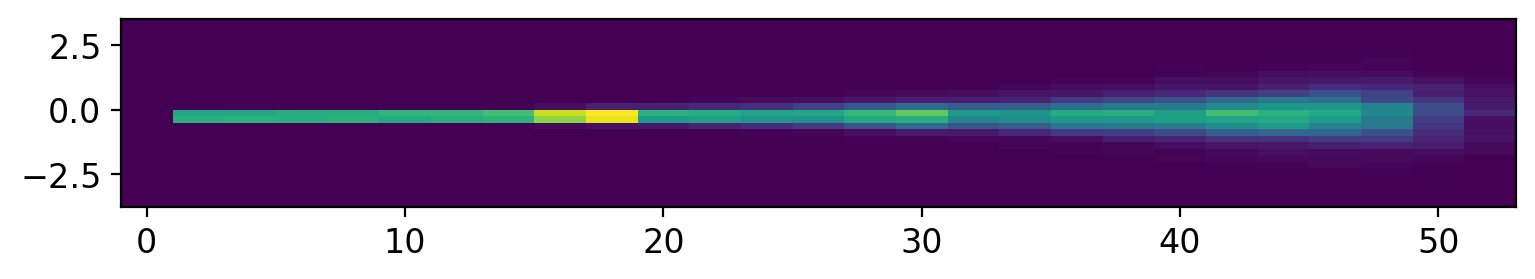

In [71]:
#>>>RUN: L21.3-runcell01

def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now let's make a regular image
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)


def makeImageDataSet(iE,ixstep,iestep,iystep):
    dataset=np.empty((0,1,28,28))
    for pX,pE,pY in zip(ixstep,iestep,iystep):
        xbin = np.arange(-1,57, 2)
        ybin = np.arange(-3.625, 3.625, 0.25)
        H, xedges, yedges = np.histogram2d(pX.flatten(), pY.flatten(), bins=(xbin, ybin),weights=pE.flatten())
        #H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
        #plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        #plt.show()
        H = np.reshape(H.T,(1,1,28,28))
        dataset = np.vstack((dataset,H))
    #print(dataset.shape)
    Tdataset = torch.tensor(dataset).float()
    datasetout=DataSet(samples=Tdataset,labels=np.ones(dataset.shape[0])*iE)
    return datasetout,dataset

image150,dimage150=makeImageDataSet(1.50,xstep150,estep150,ystep150)
image200,dimage200=makeImageDataSet(2.00,xstep200,estep200,ystep200)
image250,dimage250=makeImageDataSet(2.50,xstep250,estep250,ystep250)
image300,dimage300=makeImageDataSet(3.00,xstep300,estep300,ystep300)

In [72]:
#>>>RUN: L21.3-runcell02

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

    def encoder_nosmear(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        return mu,sigma

    def decoder(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

torch.manual_seed(0)
d = 4
vae = VariationalAutoEncoder(latent_dims=d)
lr = 1e-2
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(image150, batch_size=500)

In [73]:
#>>>RUN: L21.3-runcell03

def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      vae.eval()
      #encoder.eval()
      #decoder.eval()
      with torch.no_grad():
         rec_img  = vae.decoder(vae.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()



 EPOCH 1/2500 	 train loss 4174.612 	 val loss 0.000


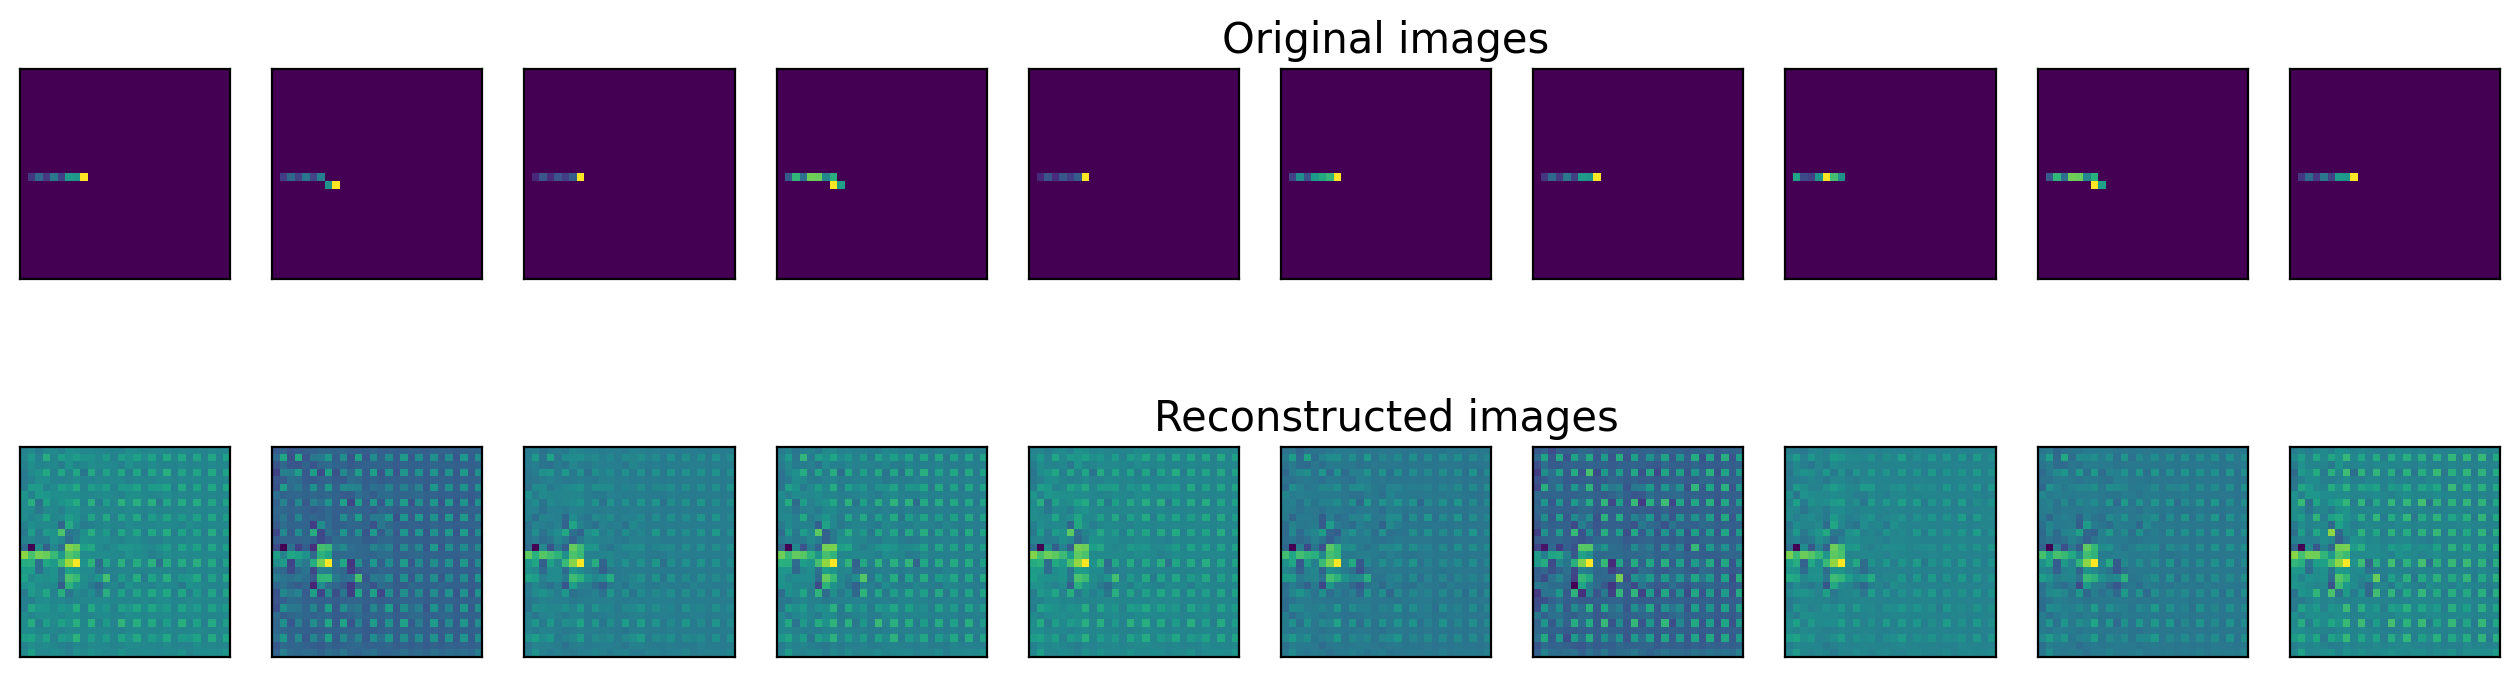


 EPOCH 501/2500 	 train loss 92.857 	 val loss 0.000


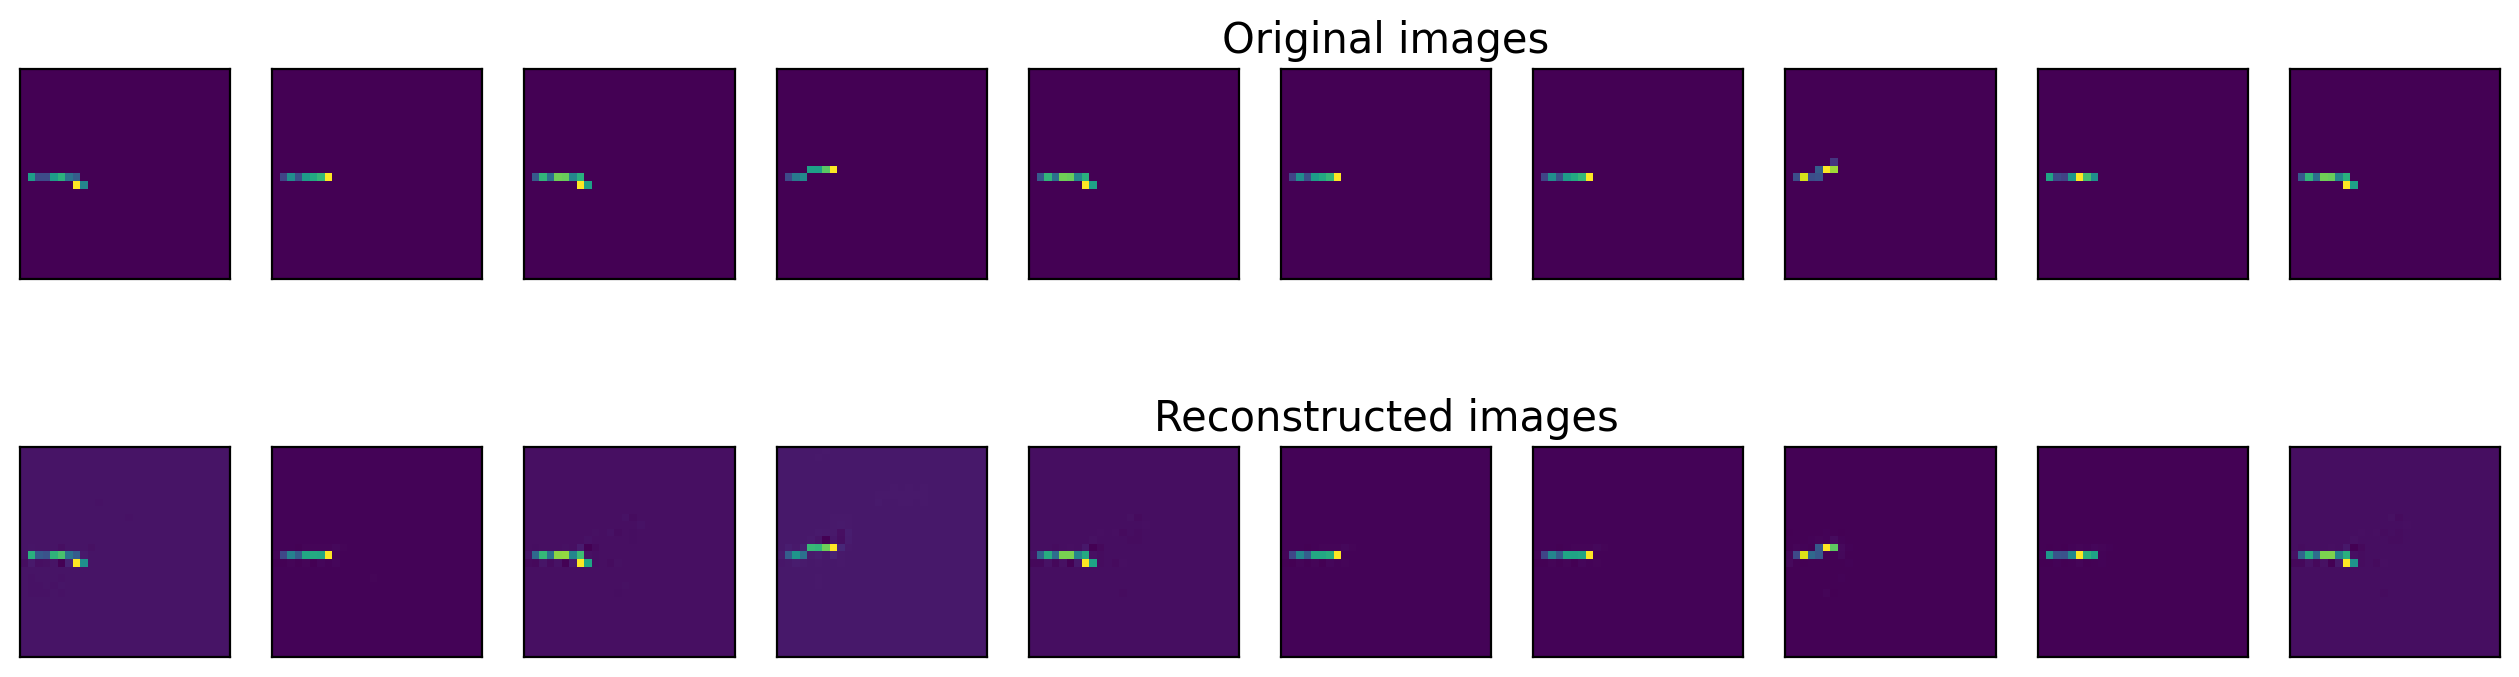


 EPOCH 1001/2500 	 train loss 64.951 	 val loss 0.000


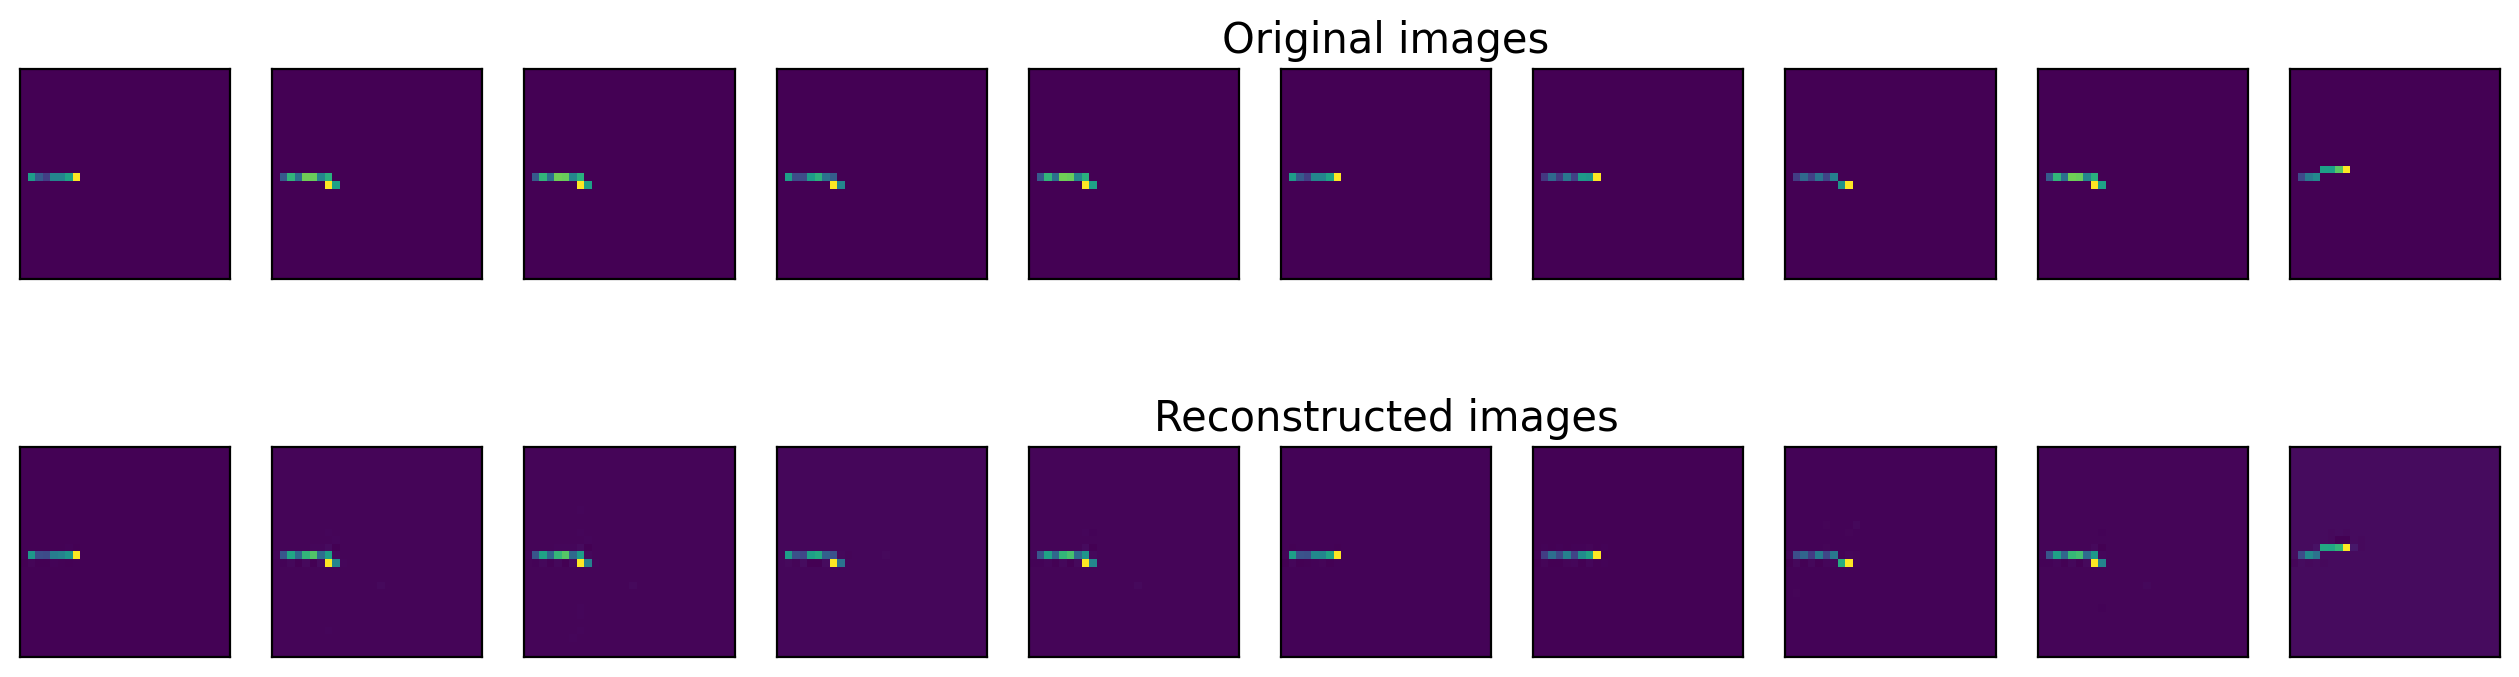


 EPOCH 1501/2500 	 train loss 56.023 	 val loss 0.000


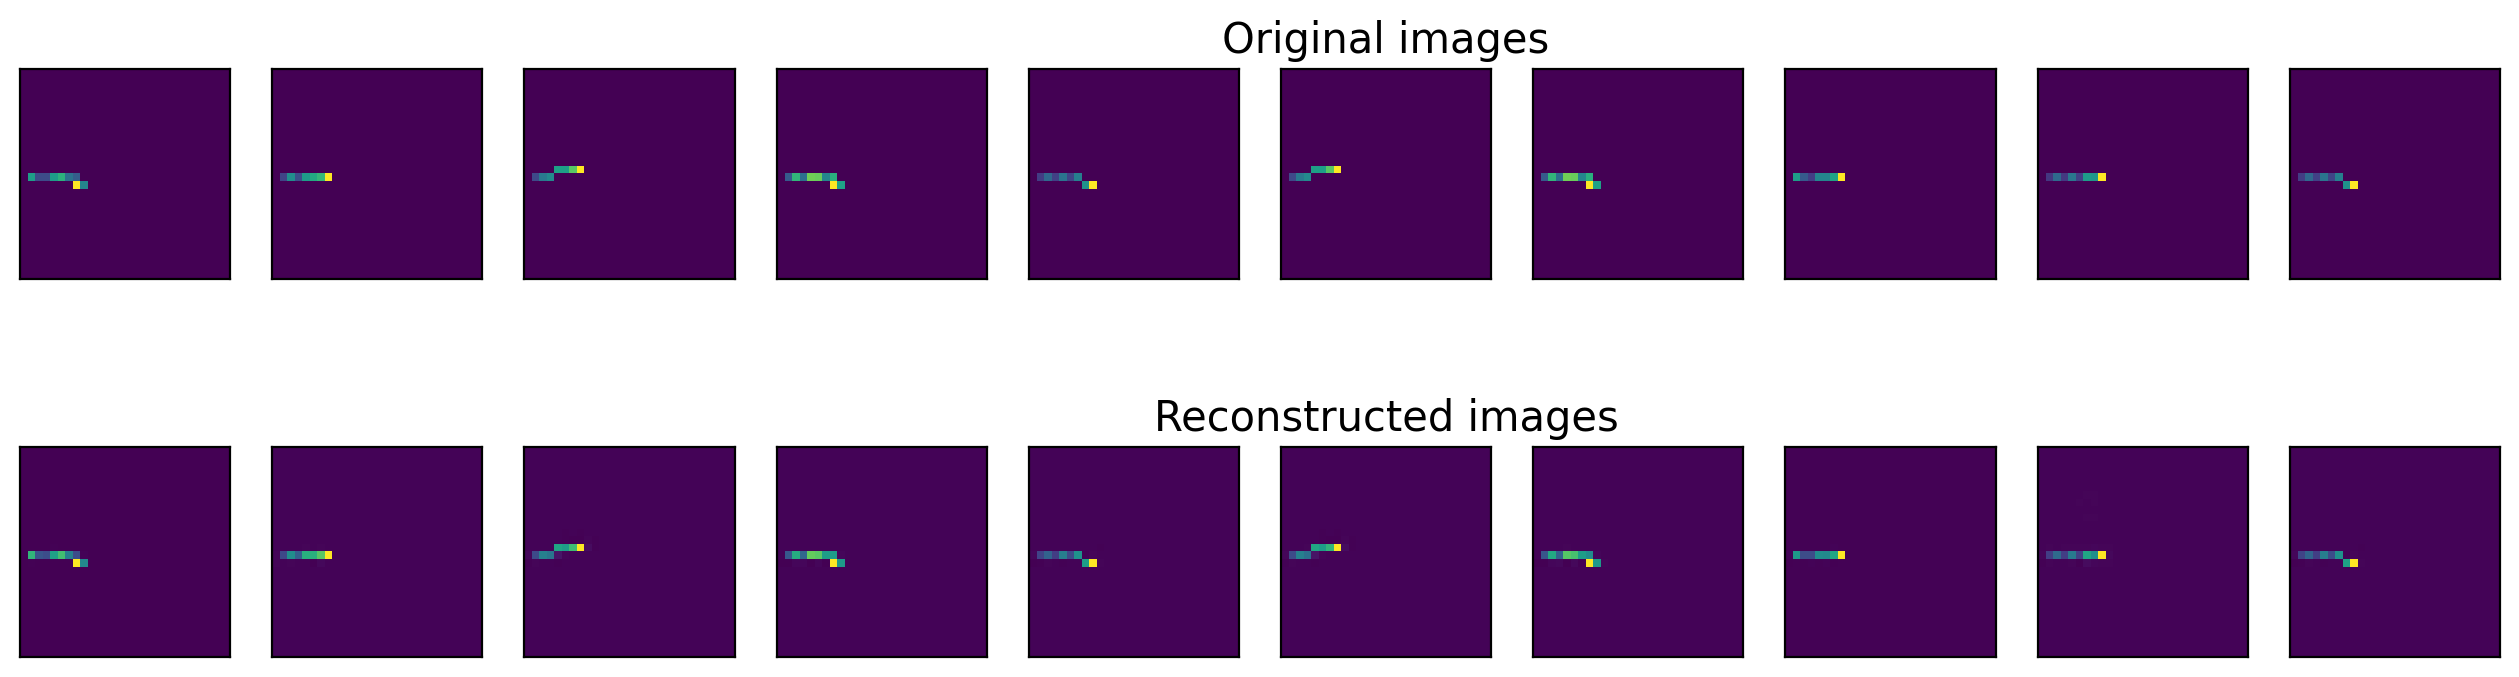


 EPOCH 2001/2500 	 train loss 51.958 	 val loss 0.000


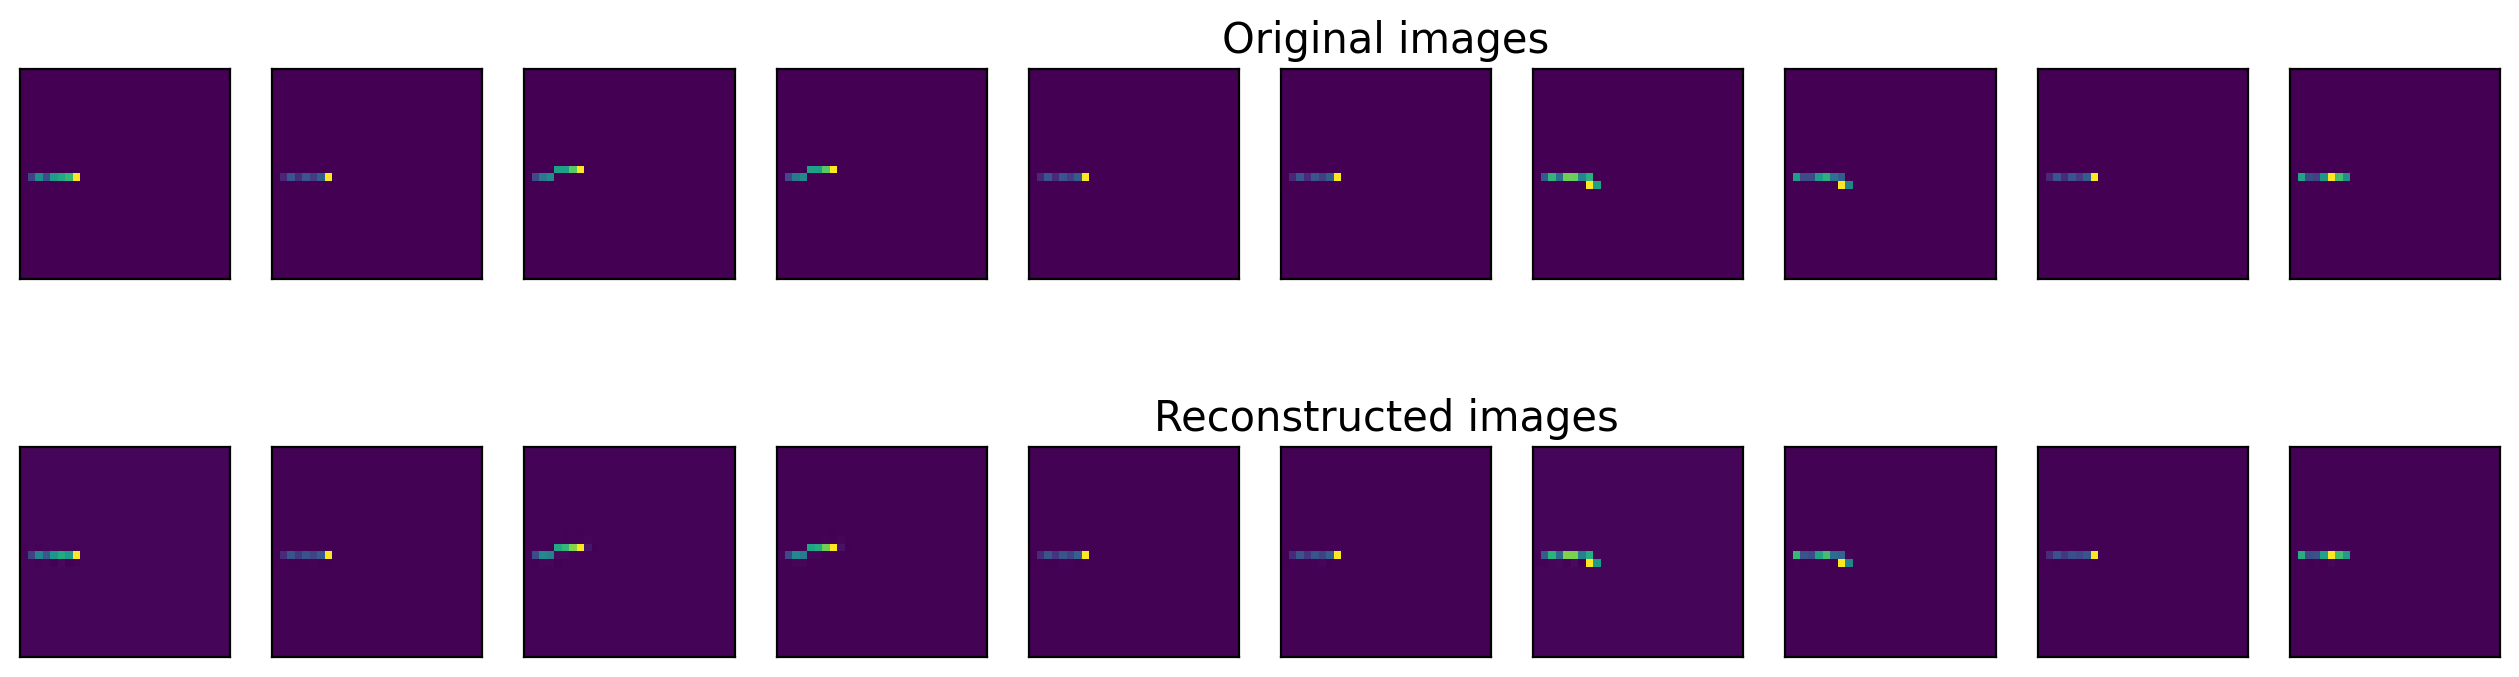

final loss 45.9611171875


In [74]:
#>>>RUN: L21.3-runcell04

#Note: this will take some time

num_epochs = 2500

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss=0
    if epoch % 500 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,vae,n=10)


print("final loss", train_loss)

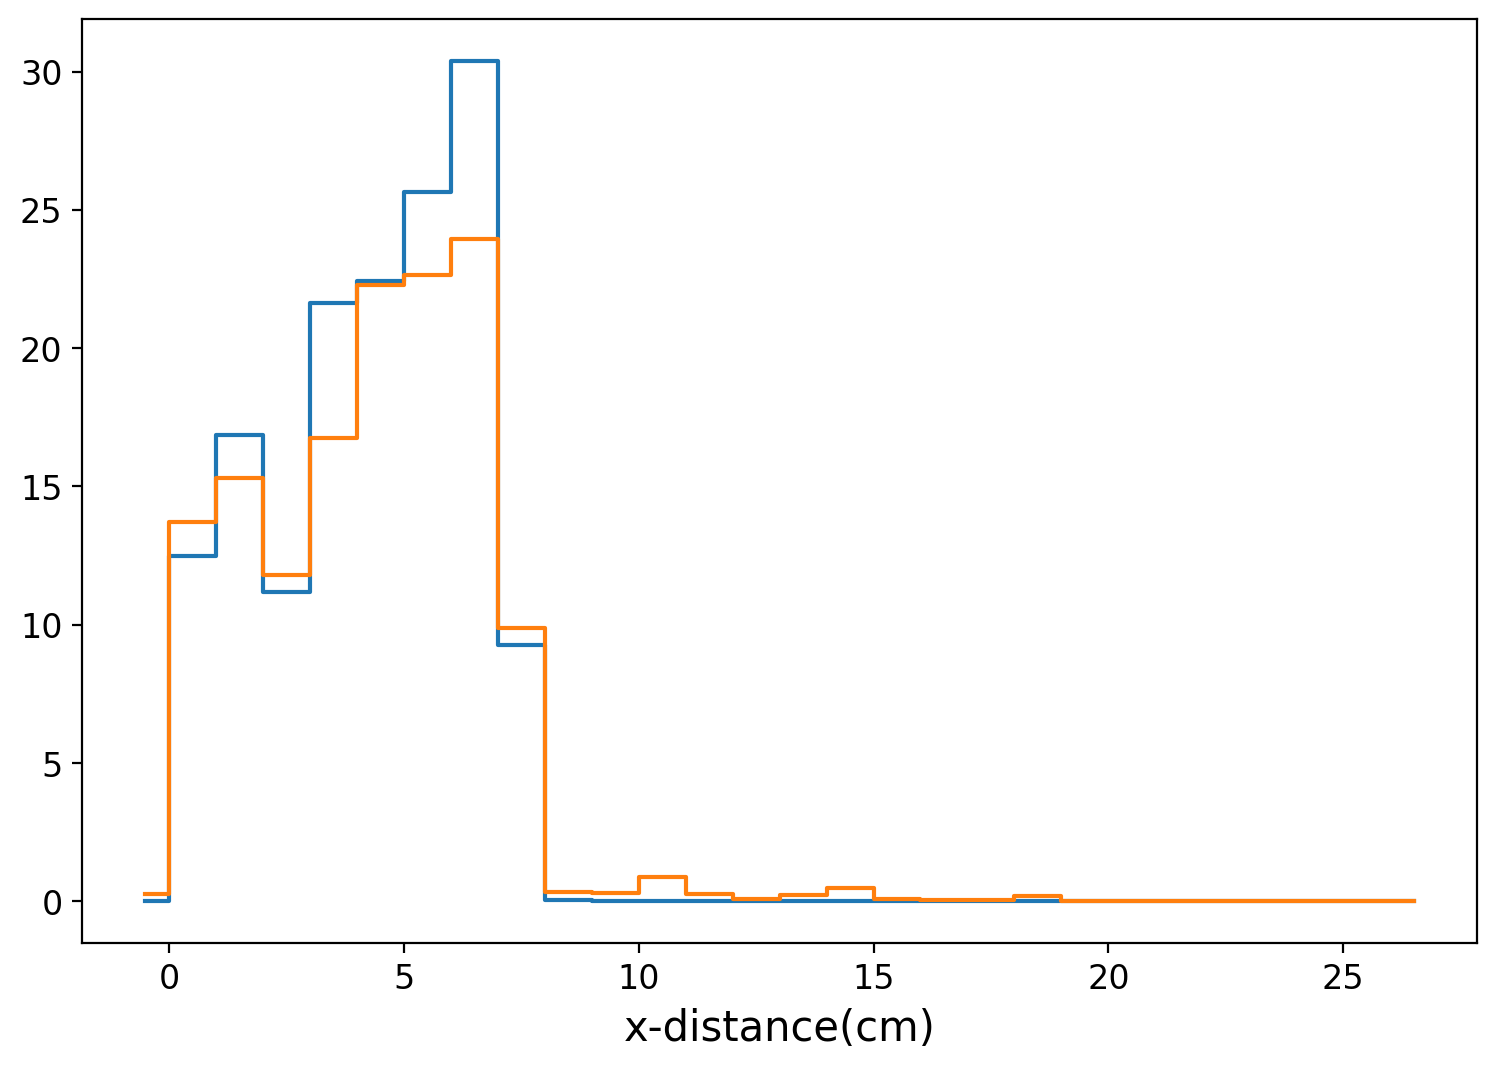

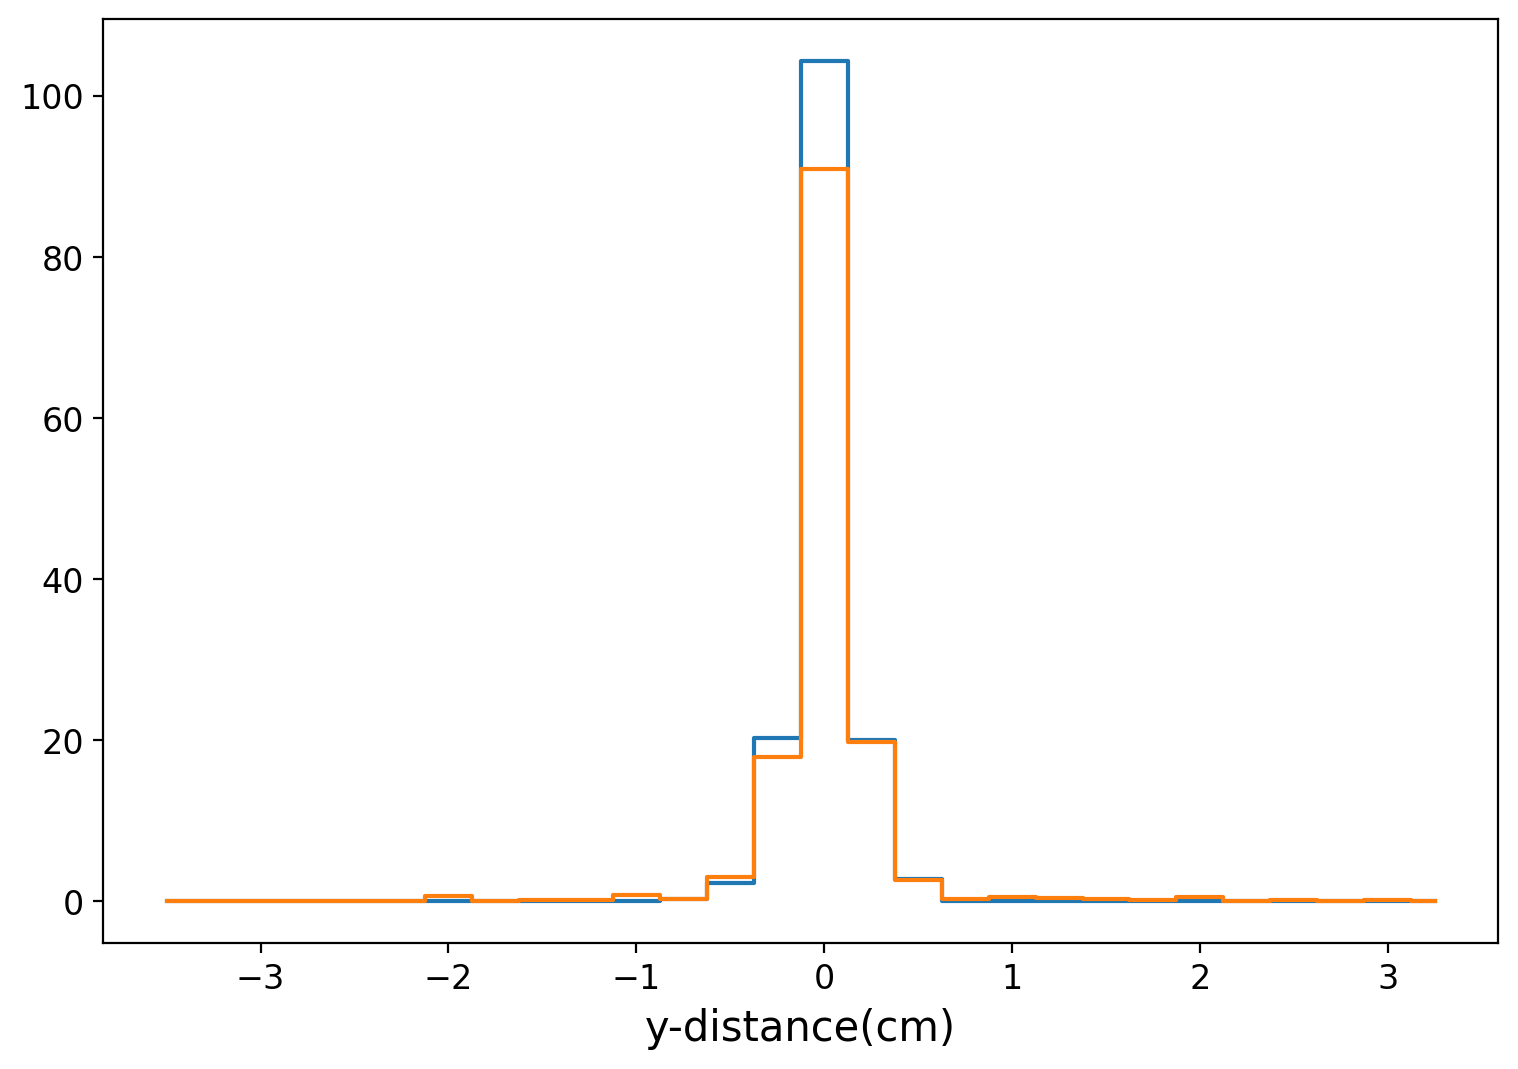

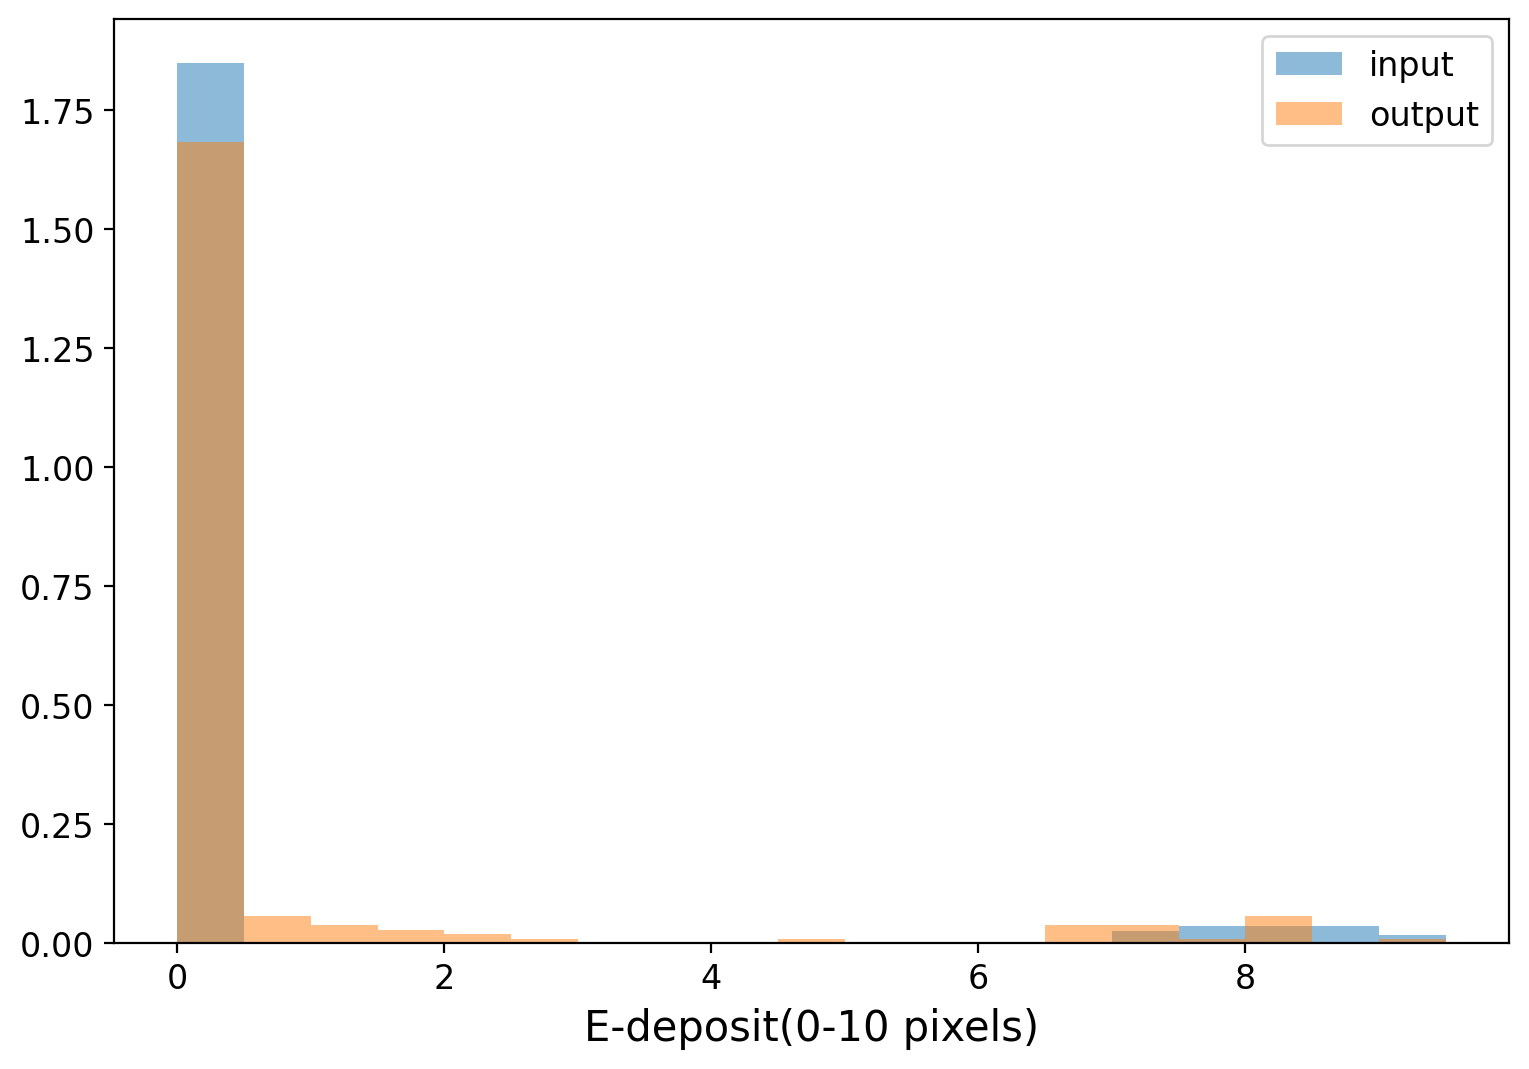

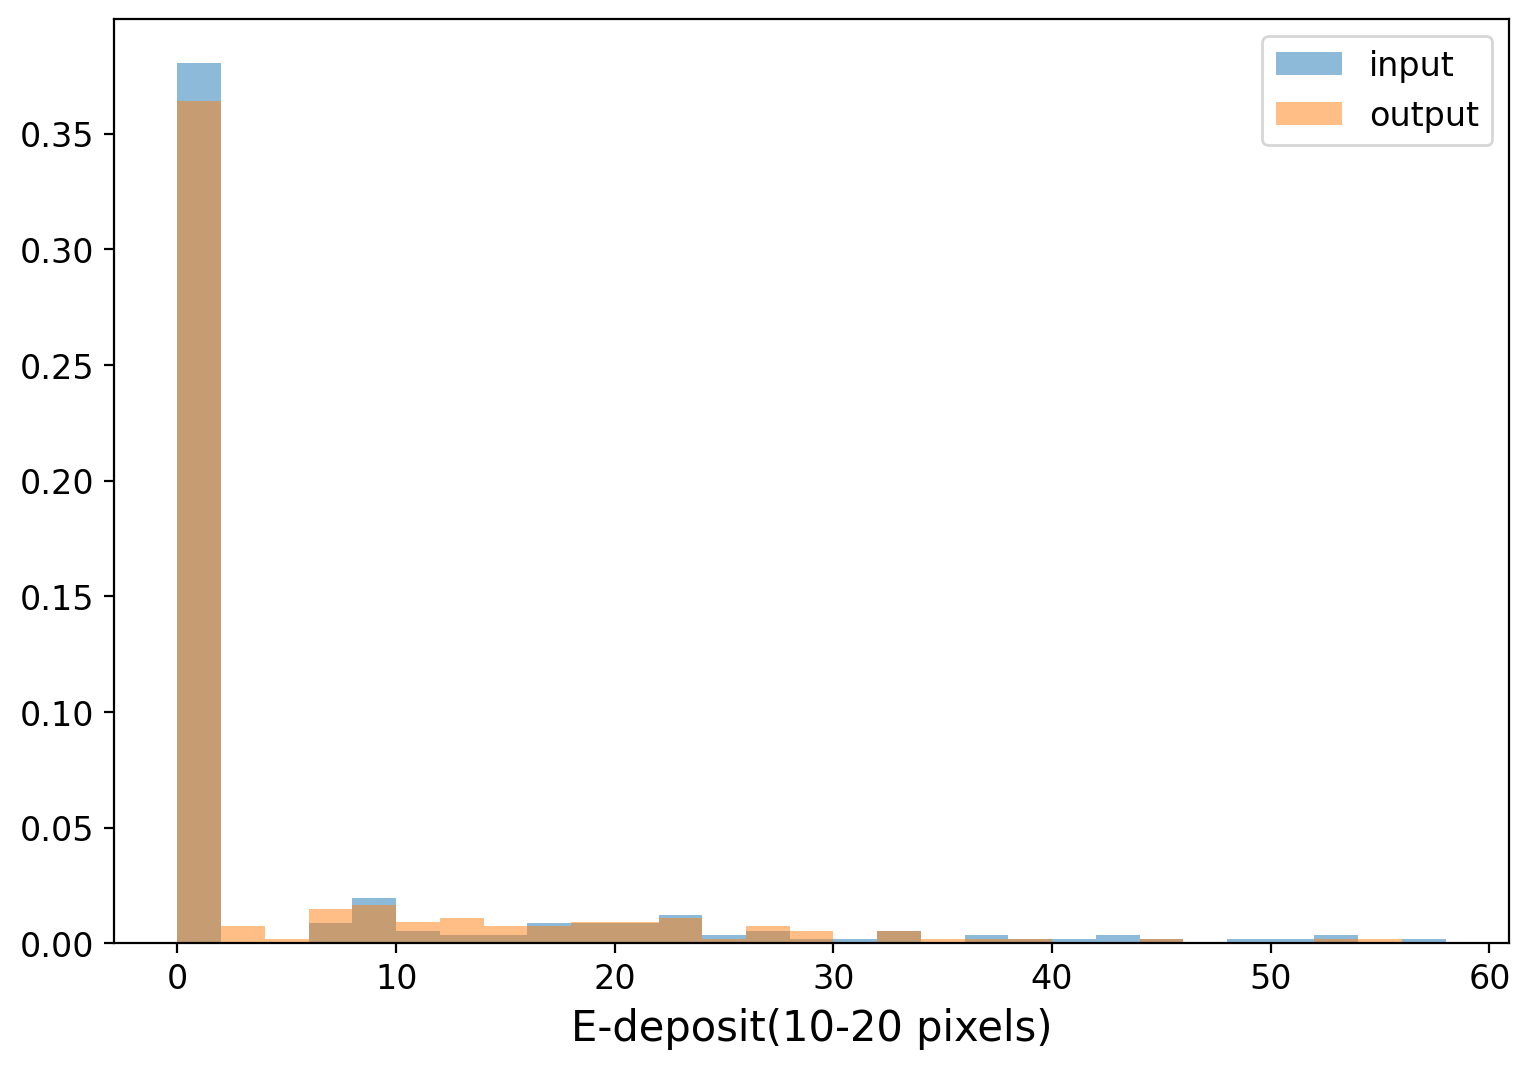

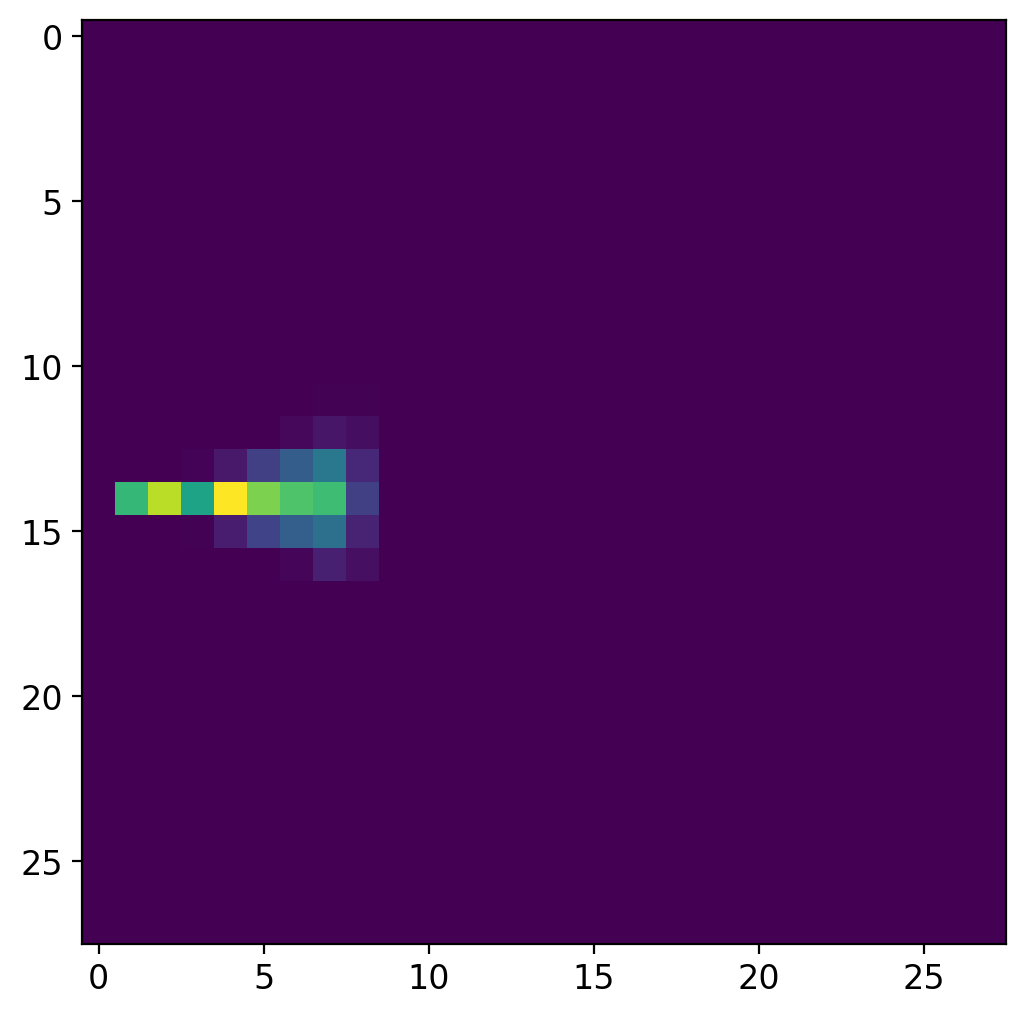

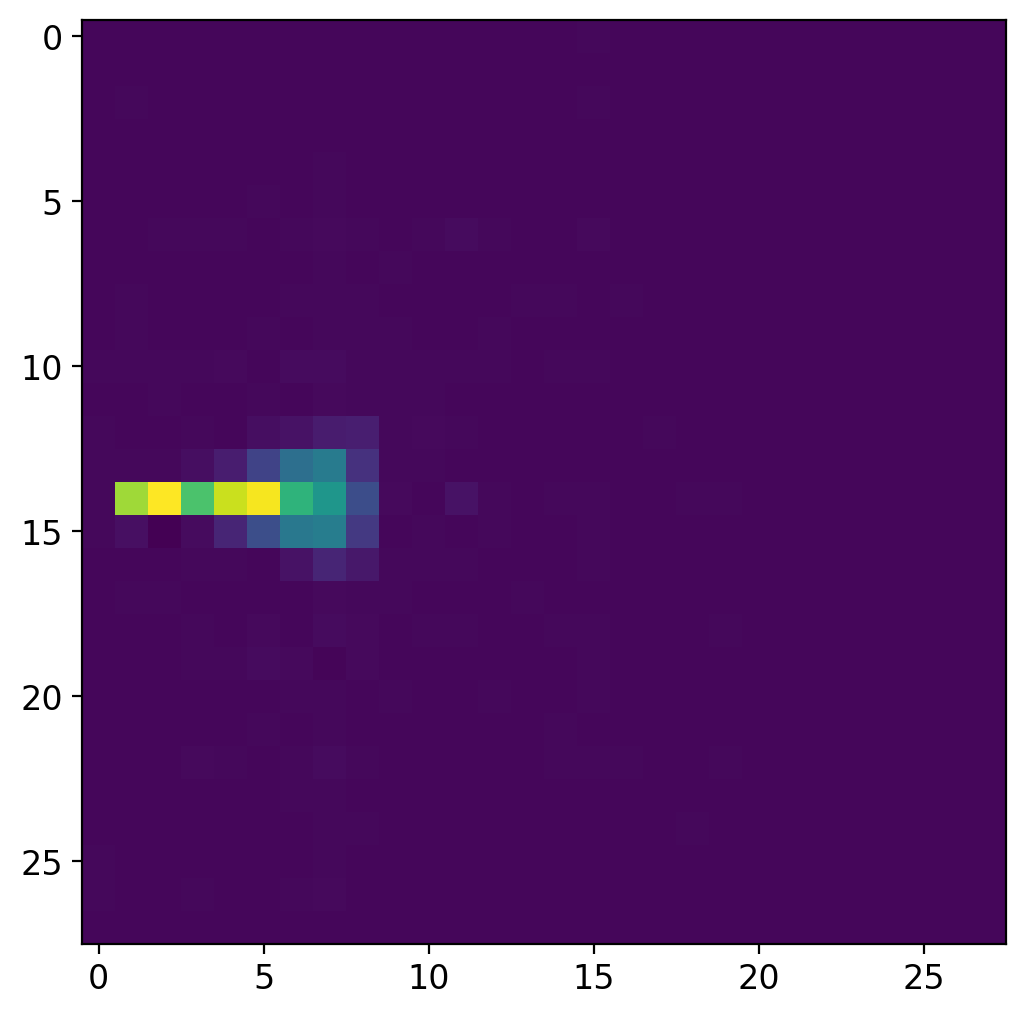

In [75]:
#>>>RUN: L21.3-runcell05

def plotVAEImageOutputs(iLatentDim,iDataSet):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    rec_img  = vae.decoder(testlatent)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.show()


    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,10,0.5)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.xlabel("E-deposit(0-10 pixels)")
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[10:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[10:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.xlabel("E-deposit(10-20 pixels)")
    plt.show()

    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

#dimage150_avg = np.mean(dimage150,axis=0)
#plt.imshow(dimage150_avg[0])
#plt.show()
#dimage150_tmp = np.mean(dimage150,axis=0)
#plt.imshow(dimage150[0][0])
#plt.show()
#test=np.mean(np.sum(dimage150,axis=3),axis=0)
plotVAEImageOutputs(d,dimage150)
torch.save(vae.state_dict(), 'data/L22/vae_150.pt')

Now, we can see that we get bettet agreement for our VAE in terms of modelling the effects, when compared to just trying to model the high-level observables. However, we need to a little careful. In the previous, we were modelling high levle obserrables tha tare precise. Here we are trying to capture a quantized(pixelated) image, which we do. Really, we have taken a problem with complex inputs and outputs and replaced the training to take simple images and produced output images. While there are more inputs and outputs, the actual obserables are quite simple. We are just taking in images of particle showers, simplifying them, and reproducing hte same particle showers. The shower is a continuous object with a characteristic shape. This is much more physically meaningful than high level observable. We can explore this more in the problems below.


<a name='exercises_22_3'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_3) | [Next Section](#section_22_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.3.1</span>

As we did in the last section, let's look at the latent space. Run the code below, where we again use the `encoder_nosmear` function to output $\mu$ and $\sigma$ of the VAE latent space for each event, and then make a corner plot. Does it look more regular than before?

What are the mus and sigmas for all 4 dimensions? Report the values as a list of numbers `[mu1,mu2,mu3,mu4,sigma1,sigma2,sigma3,sigma4]` with precision `1e-2`. Again, since it may be the case that your code defines the `mu` values oppositely from us (the order is arbitraty), let's explicitly define the `mu` values with `mu1` as the smallest, in ascending order. Note some `mu` values could be negative, so they should occur first in your list!

<br>

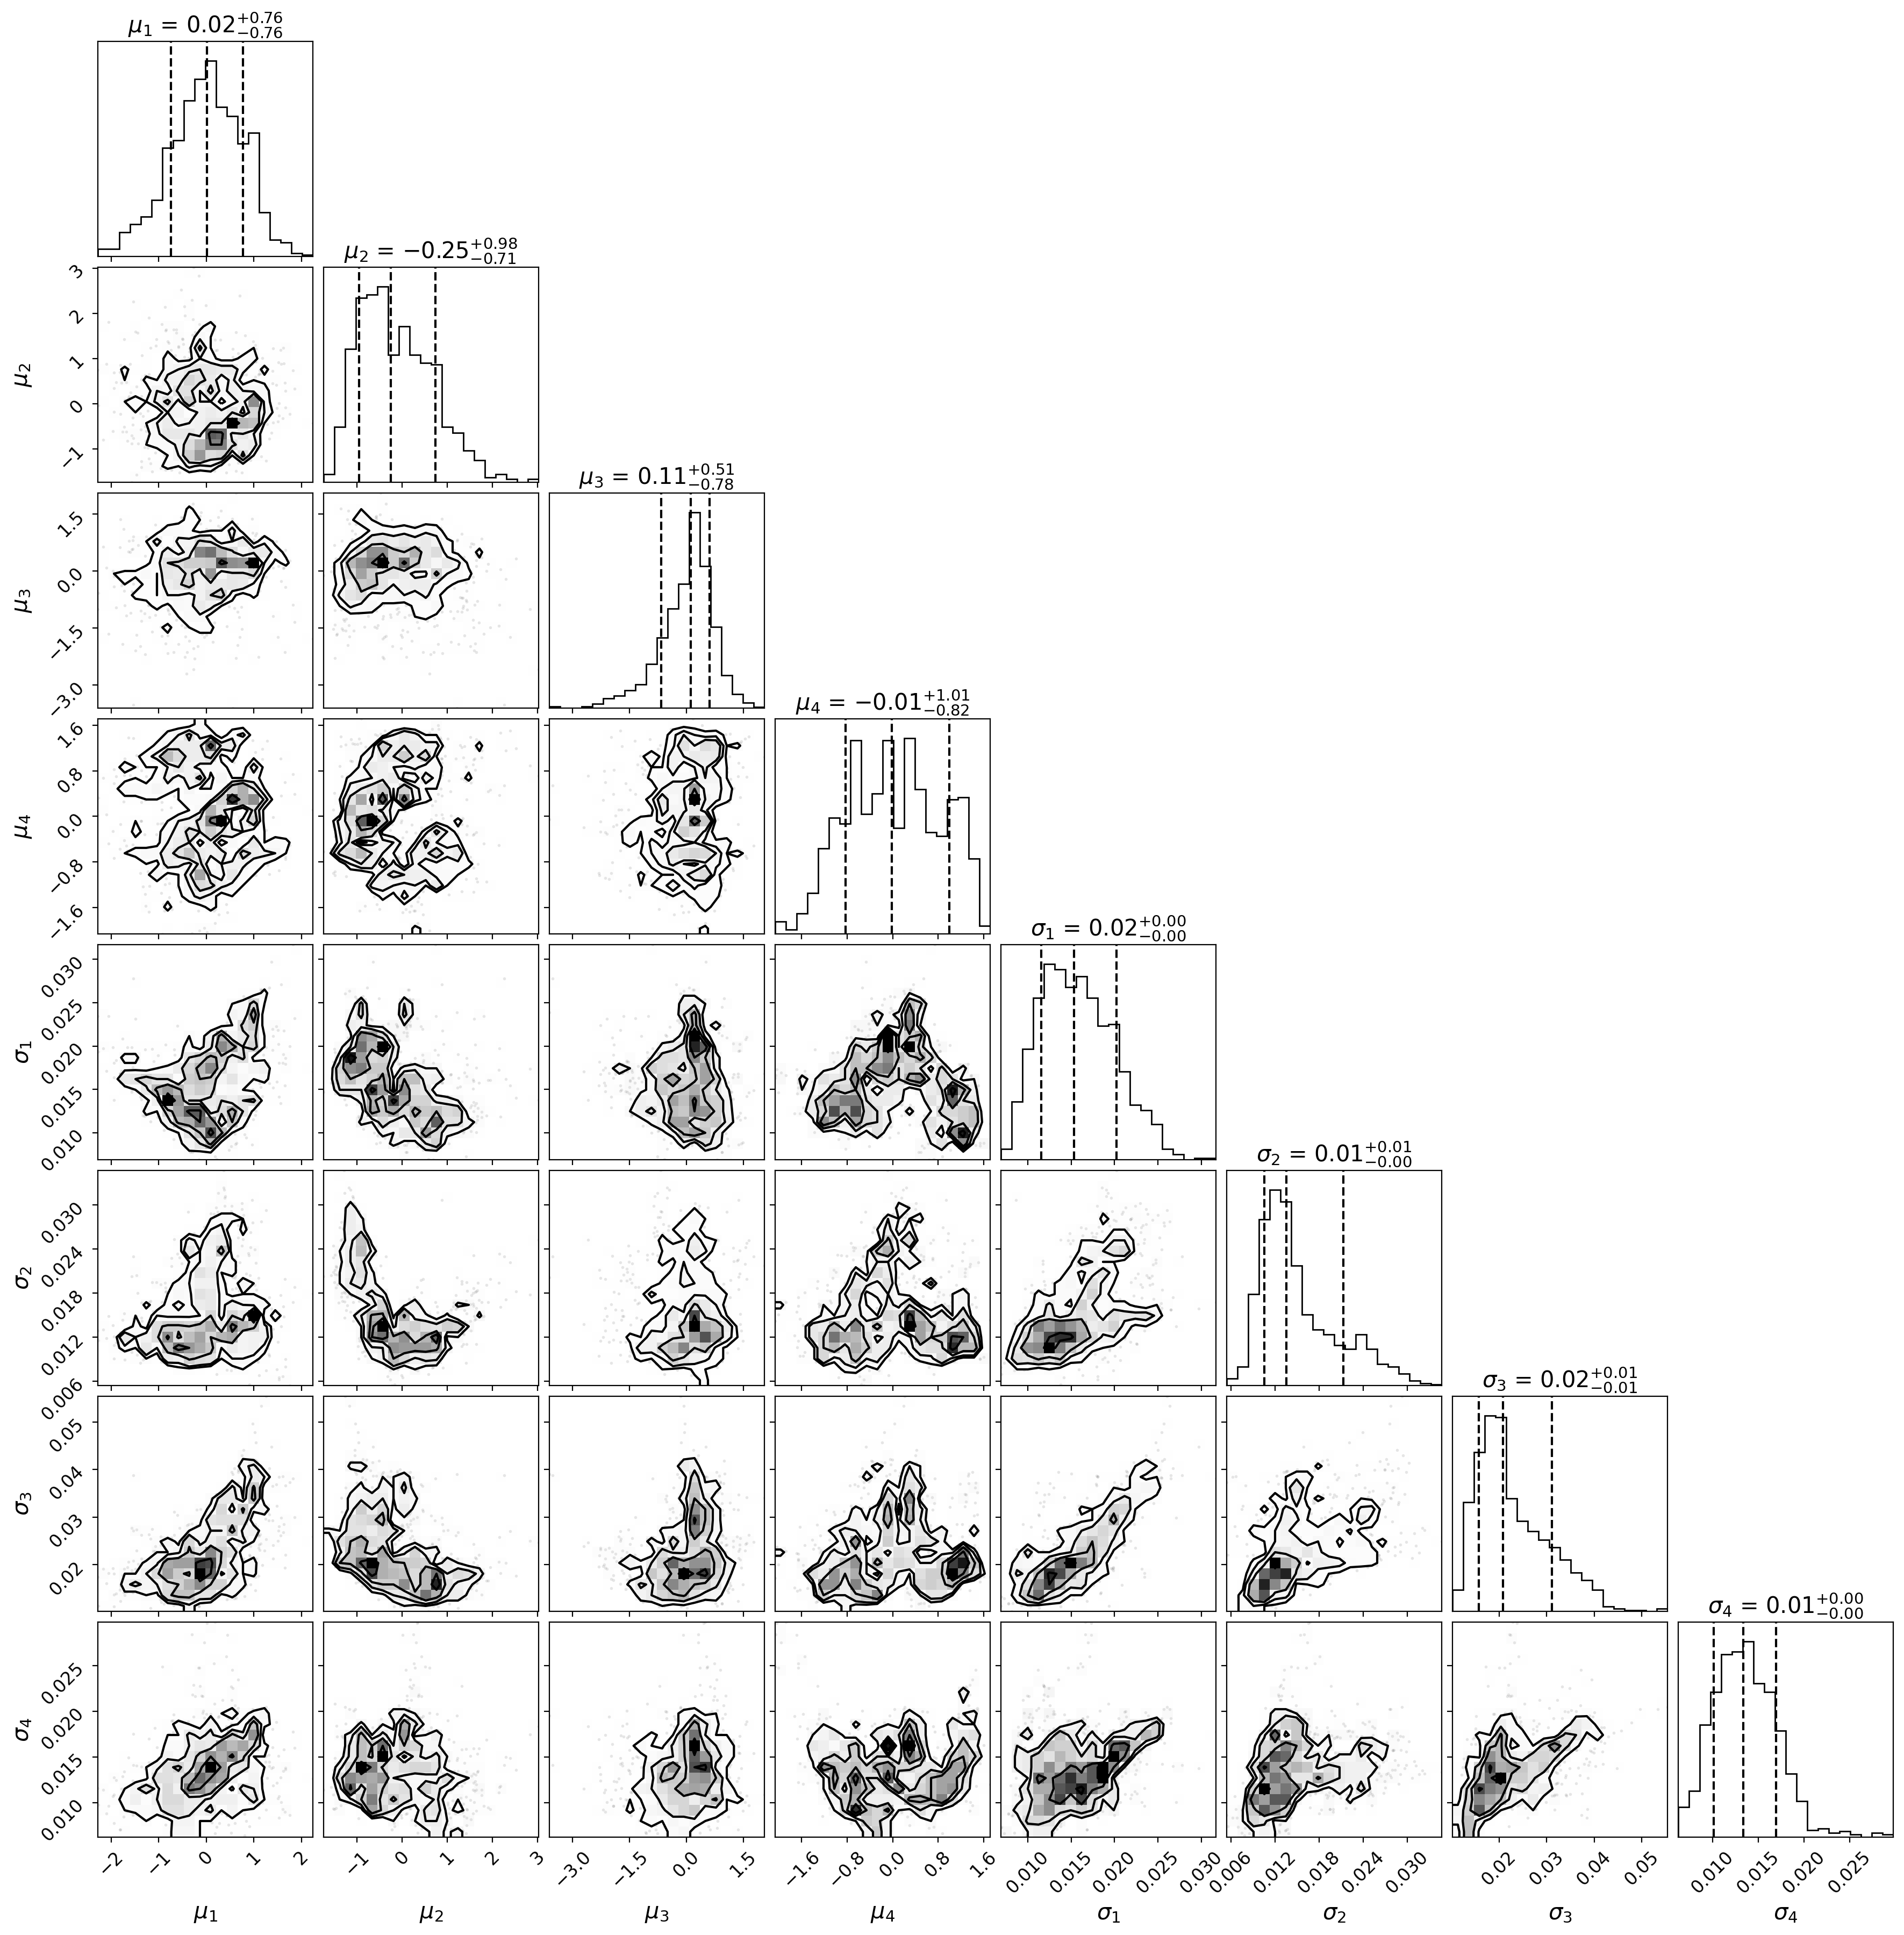

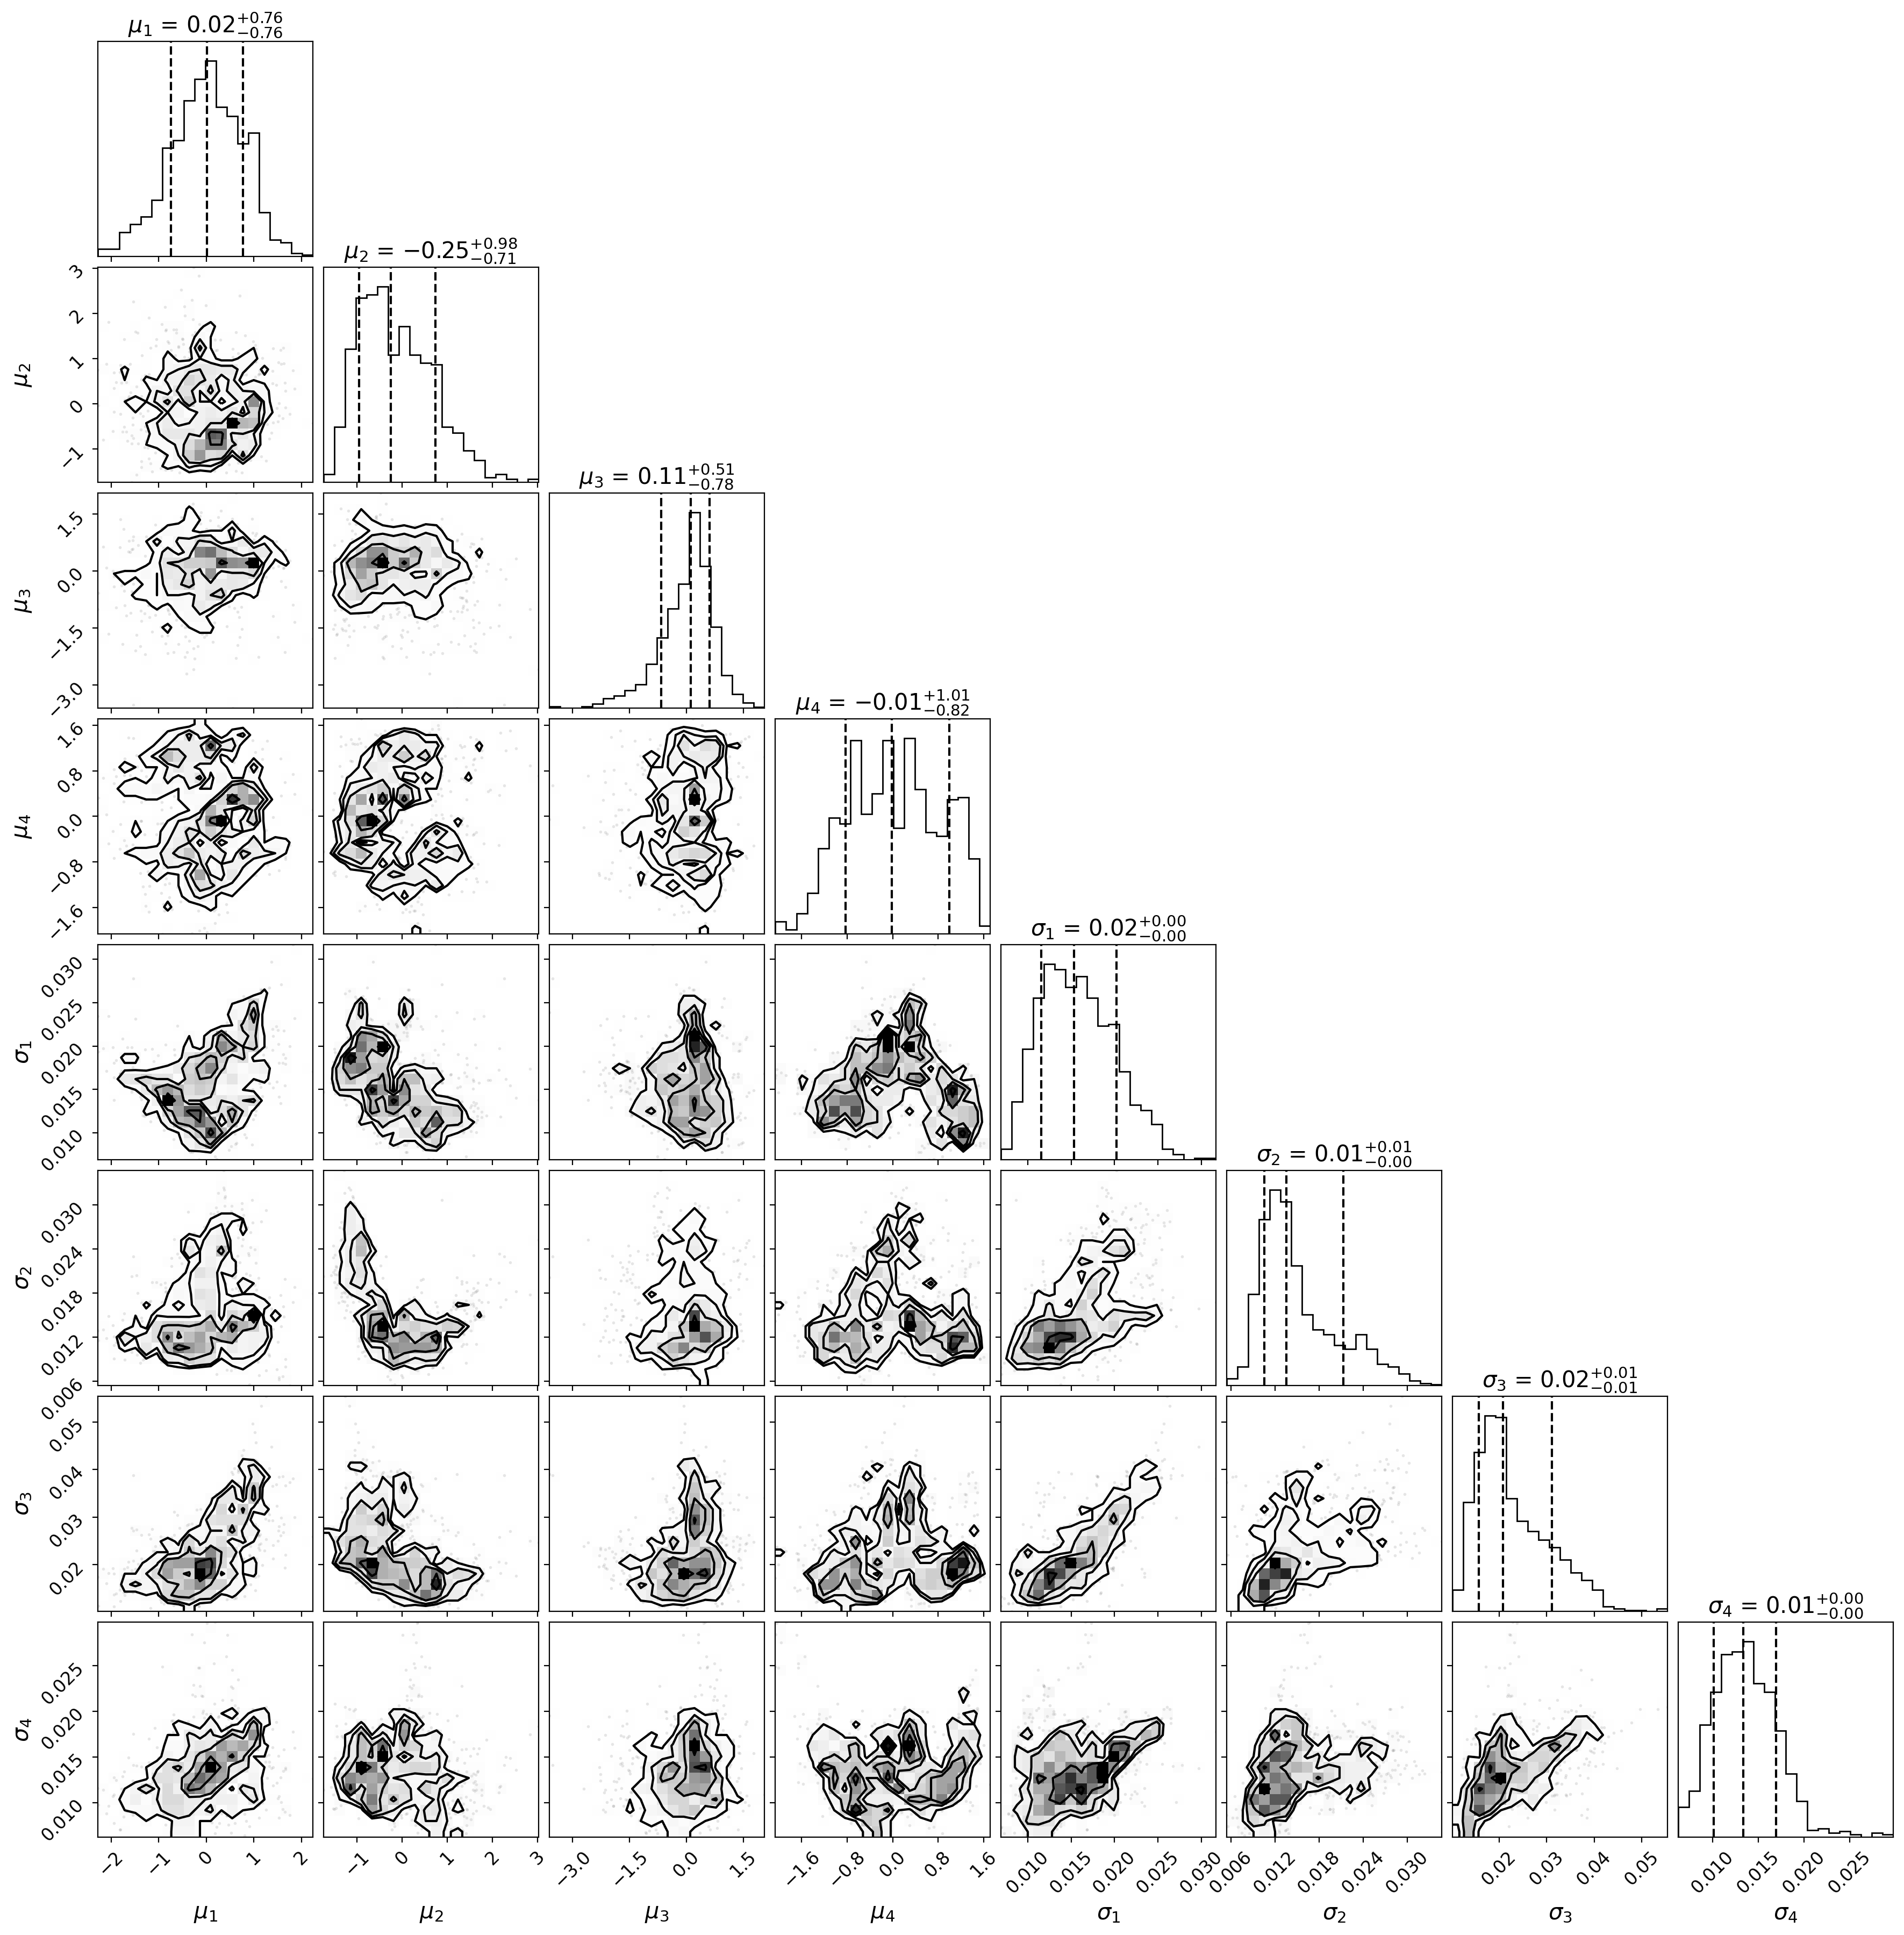

In [76]:
#>>>EXERCISE: L21.3.1

mu,sigma=vae.encoder_nosmear(torch.tensor(dimage150).float())
allvars=np.hstack((mu.detach().numpy(),sigma.detach().numpy()))
corner.corner(allvars,show_titles=True,labels=['$\mu_{1}$','$\mu_{2}$','$\mu_{3}$','$\mu_{4}$','$\sigma_{1}$','$\sigma_{2}$','$\sigma_{3}$','$\sigma_{4}$'],plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 22.3.2</span>

Again, lets generate events off the latent space found from our encoder. Run the code below, where we have given it the $\mu$ and $\sigma$ values found above, and compare the inputs and outputs of the VAE for various characteristics.

Does the agreement between inputs and outputs improve, compared to the results of cell `L21.3-runcell05`?

A) Yes\
B) No\
C) Maybe?


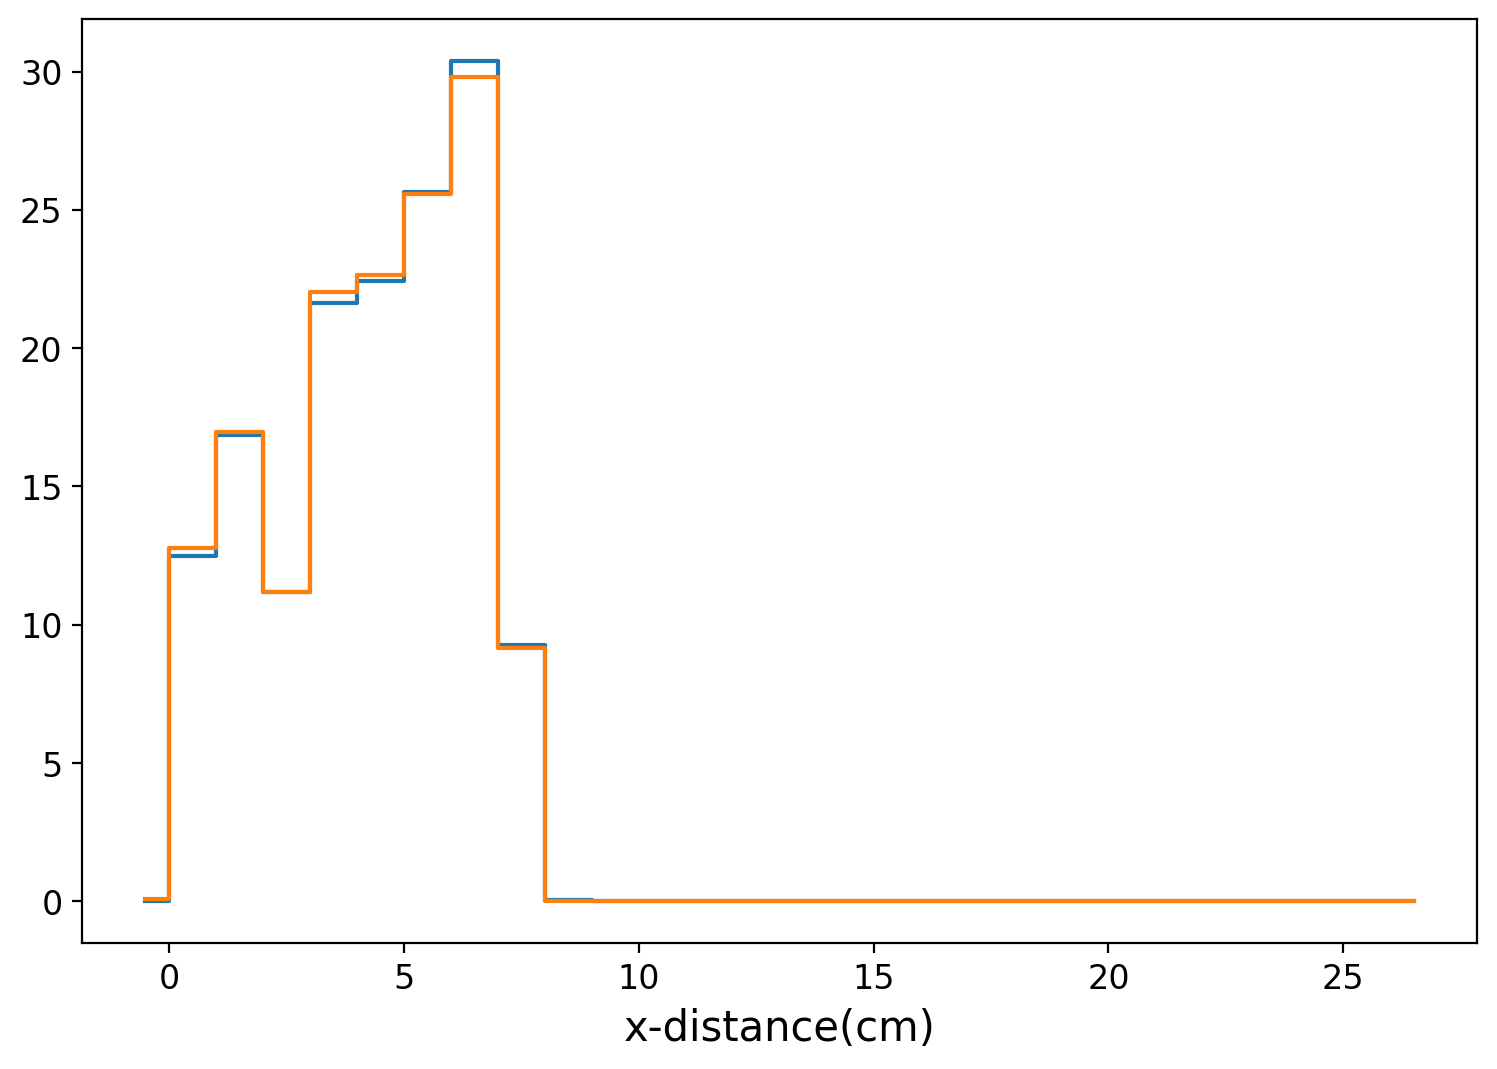

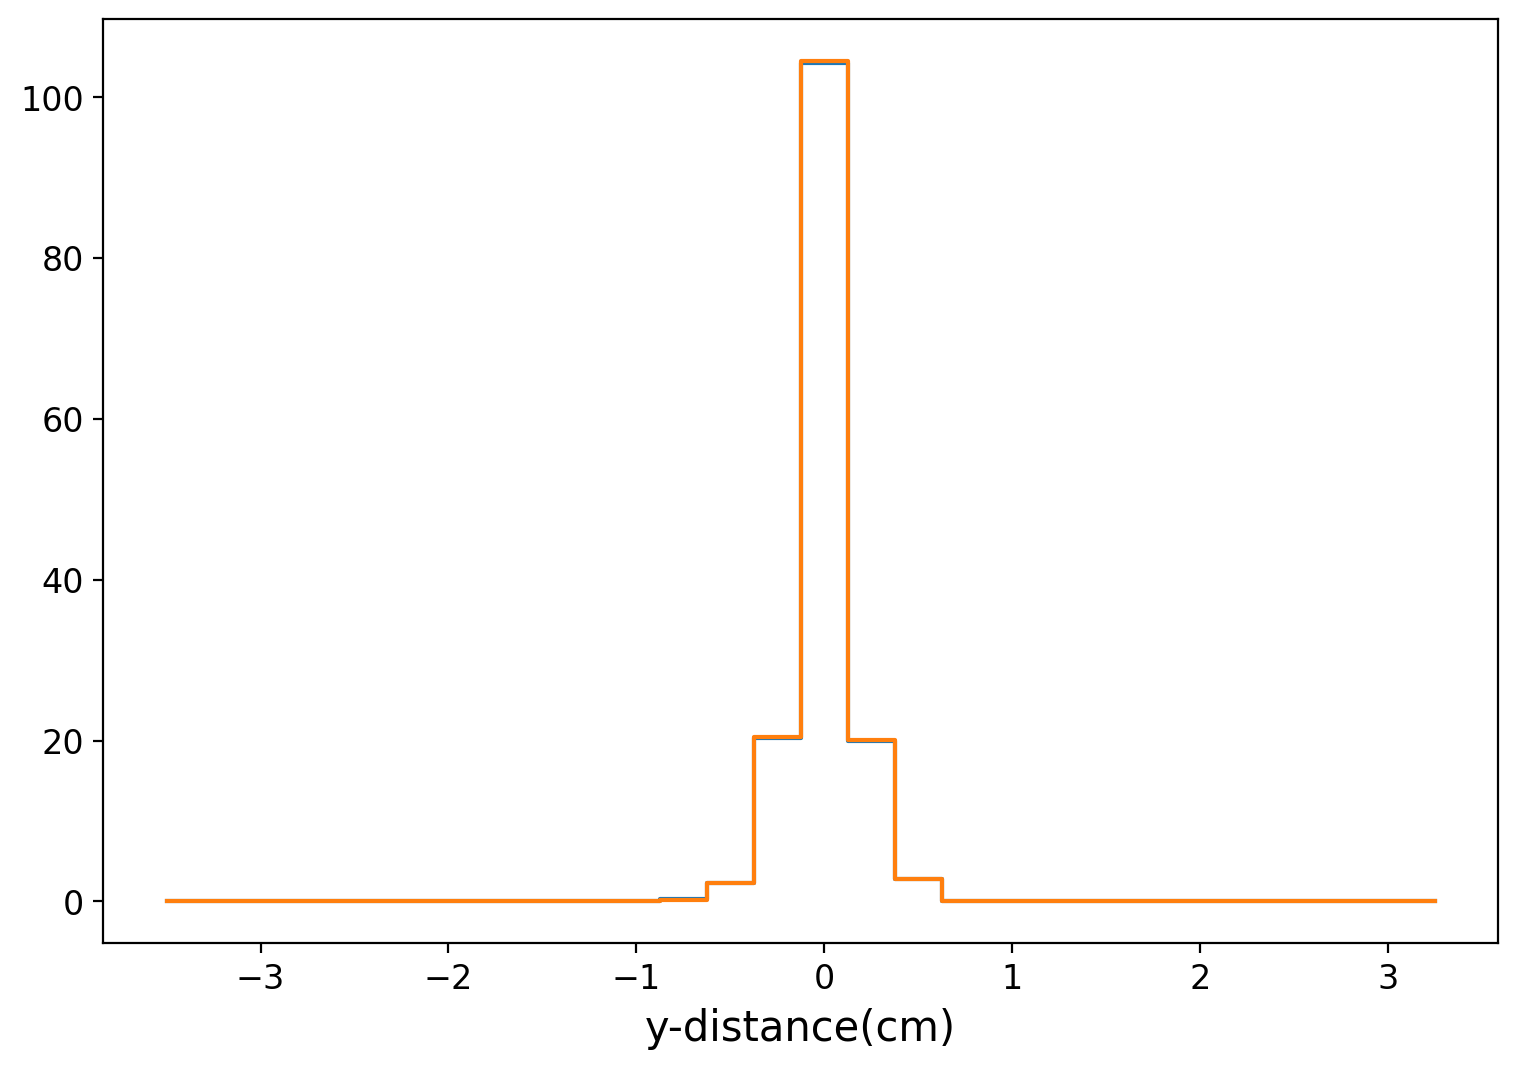

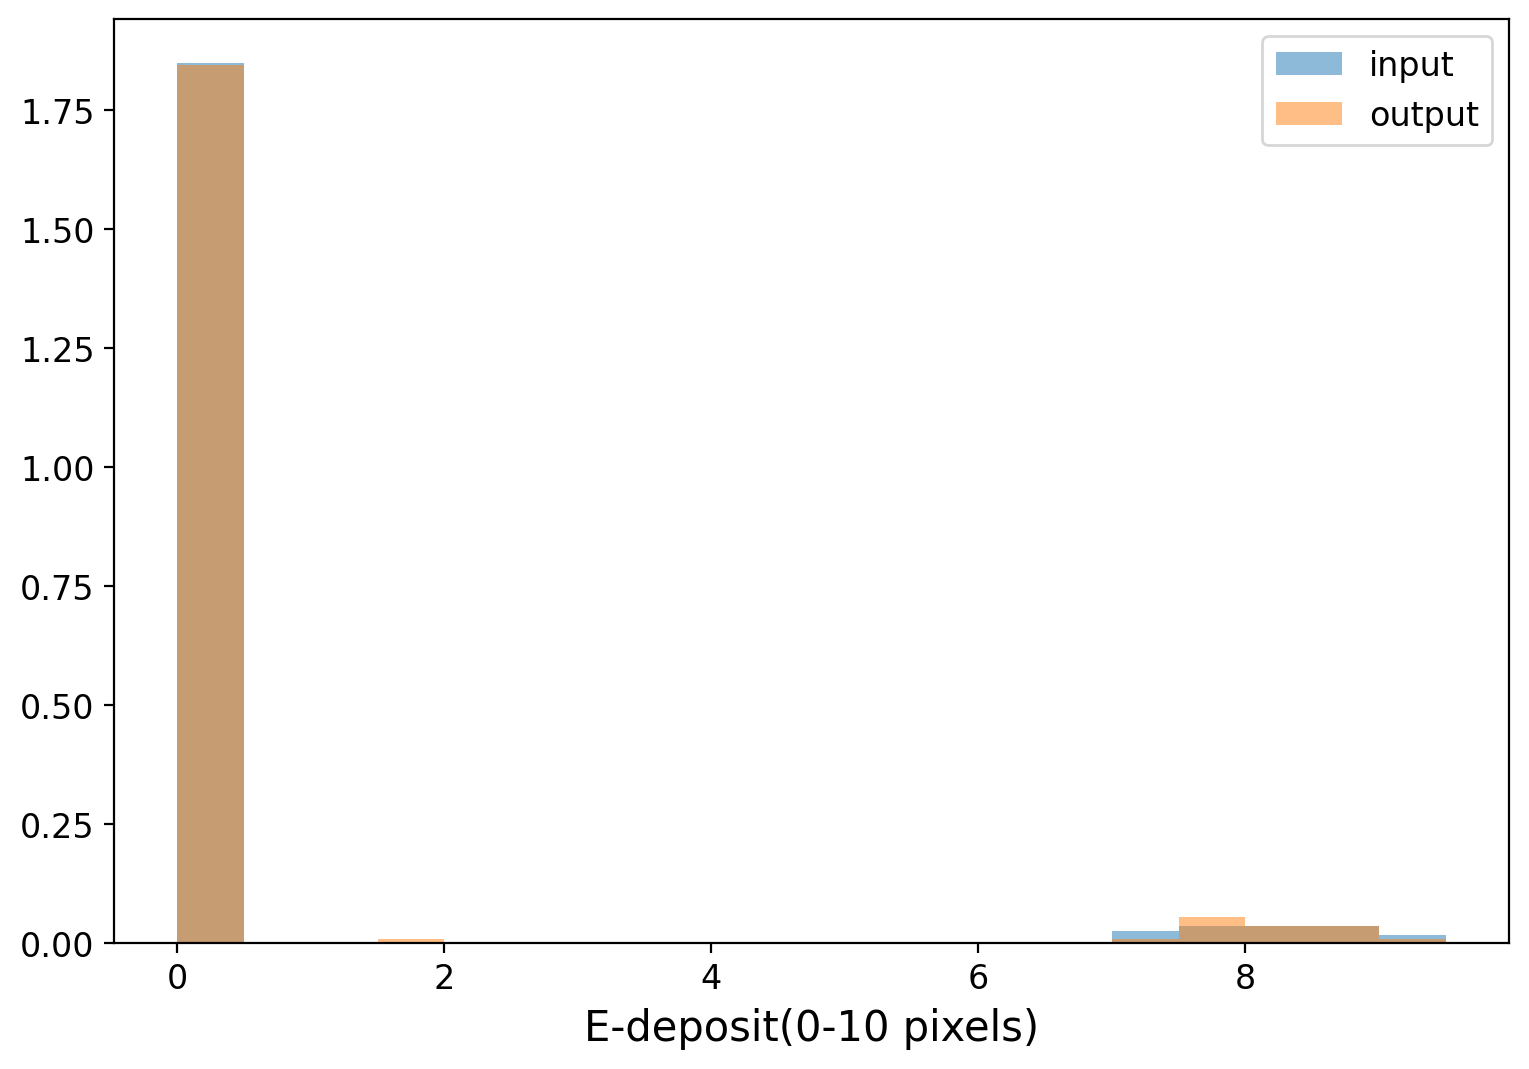

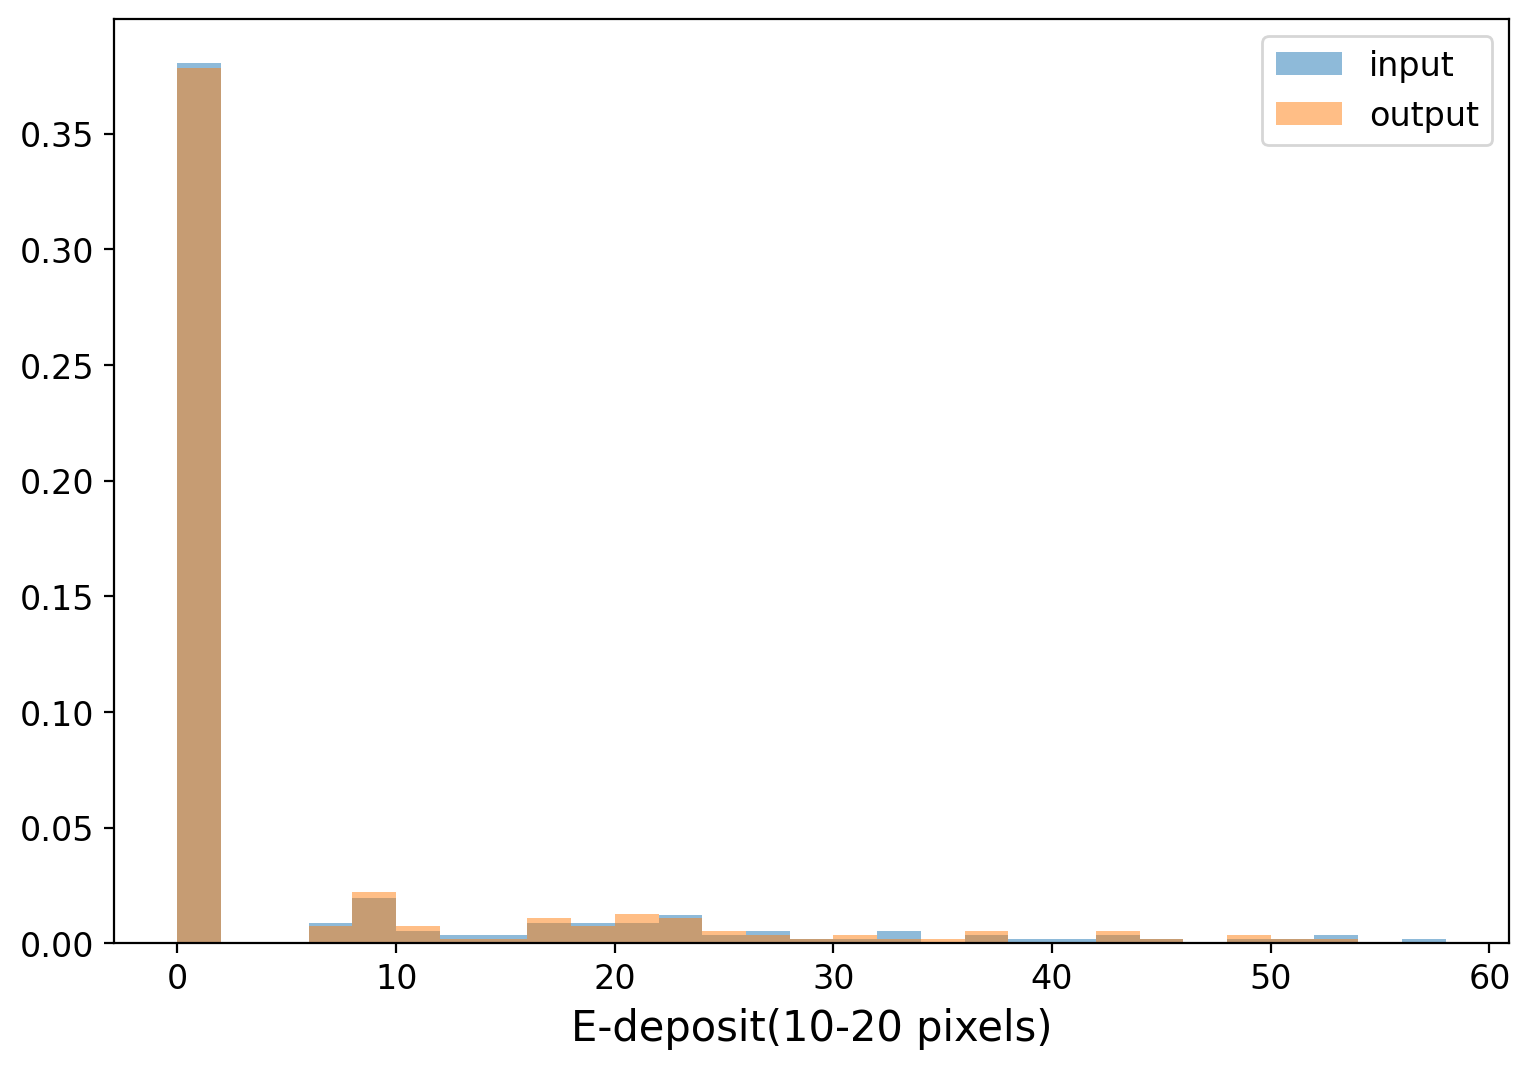

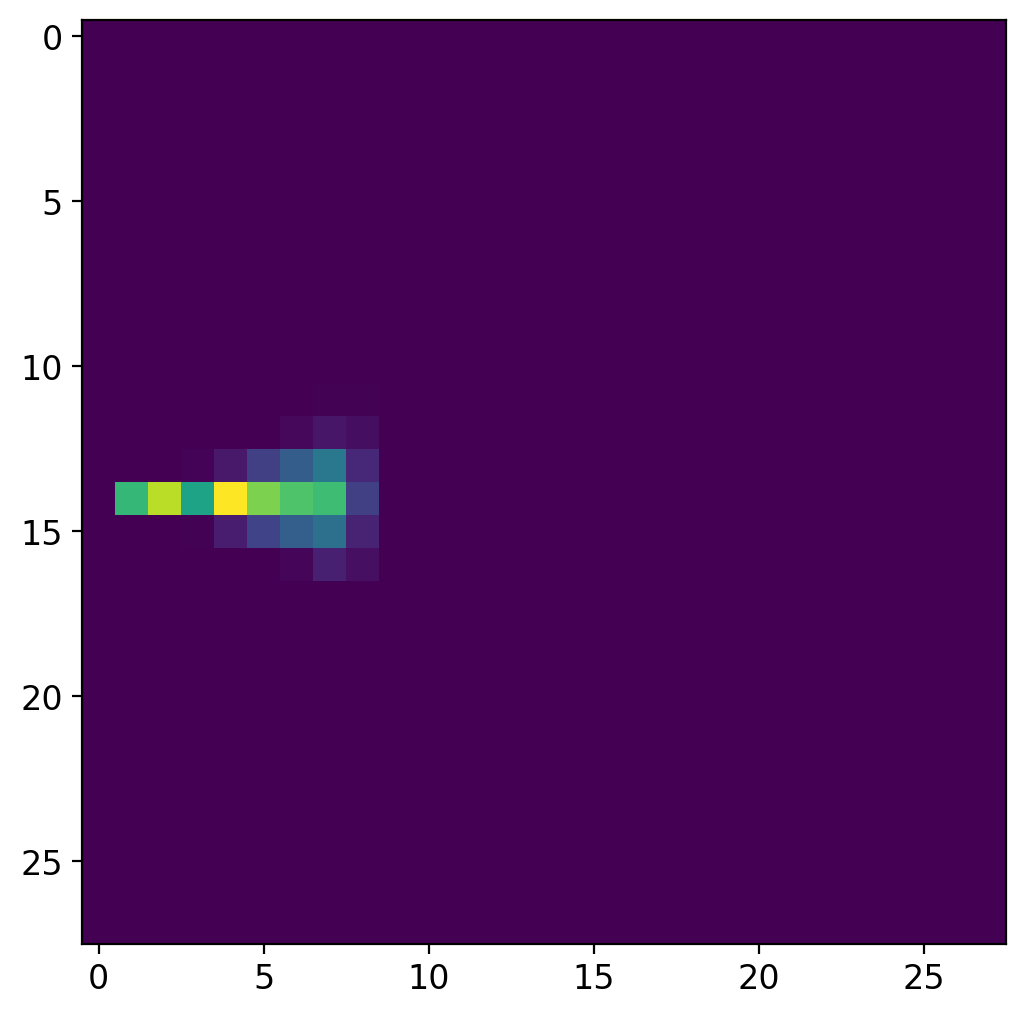

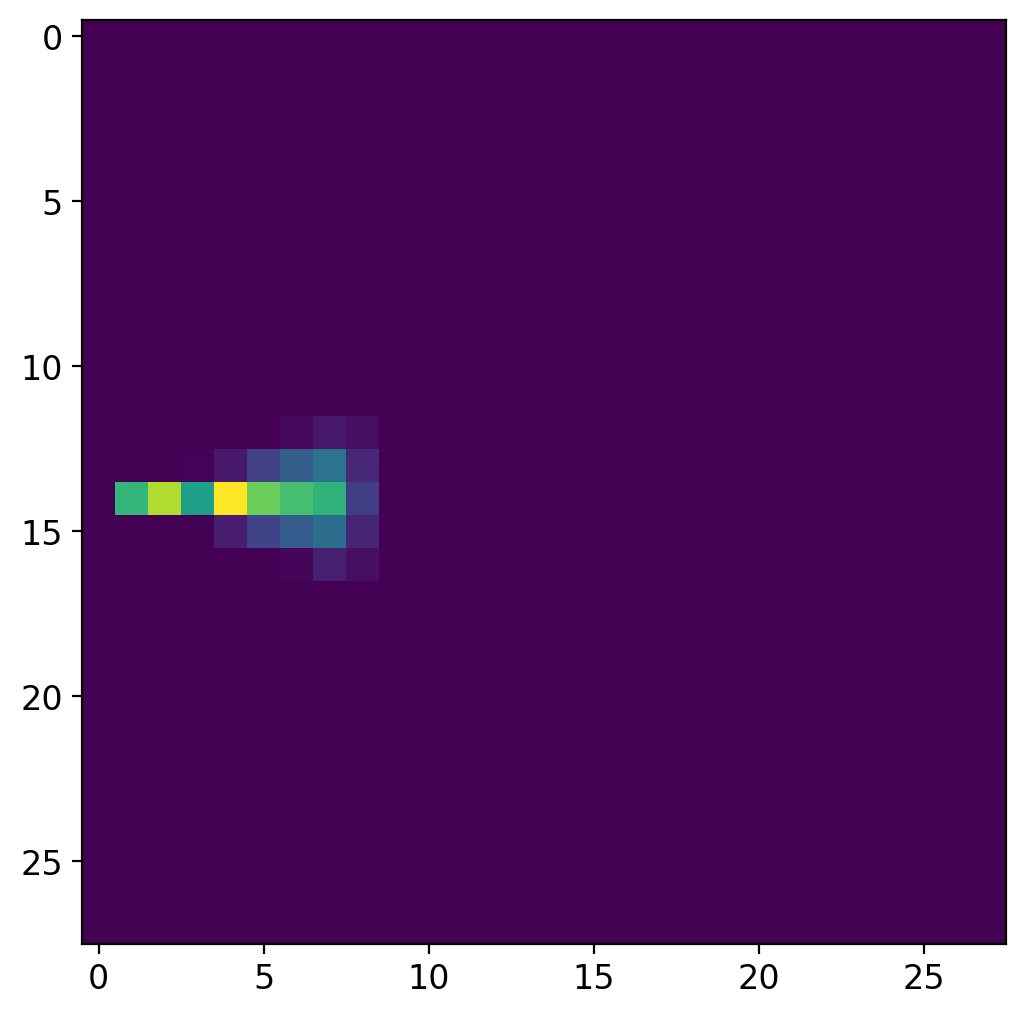

In [77]:
#>>>EXERCISE: L21.3.2

def plotVAEImageOutputs_real(iMu,iSigma,iLatentDim,iDataSet):
    testlatent=torch.randn(iMu.shape)
    testlatent=testlatent*iSigma+iMu
    rec_img  = vae.decoder(testlatent)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.show()


    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,10,0.5)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.xlabel("E-deposit(0-10 pixels)")
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[10:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[10:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.xlabel("E-deposit(10-20 pixels)")
    plt.show()

    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

mu,sigma=vae.encoder_nosmear(torch.tensor(dimage150).float())
plotVAEImageOutputs_real(mu,sigma,d,dimage150)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.3.3</span>

Now, let's generate similar plots at another energy. Try repeating the training procedure in this section using the `dimage300` dataset. What qualitative differences do you observe? Select ALL options that apply:


A) The tracks are spread out more spatially.\
B) The VAE has a higher loss.\
C) The VAE does a comparable job at matching the histograms compared to the case with the 150 Mev dataset.


Ultimately, we do not want to be required to create a new simulation for every energy. Rather, we want to condition the output of the decoder on the energy that is given. We will discuss this in the next section!

<br>

<a name='section_22_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.4 Conditional VAEs allowing for energy based generation </h2>  



| [Top](#section_22_0) | [Previous Section](#section_22_3) | [Exercises](#exercises_22_4) | [Next Section](#section_22_5) |

In [78]:
#>>>RUN: L21.4-runcell01

class CondVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(CondVariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1  = nn.Linear(3*3*32, 64)
        self.linear1a = nn.Linear(64, 8)
        self.linear1b = nn.Linear(9,  8)
        self.linear2 = nn.Linear(8, latent_dims)
        self.linear3 = nn.Linear(8, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims+1, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x, c): #c is our condition
        x = F.relu(self.conv1(x))
        #x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear1a(x))
        x = torch.hstack((x,c))
        x = F.relu(self.linear1b(x))
        mu =  self.linear2(x) #Mean in the gaussian space with the condition
        sigma = torch.exp(self.linear3(x)) #sigma in the space with the condition
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z


    def decoder(self, x, c):
        x = torch.hstack((x,c))
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


    def forward(self, x, c):
        z = self.encoder(x, c)
        return self.decoder(z, c)

torch.manual_seed(0)
d = 6
cvae_proton_image = CondVariationalAutoEncoder(latent_dims=d)
lr = 1e-2
optim = torch.optim.Adam(cvae_proton_image.parameters(), lr=lr, weight_decay=1e-5)
from torch.utils.data import ConcatDataset
megeimage=ConcatDataset([image150, image200,image250,image300])
train_loader = torch.utils.data.DataLoader(megeimage, batch_size=500)
#from torchsummary import summary
#summary(cvae_proton_image, ((1, 28, 28),1))


 EPOCH 1/500 	 train loss 4852.174 	 val loss 0.000


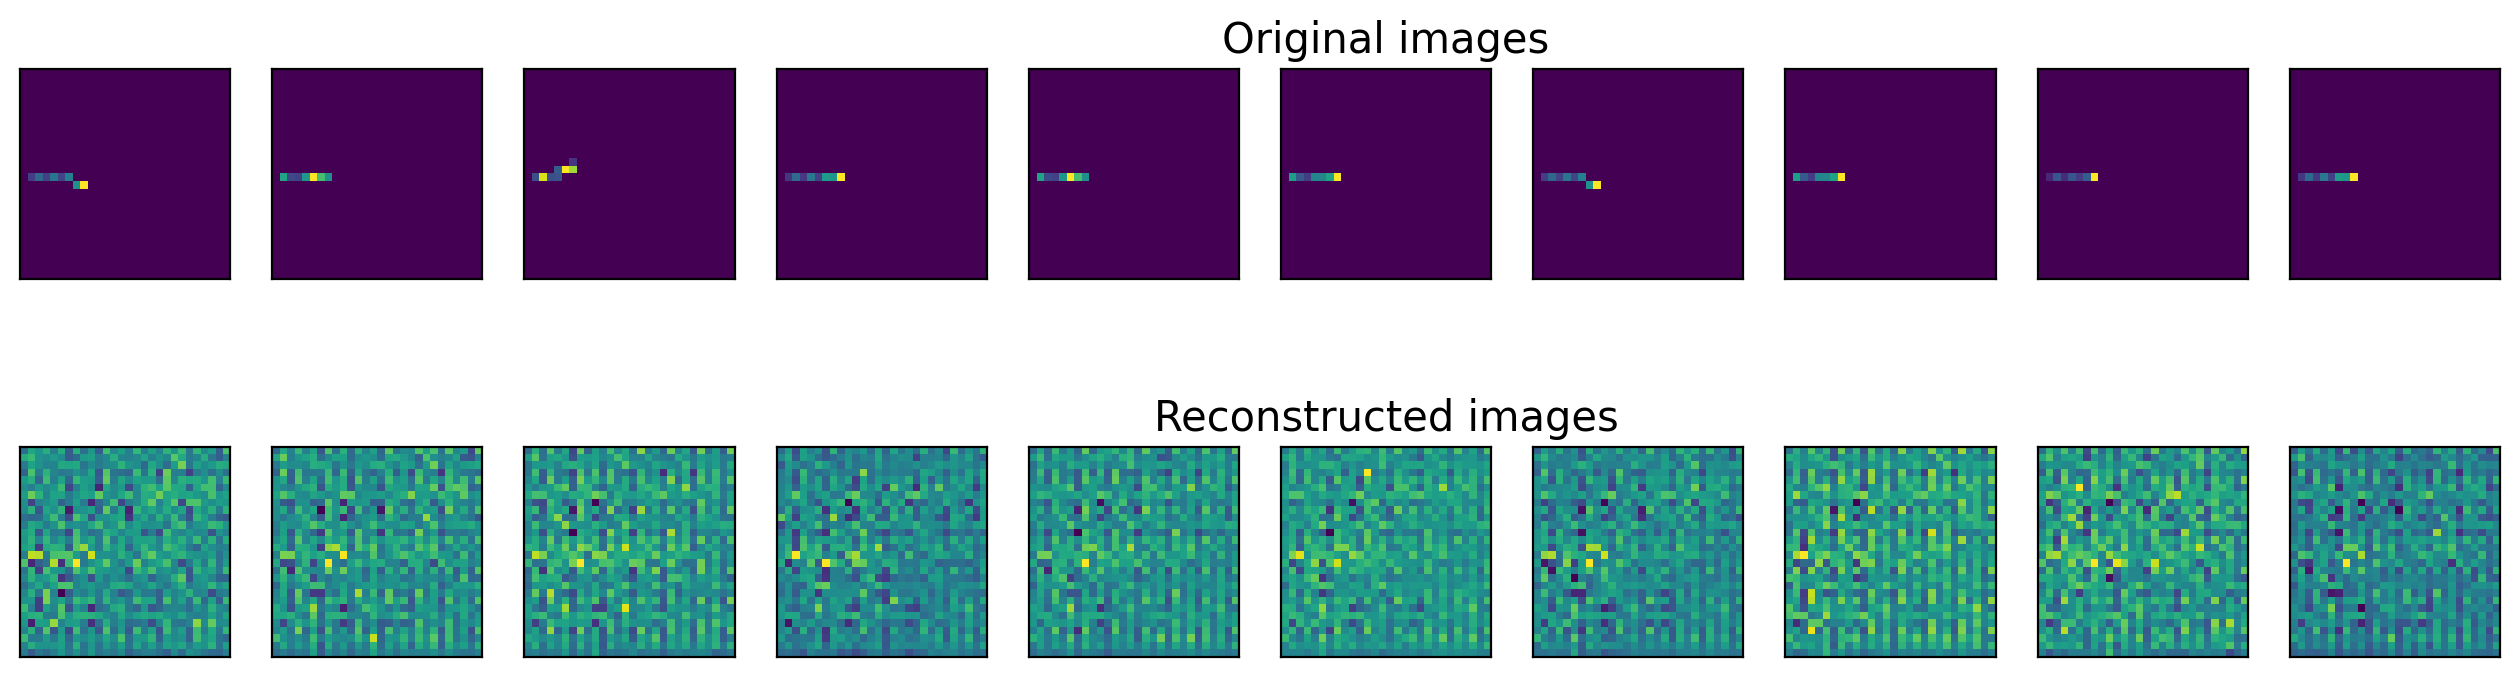


 EPOCH 500/500 	 train loss 1117.251 	 val loss 0.000


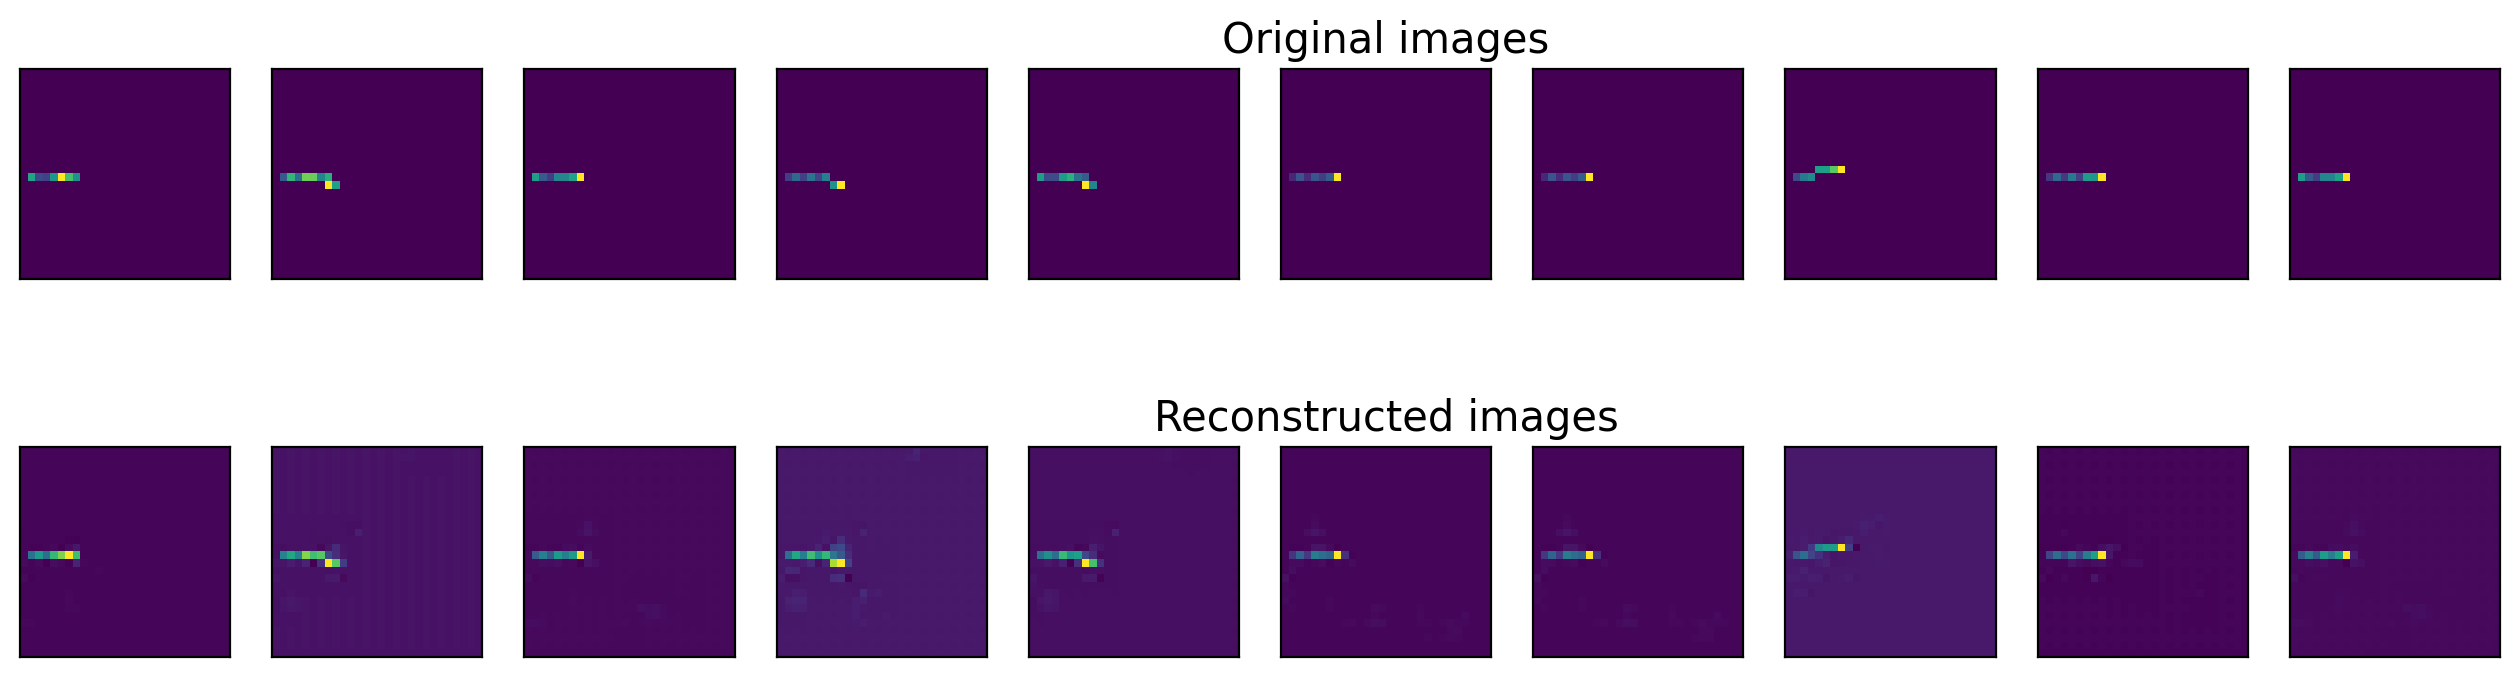

In [79]:
#>>>RUN: L21.4-runcell02

def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      ivae.eval()
      #encoder.eval()
      #decoder.eval()
      npones=np.ones((1,1))*1.50
      beam=torch.tensor(npones).float()
      with torch.no_grad():
         rec_img  = ivae.decoder(ivae.encoder(img,beam),beam)
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, c in dataloader:
        # Move tensor to the proper device
        c=c.reshape(len(c),1).float()
        x_hat = vae(x,c)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

lr = 1e-3
optim = torch.optim.Adam(cvae_proton_image.parameters(), lr=lr, weight_decay=1e-5)

num_epochs = 500

for epoch in range(num_epochs):
    train_loss = train_epoch(cvae_proton_image,train_loader,optim)
    val_loss=0
    if epoch % 500 == 0 or epoch == num_epochs-1:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,cvae_proton_image,n=10)

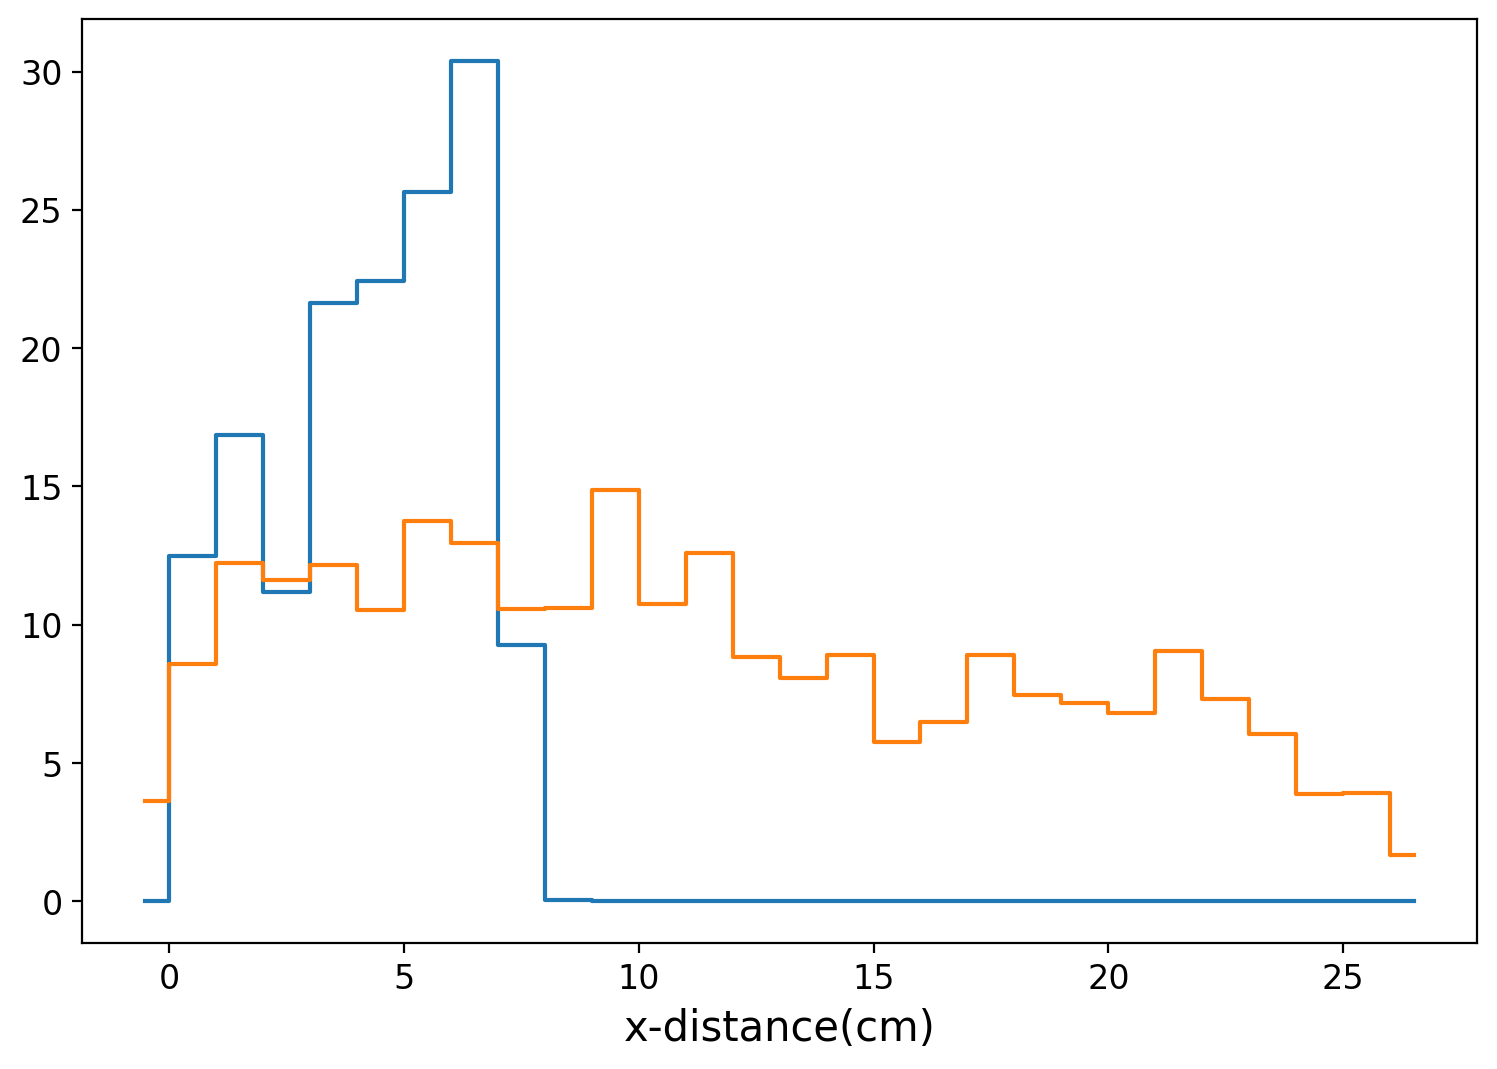

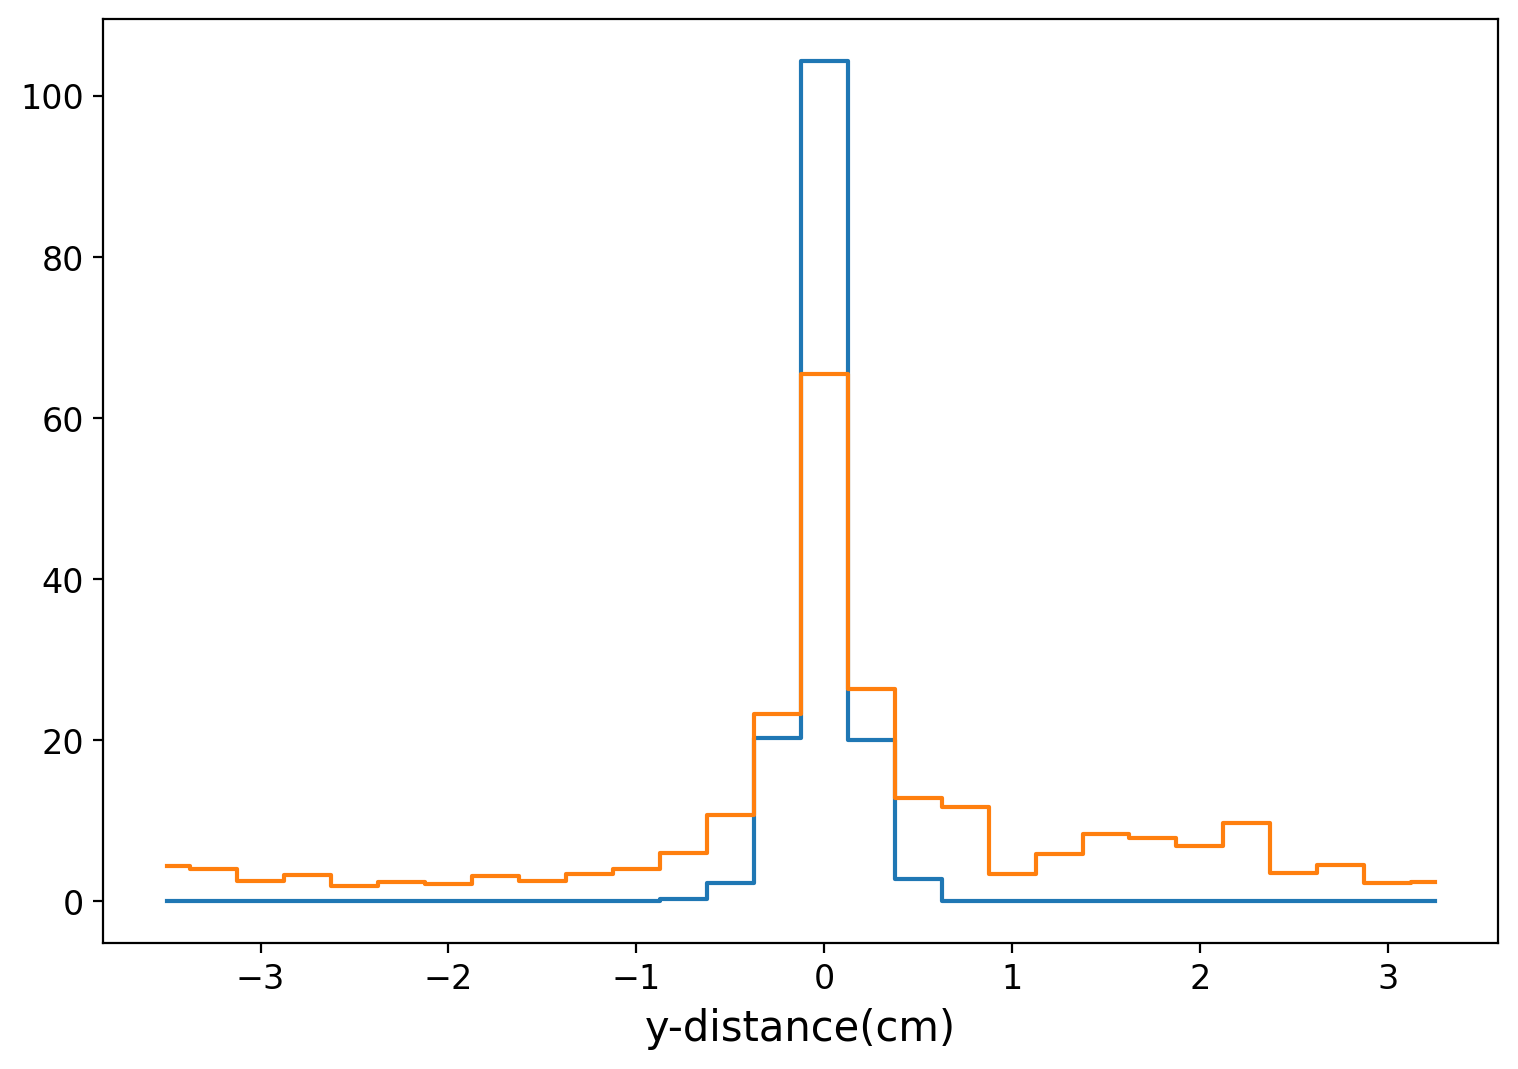

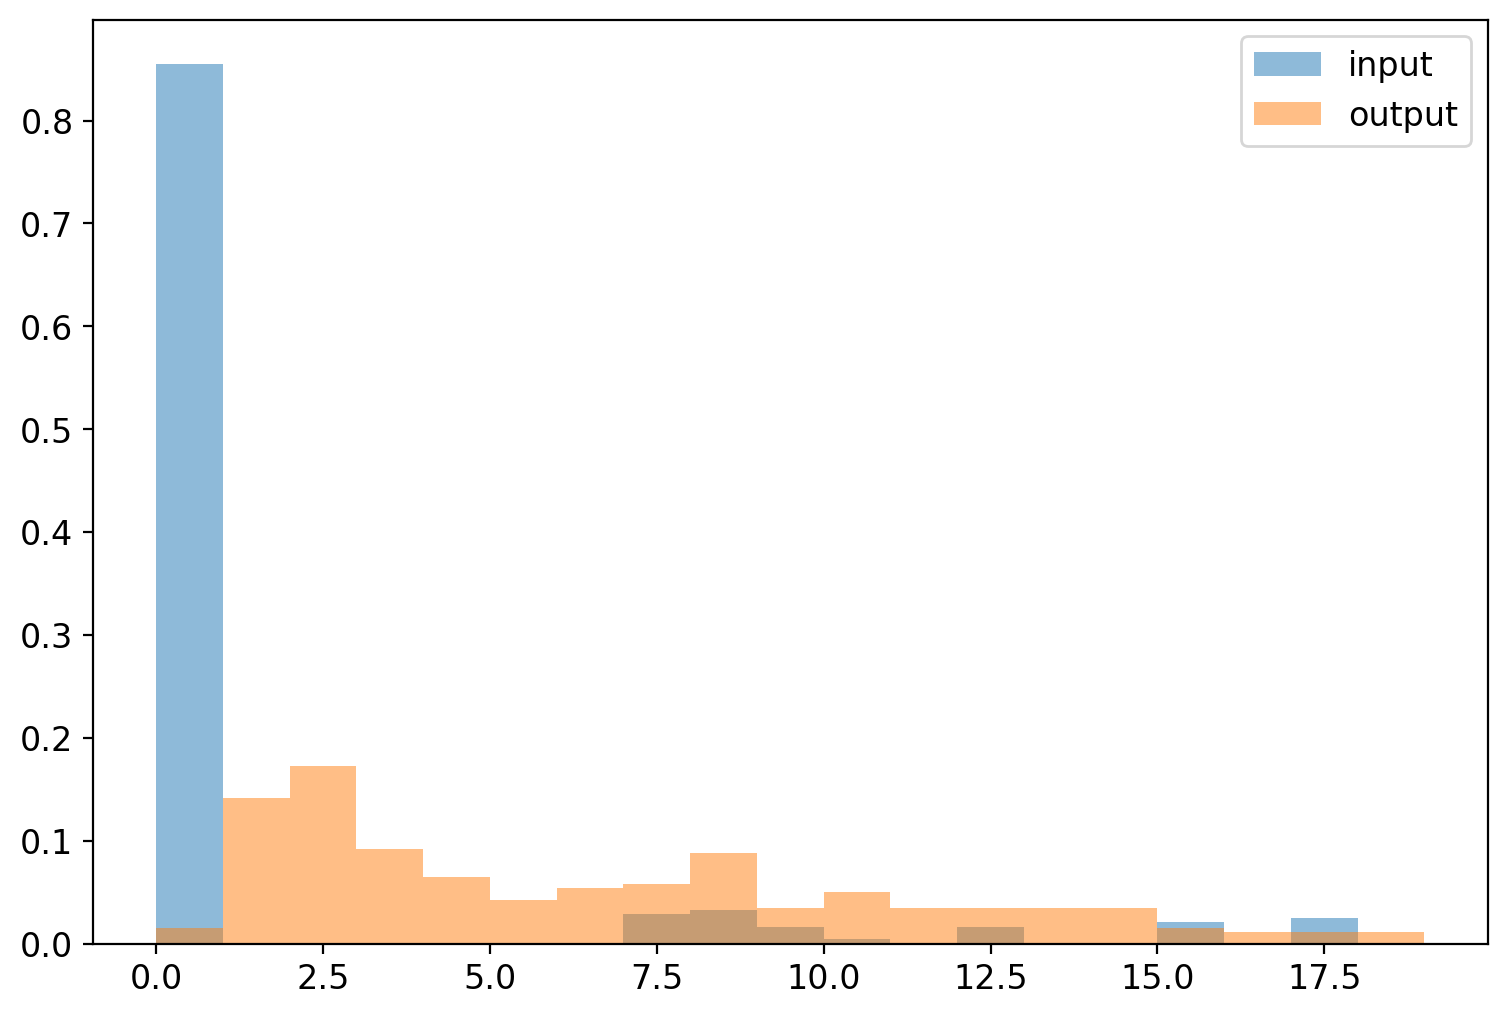

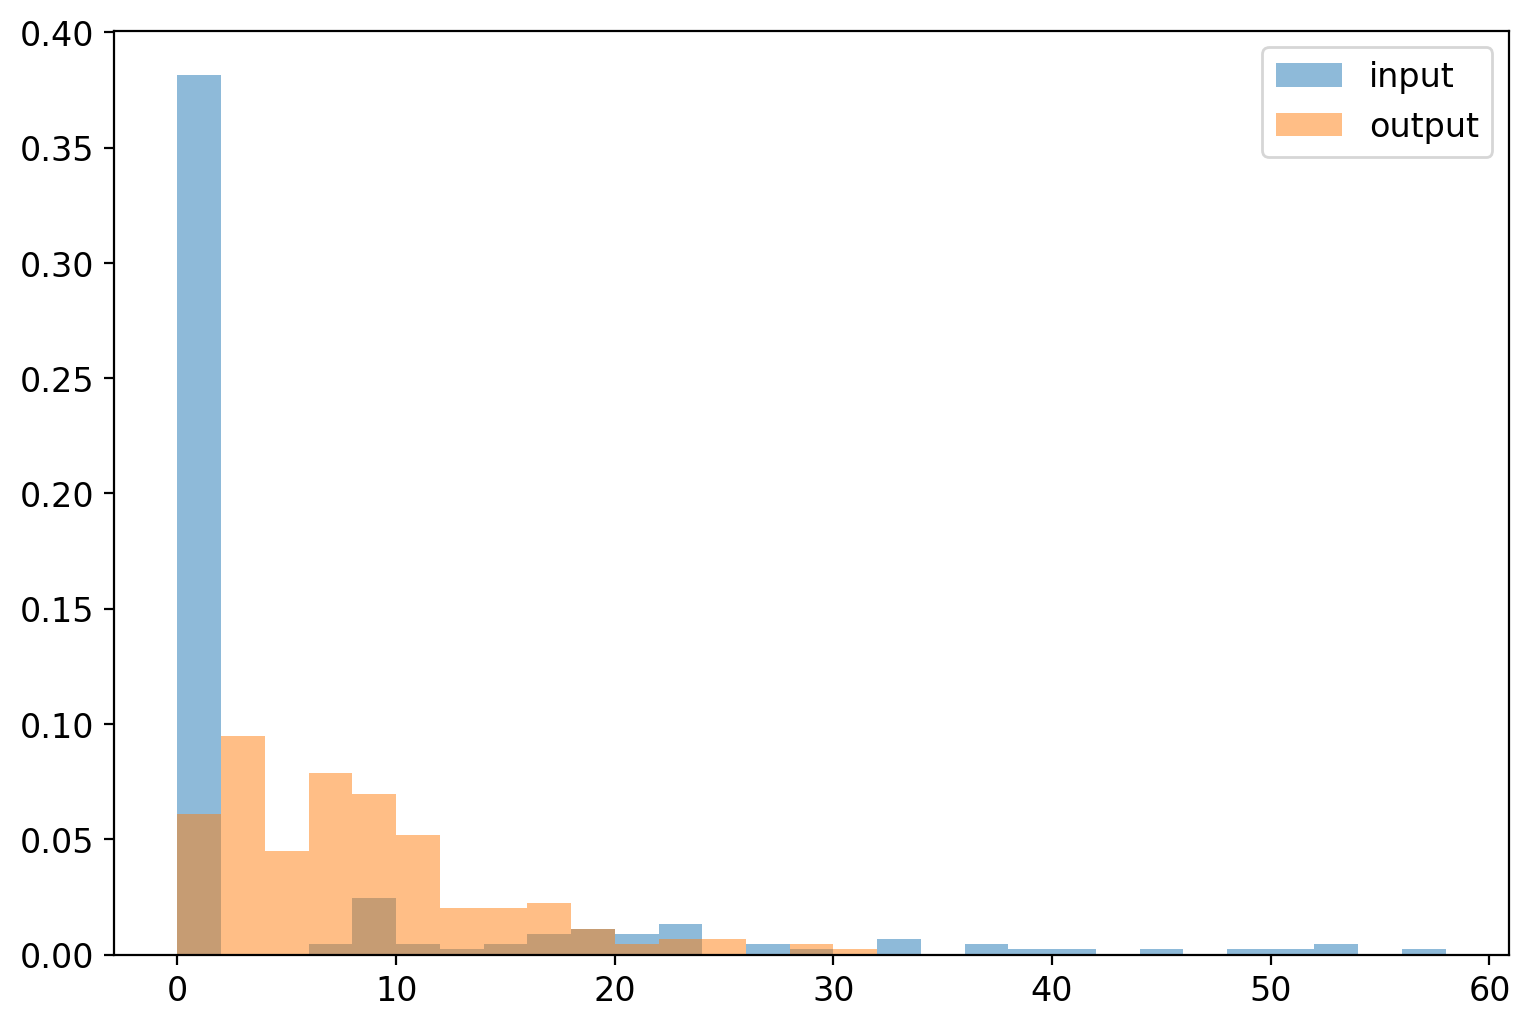

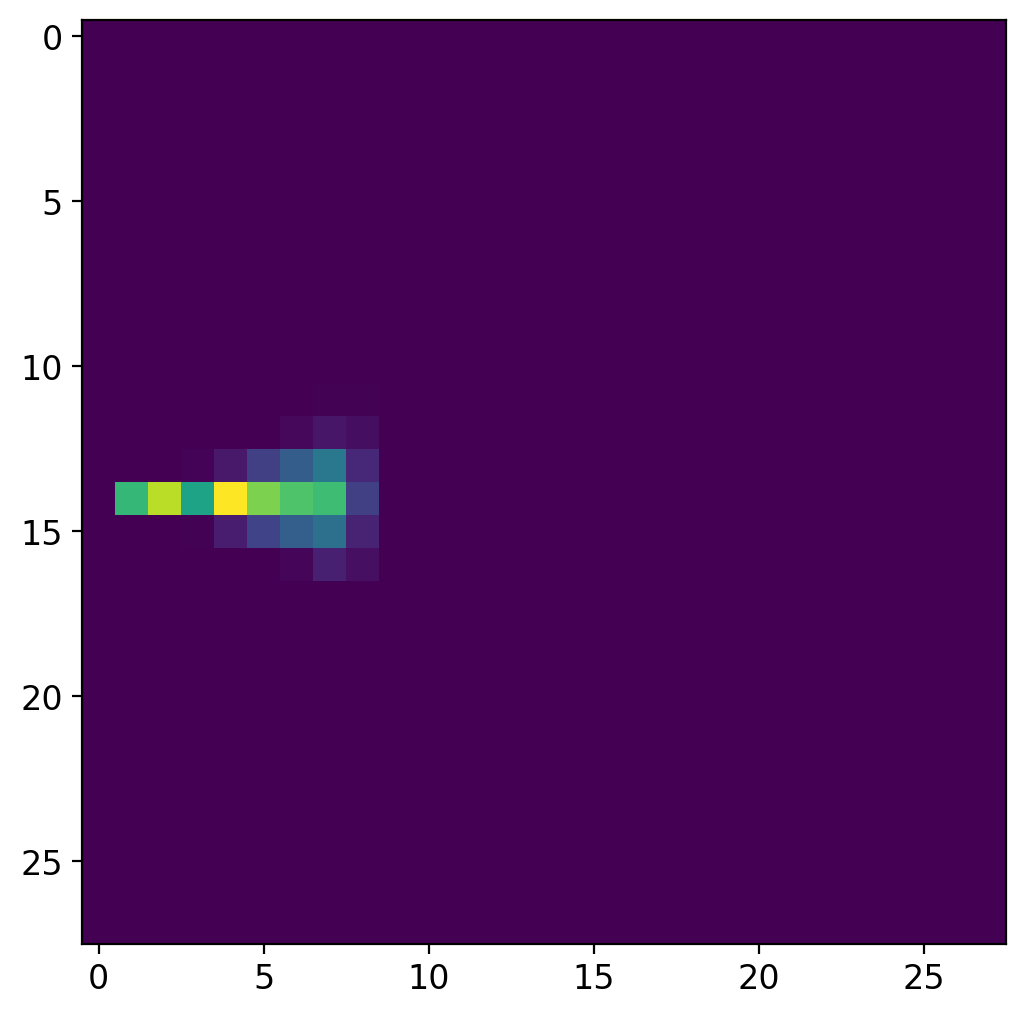

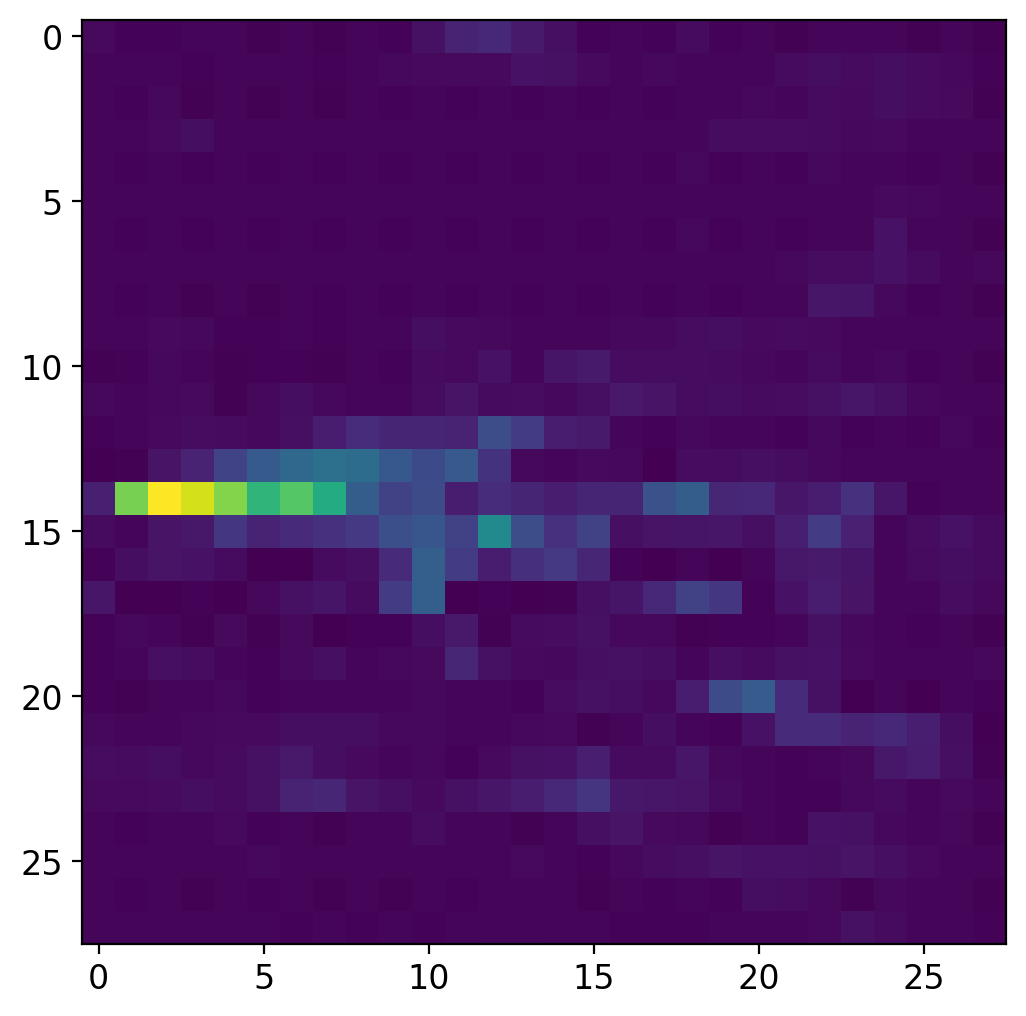

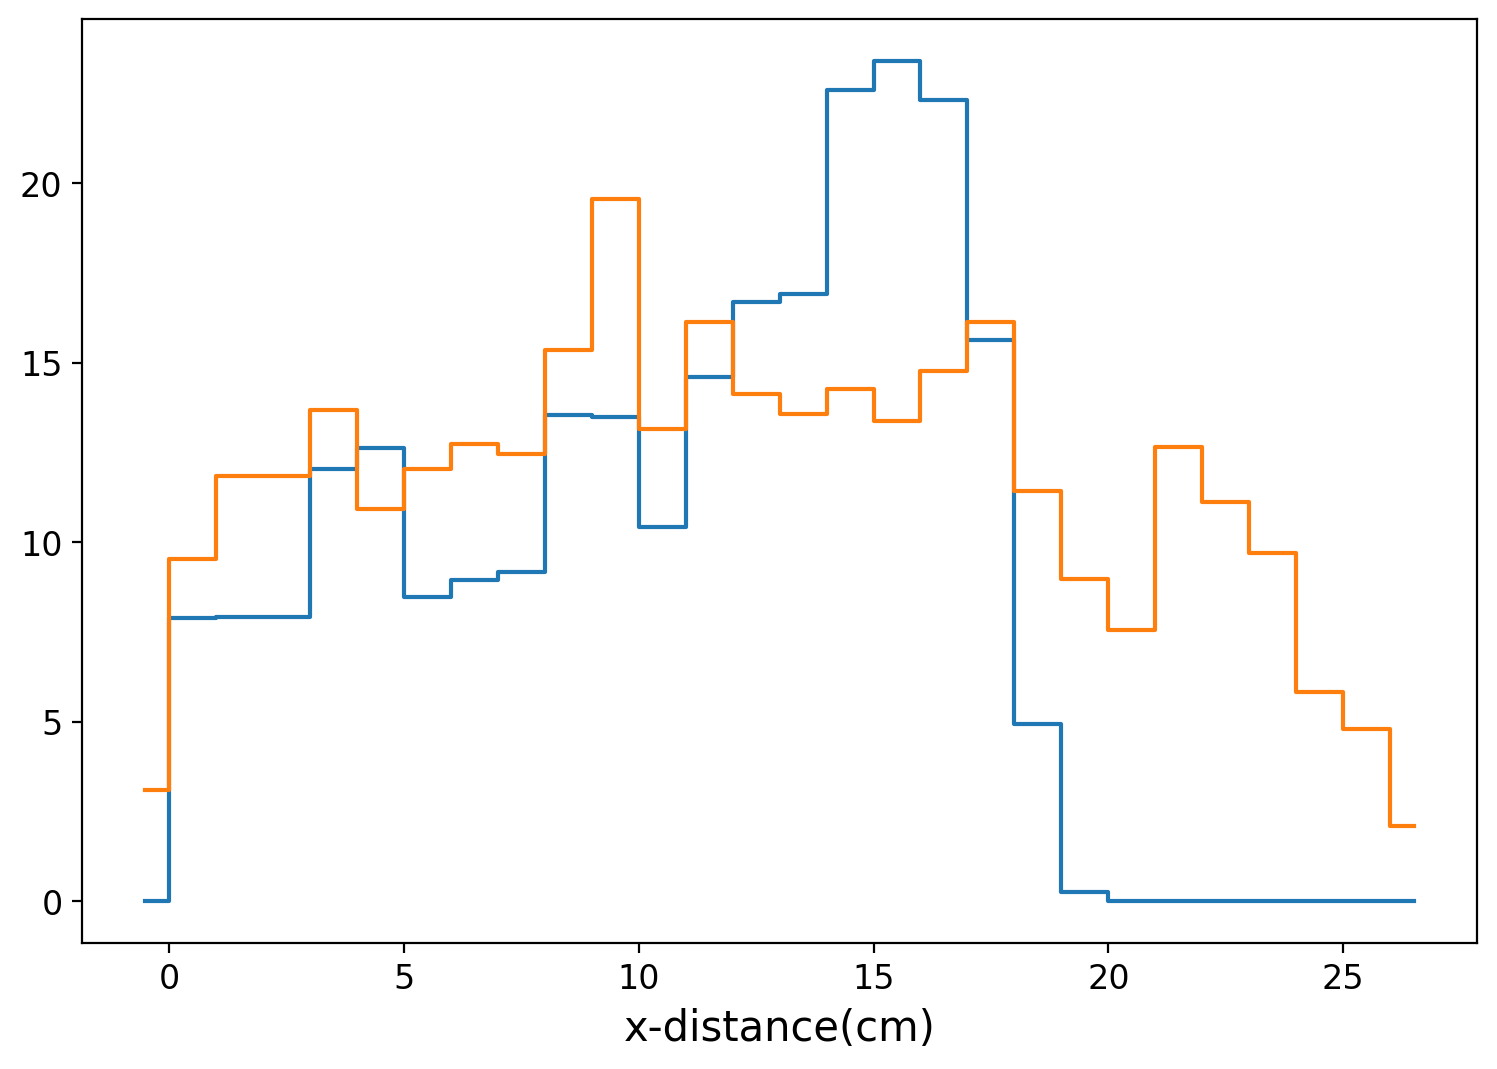

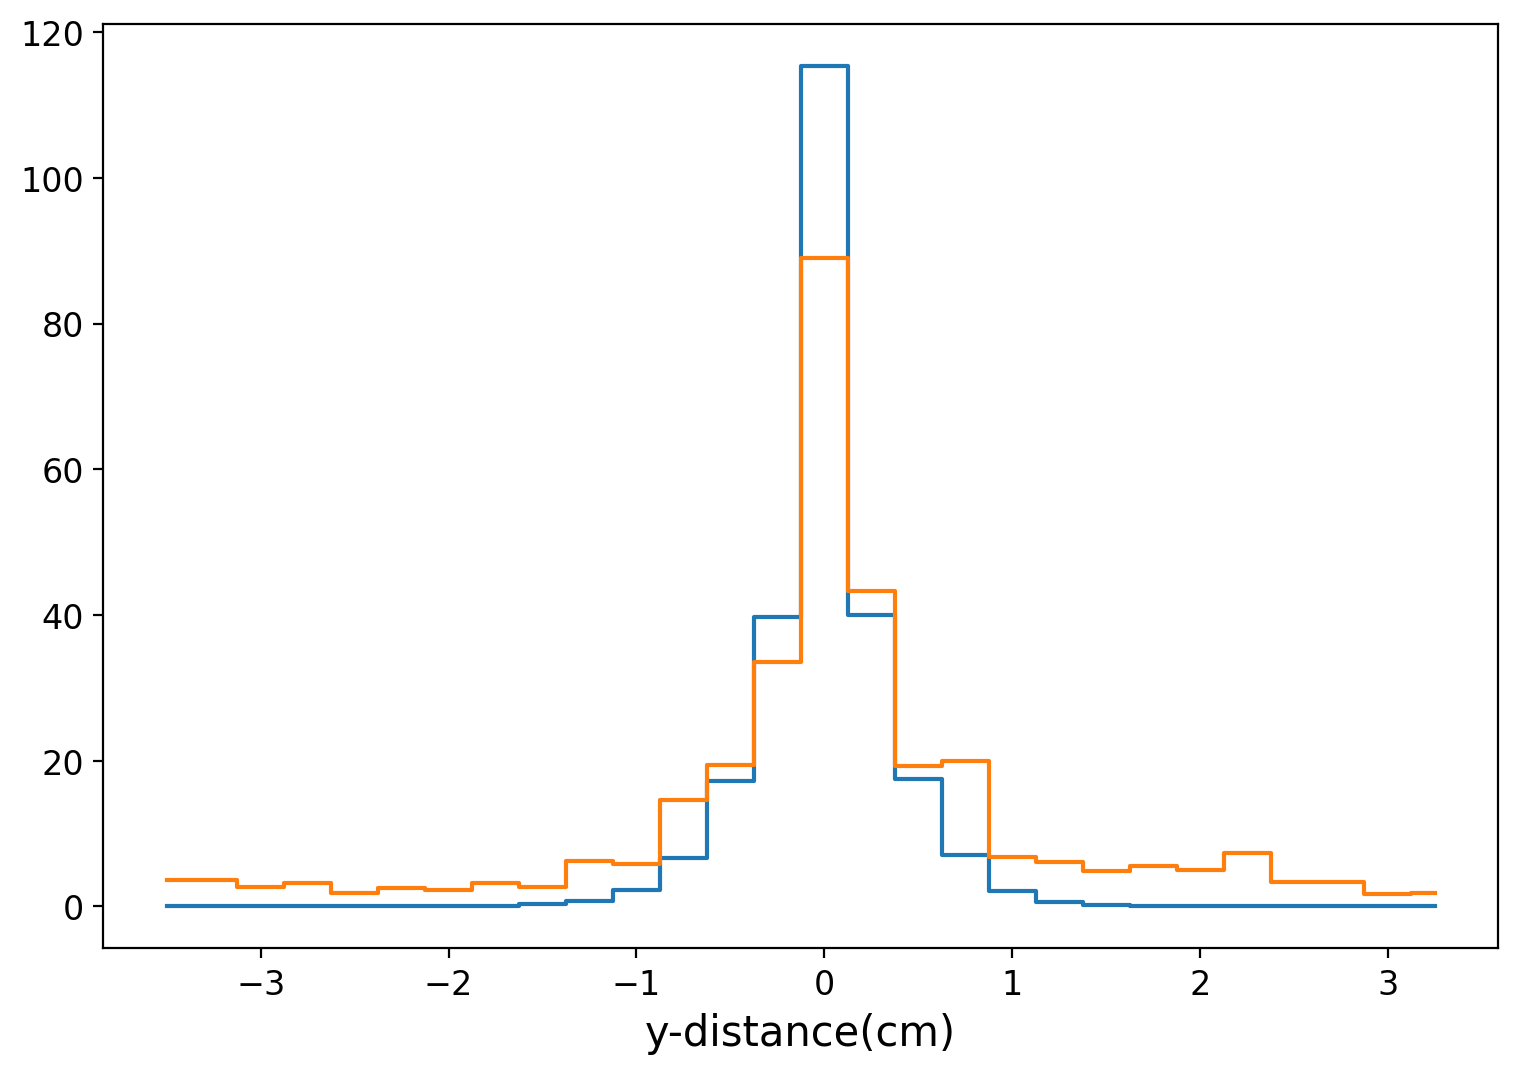

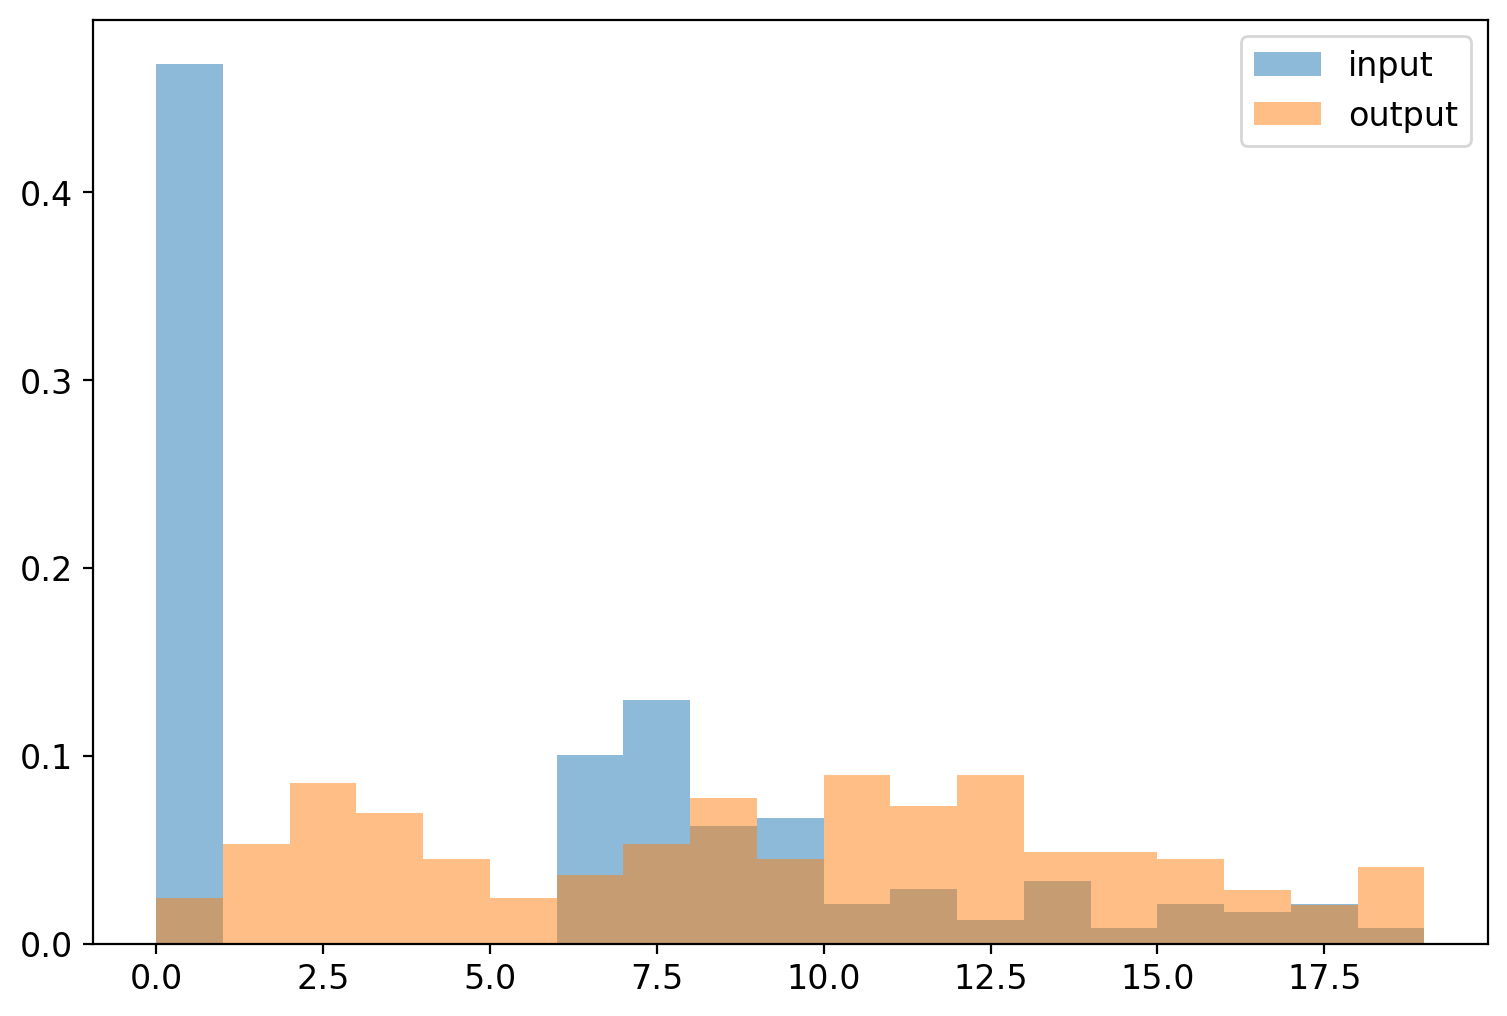

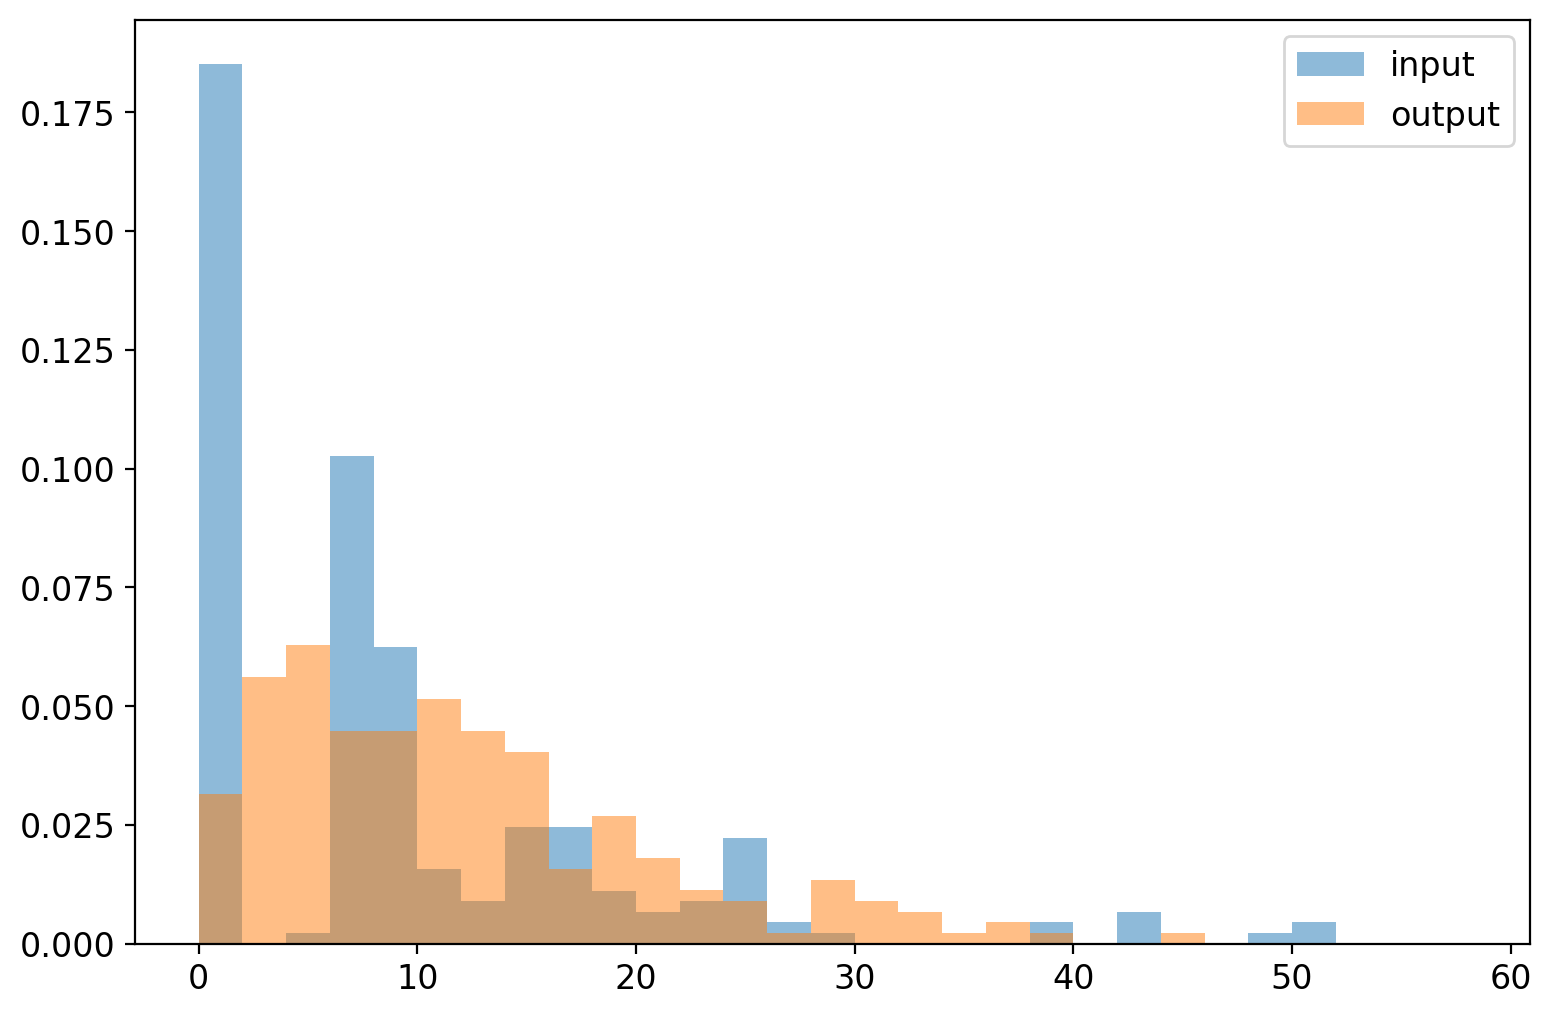

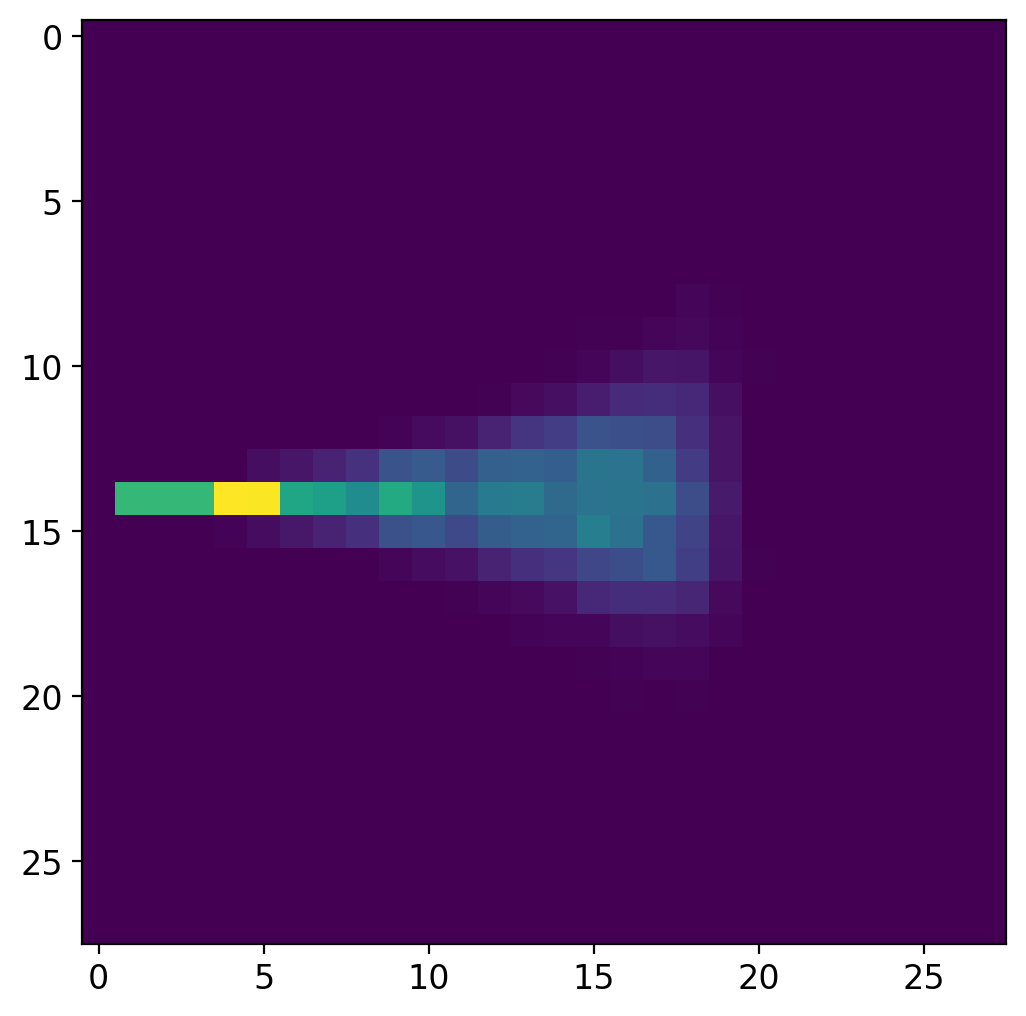

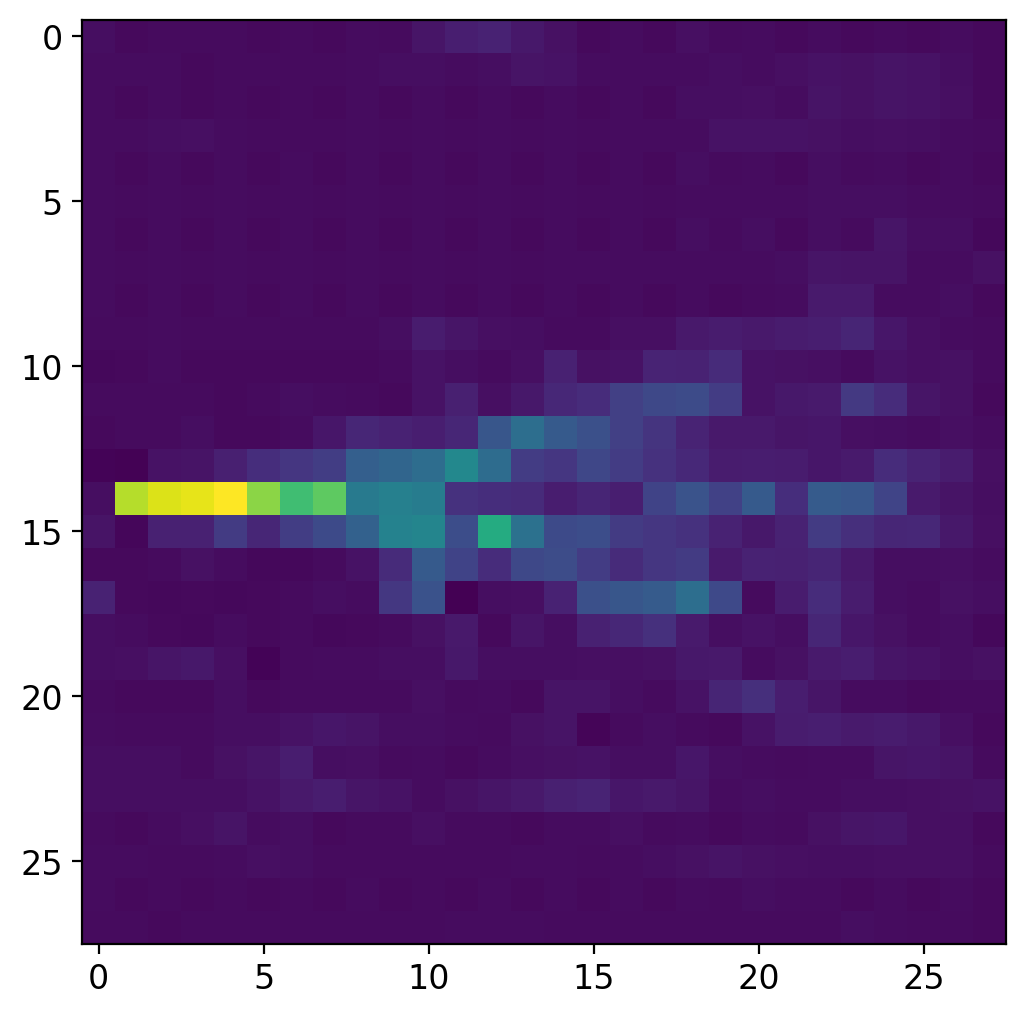

In [80]:
#>>>RUN: L21.4-runcell03

def plotCondVAEImageOutputs(iE,iLatentDim,iDataSet,iCVAE):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    beamenergy = torch.ones(iDataSet.shape[0],1)*iE
    rec_img  = iCVAE.decoder(testlatent,beamenergy)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.show()


    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,20,1)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[12:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[12:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

plotCondVAEImageOutputs(1.50,d,dimage150,cvae_proton_image)
#plotCondVAEImageOutputs(2.00,d,dimage200,cvae_proton_image)
#plotCondVAEImageOutputs(2.25,d,dimage200,cvae_proton_image)
plotCondVAEImageOutputs(2.50,d,dimage250,cvae_proton_image)
#plotCondVAEImageOutputs(3.00,d,dimage300,cvae_proton_image)
#torch.save(cvae_proton_image.state_dict(), 'cvae_test.pt')

In [81]:
#>>>RUN: L21.4-runcell04

import time

def generate(iLatentDim,iN,iCVAE,iE):
    testlatent=torch.randn(iN,iLatentDim)
    testlatent=testlatent.reshape(iN,iLatentDim)
    beamenergy = torch.ones(testlatent.shape[0],1)*iE
    rec_img  = iCVAE.decoder(testlatent,beamenergy)
    rec_img  = rec_img.detach().numpy()
    return rec_img

N=250
start=time.time()
generate(d,N,cvae_proton_image,1.5)
stop=time.time()
print("Time to generate 250 events:",(stop-start))
timeNN=(stop-start)

start=time.time()
simNYParallelSample(ie=150,im=mproton,iN=N,idt=1e-10,iZ=8)
stop=time.time()
print("Time to generate 250 events:",(stop-start))
timeGen=(stop-start)

print("===> speed up",timeGen/timeNN)

Time to generate 250 events: 0.03330802917480469
Scanning: 150
Time to generate 250 events: 21.561518669128418
===> speed up 647.3369695928535


<a name='exercises_22_4'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_4) | [Next Section](#section_22_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.4.1</span>

Rerun the training done in code cell `L21.4-runcell02` for 2500 epochs instead of only 500 (note that this will take some time!). Then use code cell `L21.4-runcell03` to look at the comparison of input and reconstructed distributions. Do the features of the decoded output improve? What is the approximate value of the training loss that you achieve at the end of this expanded training? Report your answer as a number with precision `1e1`.

<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.4.2</span>

With this new data (trained for 2500 epochs), use `plotCondVAEImageOutputs` to model the shower shape for a beam of initial energy 225 MeV, which is not one of the values that we used to train, but falls within the range of the training data. Also try 400 MeV, which falls outside the range of the training data. How does these look?

Which do you think the VAE is more capable of modeling, based on the training? Enter your answer for which energy would be modeled better, as number in units of MeV.

<br>

<a name='section_22_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.5 Bootstrapping </h2>  


| [Top](#section_22_0) | [Previous Section](#section_22_4) | [Exercises](#exercises_22_5) | [Next Section](#section_22_6) |

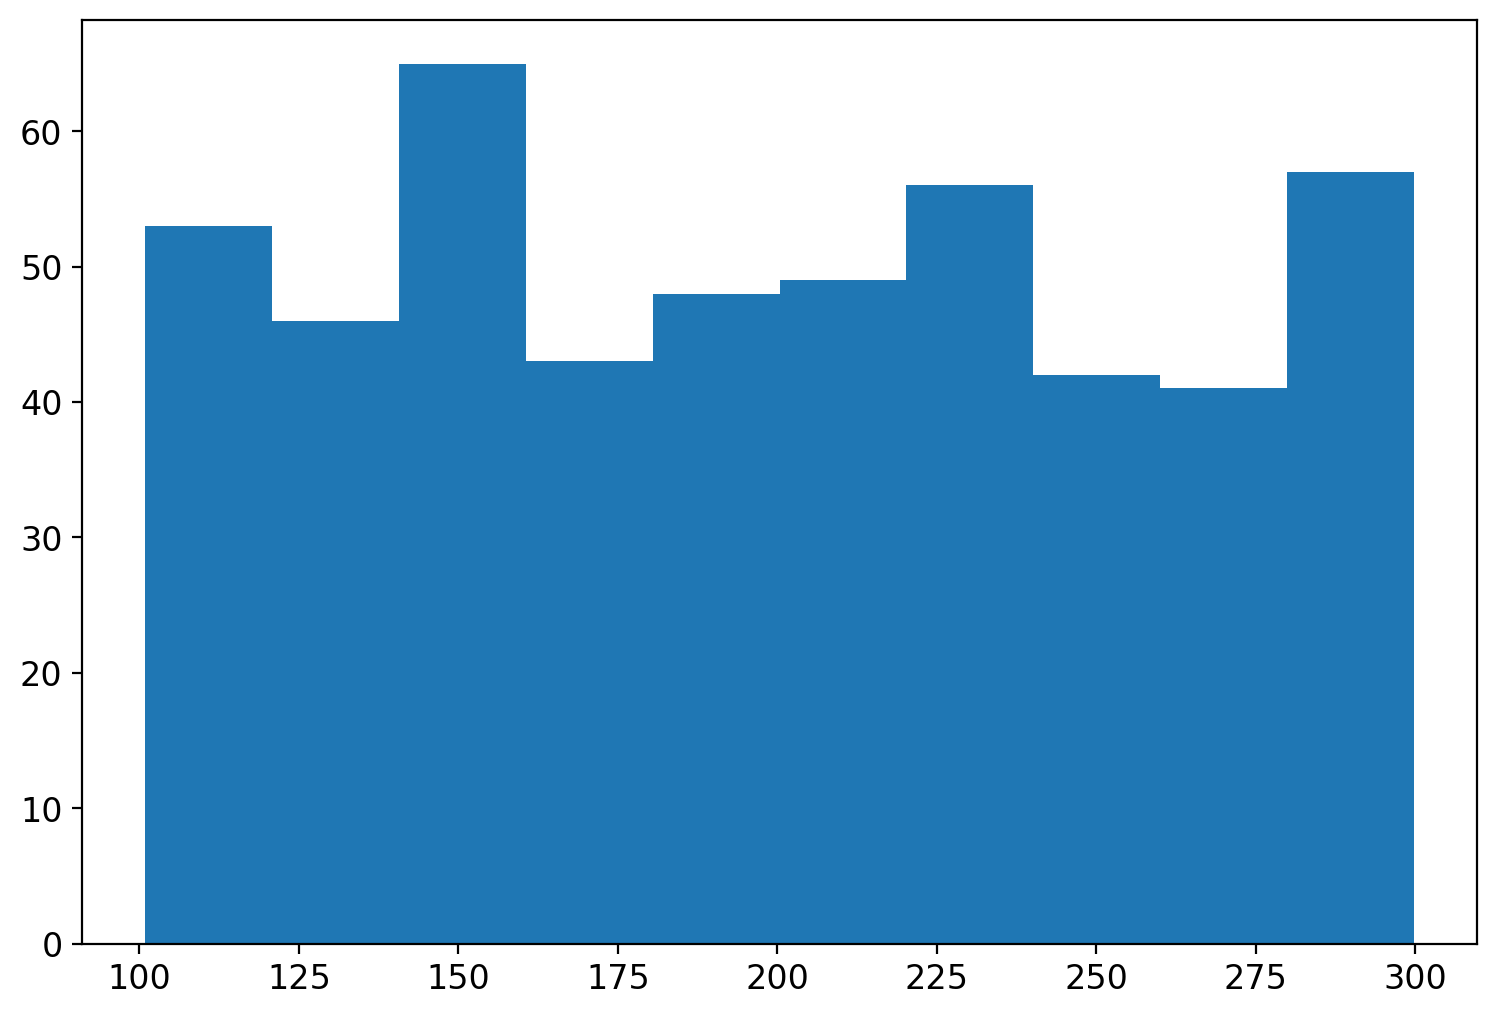

Mean: 199.319528292951
RMS: 58.292903725996844


In [82]:
#>>>RUN: L21.5-runcell01

np.random.seed(0)

samples = np.random.uniform(100,300,500)
plt.hist(samples)
plt.show()

print("Mean:",np.mean(samples))
print("RMS:",np.std(samples))

[7 8 2 3 3]
[6 0 3 6 3 9 6 3 2 2]
[2 6 4 6 0 4 9 2 1 6 1 7 5 6 1 6 6 6 6 2]


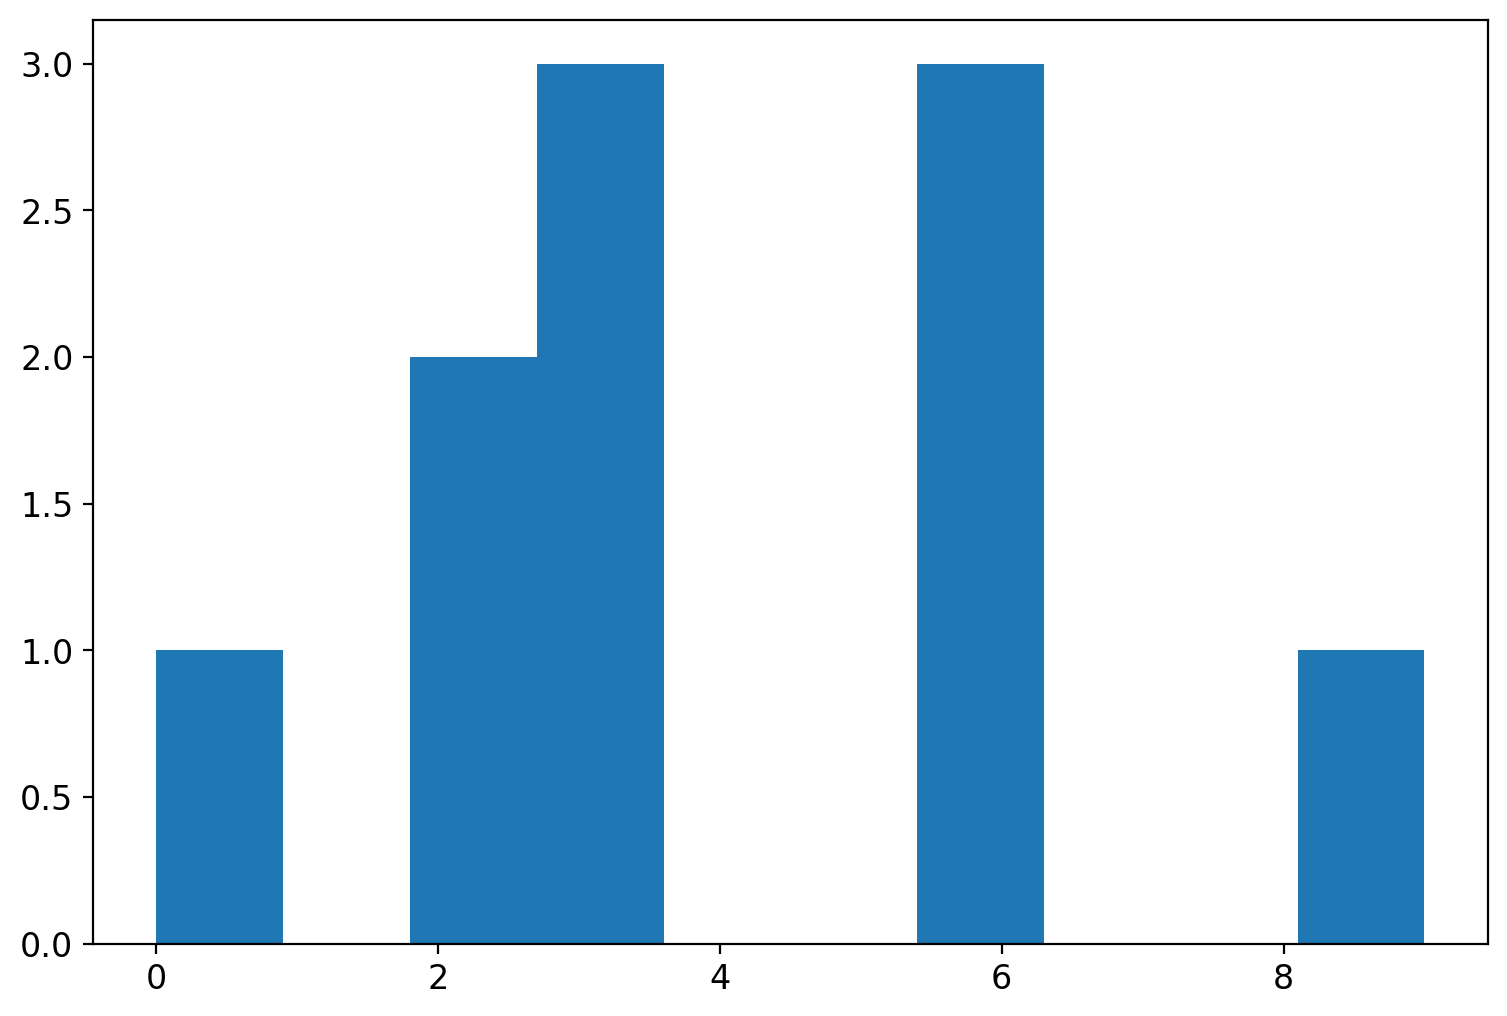

In [83]:
#>>>RUN: L21.5-runcell02

arr=np.arange(10)
test=np.random.choice(arr,size=5)
print(test)
test=np.random.choice(arr,size=10)
print(test)
plt.hist(test)
test=np.random.choice(arr,size=20)
print(test)

Mean: 198.08016730431723
RMS: 57.24319769264833


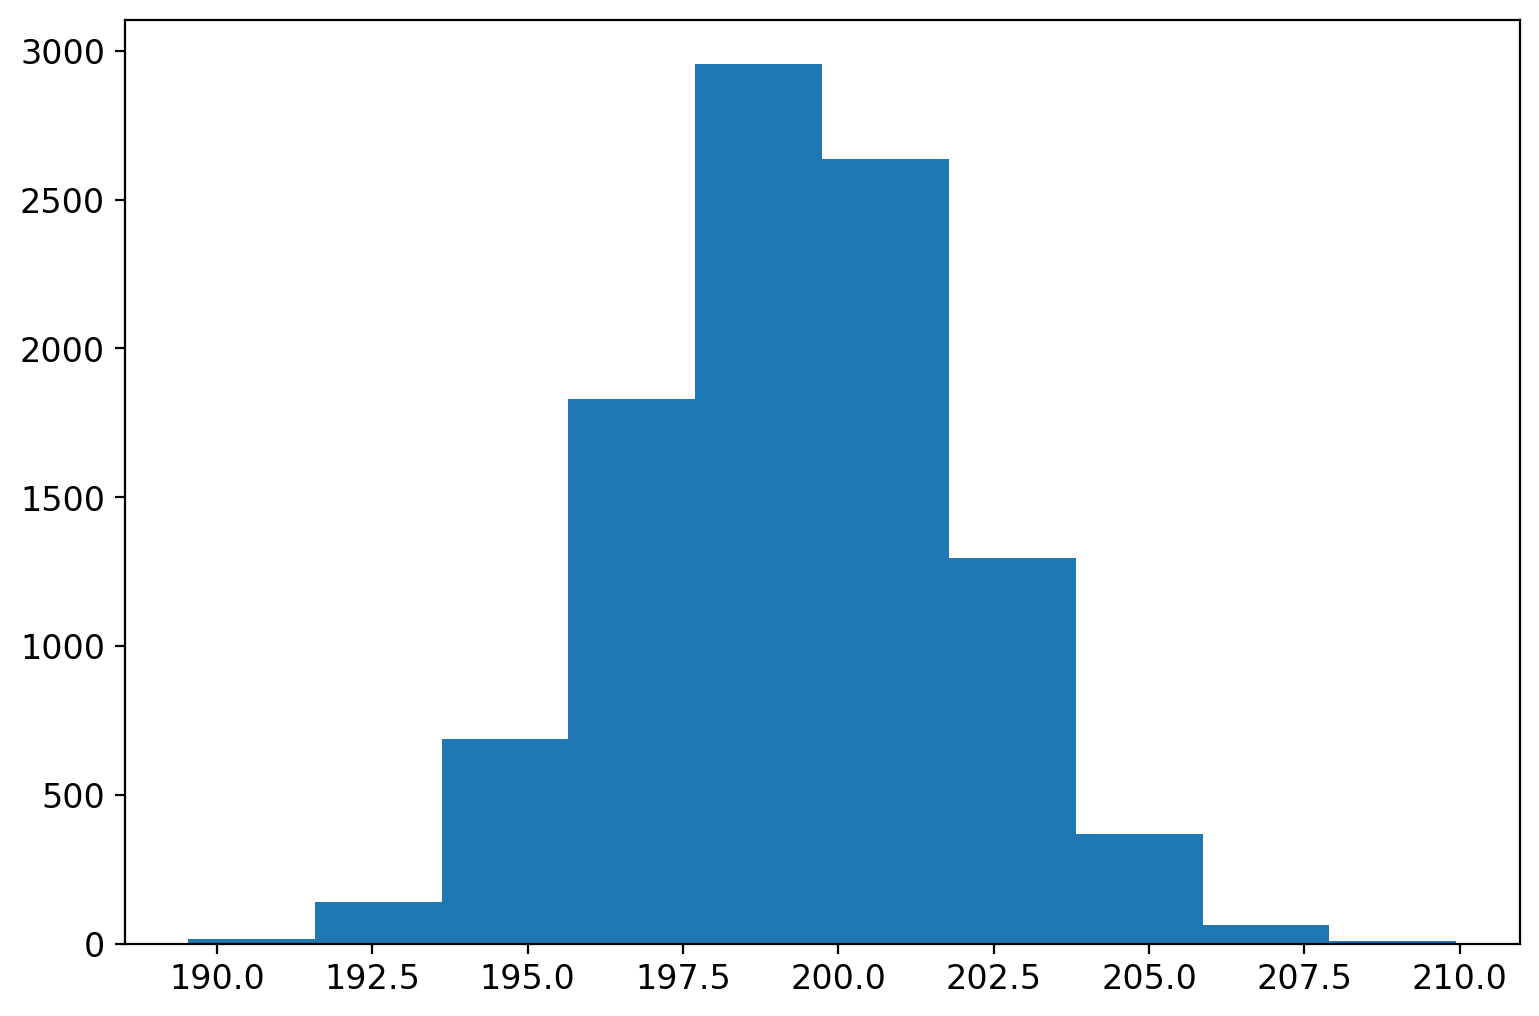

Mean of samples: 199.32677439883224
Std of mean of samples: 2.640552106329232


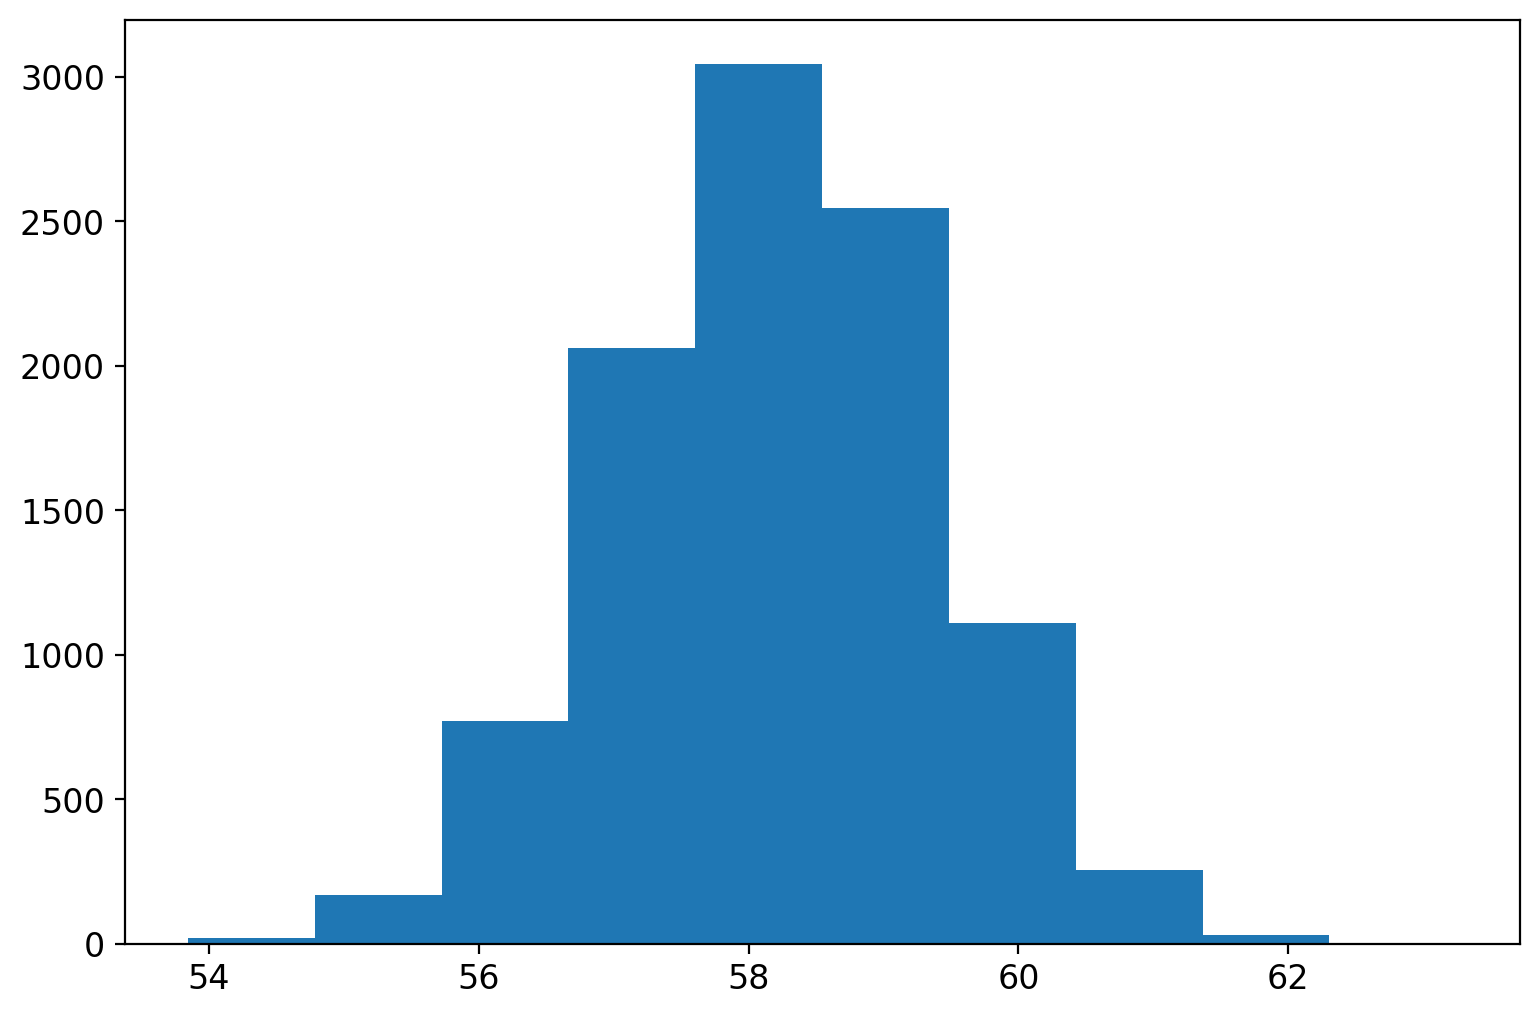

Mean of samples: 58.215460679674244
Std of mean of samples: 1.180453634729457


In [84]:
#>>>RUN: L21.5-runcell03

sample=np.random.choice(samples, size = 500)
print("Mean:",np.mean(sample))
print("RMS:",np.std(sample))

boot_means = []
boot_stds  = []
for _ in range(10000):
    boot_sample = np.random.choice(samples,replace = True, size = 500) # take a random sample each iteration
    boot_means.append(np.mean(boot_sample)) # append the mean to boot_means
    boot_stds.append(np.std(boot_sample)) # append the mean to boot_means
boot_means_np = np.array(boot_means) # transform it into a numpy array for calculation
boot_stds_np = np.array(boot_stds)

plt.hist(boot_means_np)
plt.show()

print("Mean of samples:",np.mean(boot_means_np))
print("Std of mean of samples:",np.std(boot_means_np))

plt.hist(boot_stds_np)
plt.show()

print("Mean of samples:",np.mean(boot_stds_np))
print("Std of mean of samples:",np.std(boot_stds_np))

In [85]:
#>>>RUN: L21.5-runcell04

analytic         = (300.+100.)/2.
analytic_std     = (300.-100.)/np.sqrt(12.)
analytic_err     = analytic_std/np.sqrt(500.)
analytic_std_err = analytic_std/np.sqrt(500.)/2.
print("Mean of samples:",np.mean(boot_means_np),"+/-",np.std(boot_means_np)
      ,"\nAnalytic:",analytic,"+/-",analytic_err)

print("Std of samples:",np.mean(boot_stds_np),"+/-",np.std(boot_stds_np)
      ,"\nAnalytic:",analytic_std,"+/-",analytic_std_err)


Mean of samples: 199.32677439883224 +/- 2.640552106329232 
Analytic: 200.0 +/- 2.581988897471611
Std of samples: 58.215460679674244 +/- 1.180453634729457 
Analytic: 57.73502691896258 +/- 1.2909944487358056


In [86]:
#>>>RUN: L21.5-runcell05

samp_means = []
samp_stds  = []
for _ in range(10000):
    samp_sample = np.random.uniform(100,300,500)
    samp_means.append(np.mean(samp_sample)) # append the mean to boot_means
    samp_stds.append(np.std(samp_sample)) # append the mean to boot_means
samp_means_np = np.array(samp_means) # transform it into a numpy array for calculation
samp_stds_np = np.array(samp_stds)

print("Mean of samples:",np.mean(samp_means_np),"+/-",np.std(samp_means_np)
      ,"\nBoot:",np.mean(boot_means_np),"+/-",np.std(boot_means_np))

print("Std of samples:",np.mean(samp_stds_np),"+/-",np.std(samp_stds_np)
      ,"\nBoot:",np.mean(boot_stds_np),"+/-",np.std(boot_stds_np))


Mean of samples: 200.00105715106469 +/- 2.5999028409759712 
Boot: 199.32677439883224 +/- 2.640552106329232
Std of samples: 57.65265613152296 +/- 1.153638575967969 
Boot: 58.215460679674244 +/- 1.180453634729457


In [87]:
#>>>RUN: L21.5-runcell06

from scipy.stats import bootstrap
import numpy as np

test_samples = (samples,)
bootstrap_ci = bootstrap(test_samples, np.std, confidence_level=0.68,random_state=1, method='percentile')
print(bootstrap_ci.confidence_interval,(bootstrap_ci.confidence_interval.high-bootstrap_ci.confidence_interval.low)/2.)
print(bootstrap_ci.standard_error)

ConfidenceInterval(low=57.06494018920665, high=59.381851248961716) 1.158455529877532
1.1614765422620512


(500, 10)


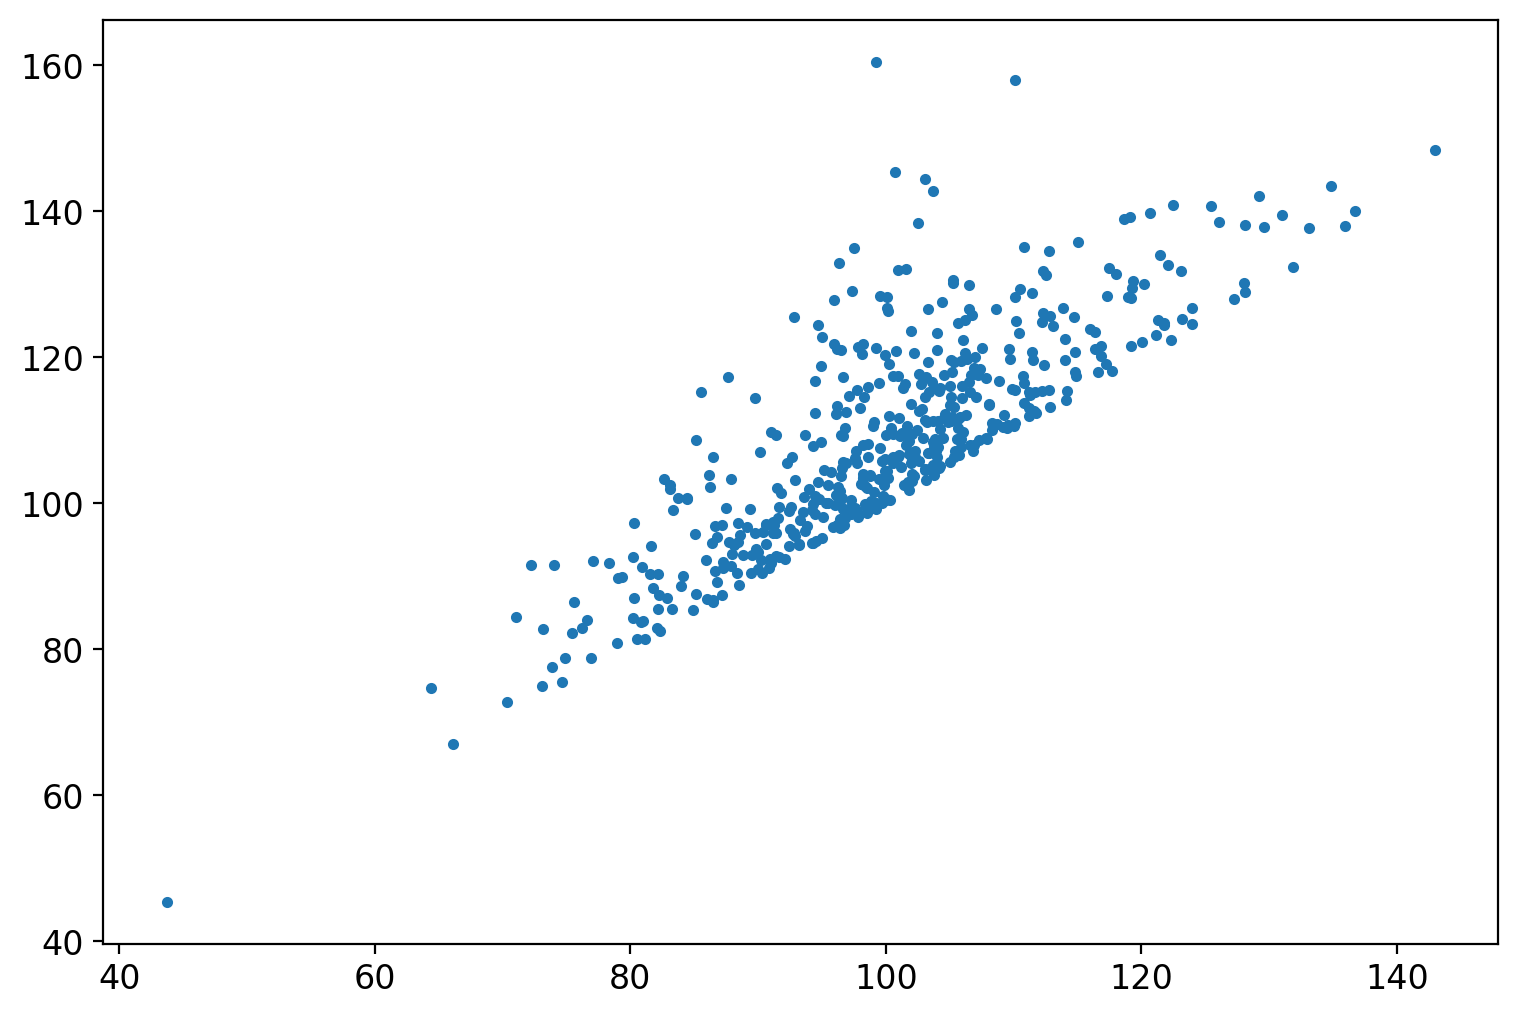

correlation: [[1.         0.82317335]
 [0.82317335 1.        ]]


(array([  1.,   0.,   4.,  28.,  84., 143., 150.,  66.,  19.,   5.]),
 array([ 89.14739505, 109.36785749, 129.58831994, 149.80878238,
        170.02924482, 190.24970727, 210.47016971, 230.69063215,
        250.9110946 , 271.13155704, 291.35201949]),
 <BarContainer object of 10 artists>)

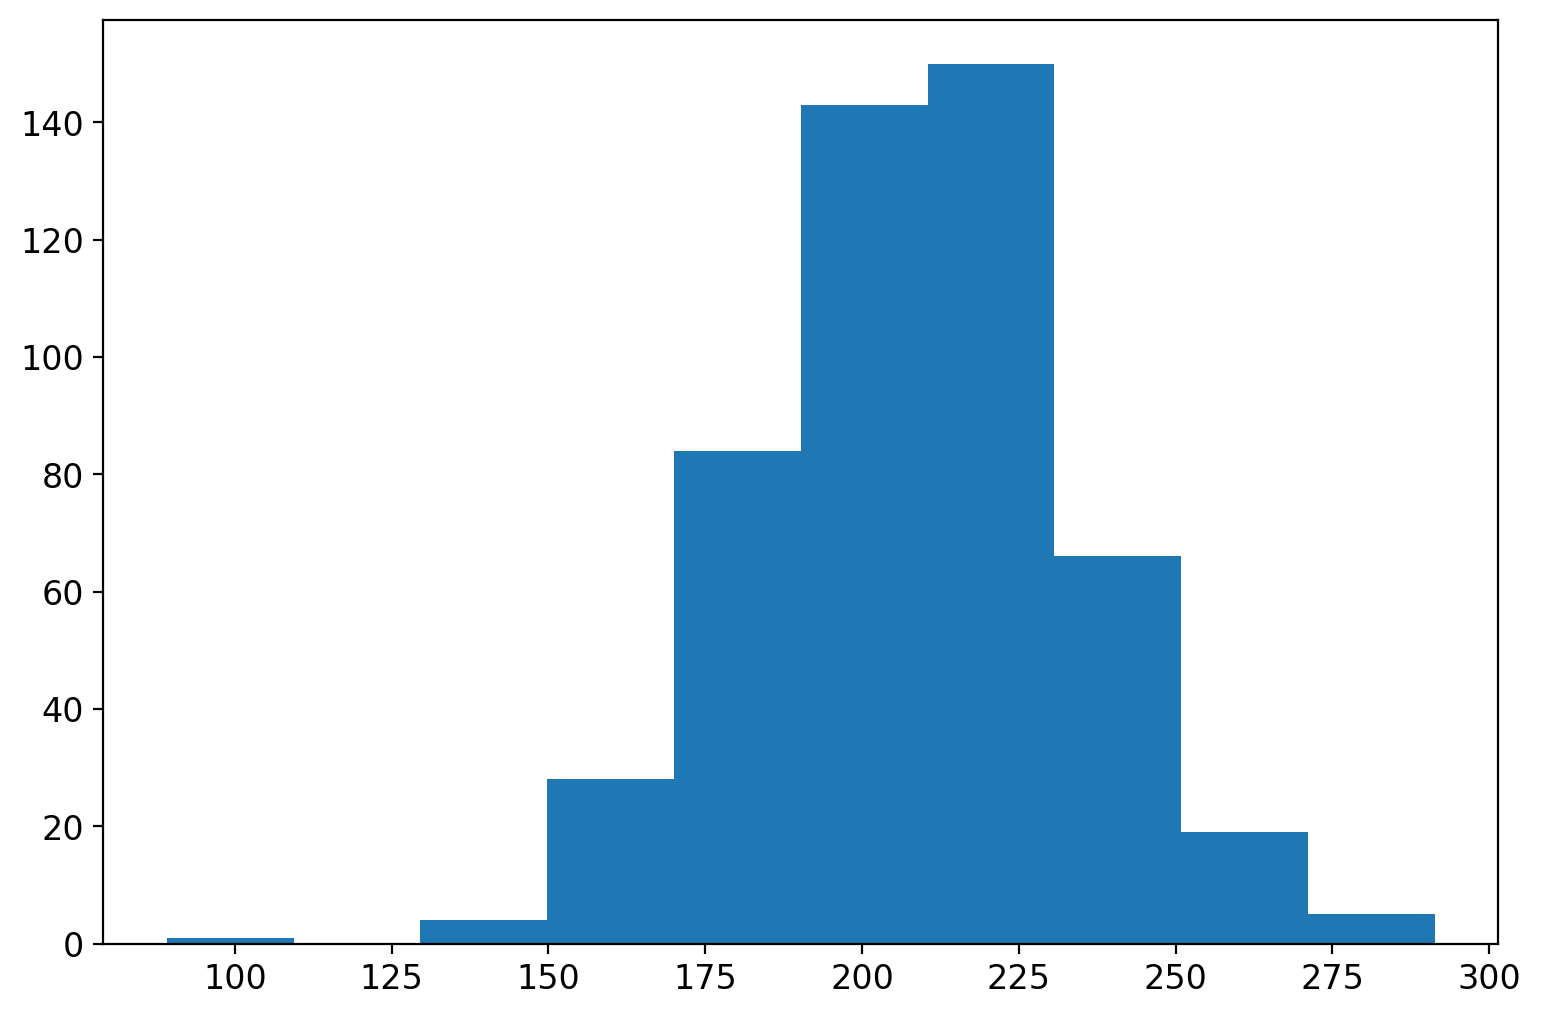

In [88]:
#>>>RUN: L21.5-runcell07

def func(x):
    x_sort = np.sort(x,axis=1)
    print(x_sort.shape)
    return (np.vstack((x_sort[:,0] + x_sort[:,-1],x_sort[:,1] + x_sort[:,-1] ))).T

rand_data = np.random.uniform(0,100,5000).reshape(500,10)
out_data = func(rand_data)
plt.plot(out_data[:,0],out_data[:,1],".")
plt.show()
print("correlation:",np.corrcoef(out_data[:,0],out_data[:,1]))

plt.hist(out_data[:,0]+out_data[:,1])

Sum of Boot: 208.9432511206885 +/- 1.1646447707040062 -For Comparison sqrt(N) unc- 0.6464414143921915
Corr of samples: 0.8226739115753527 +/- 0.020320526110901776
(10000,)


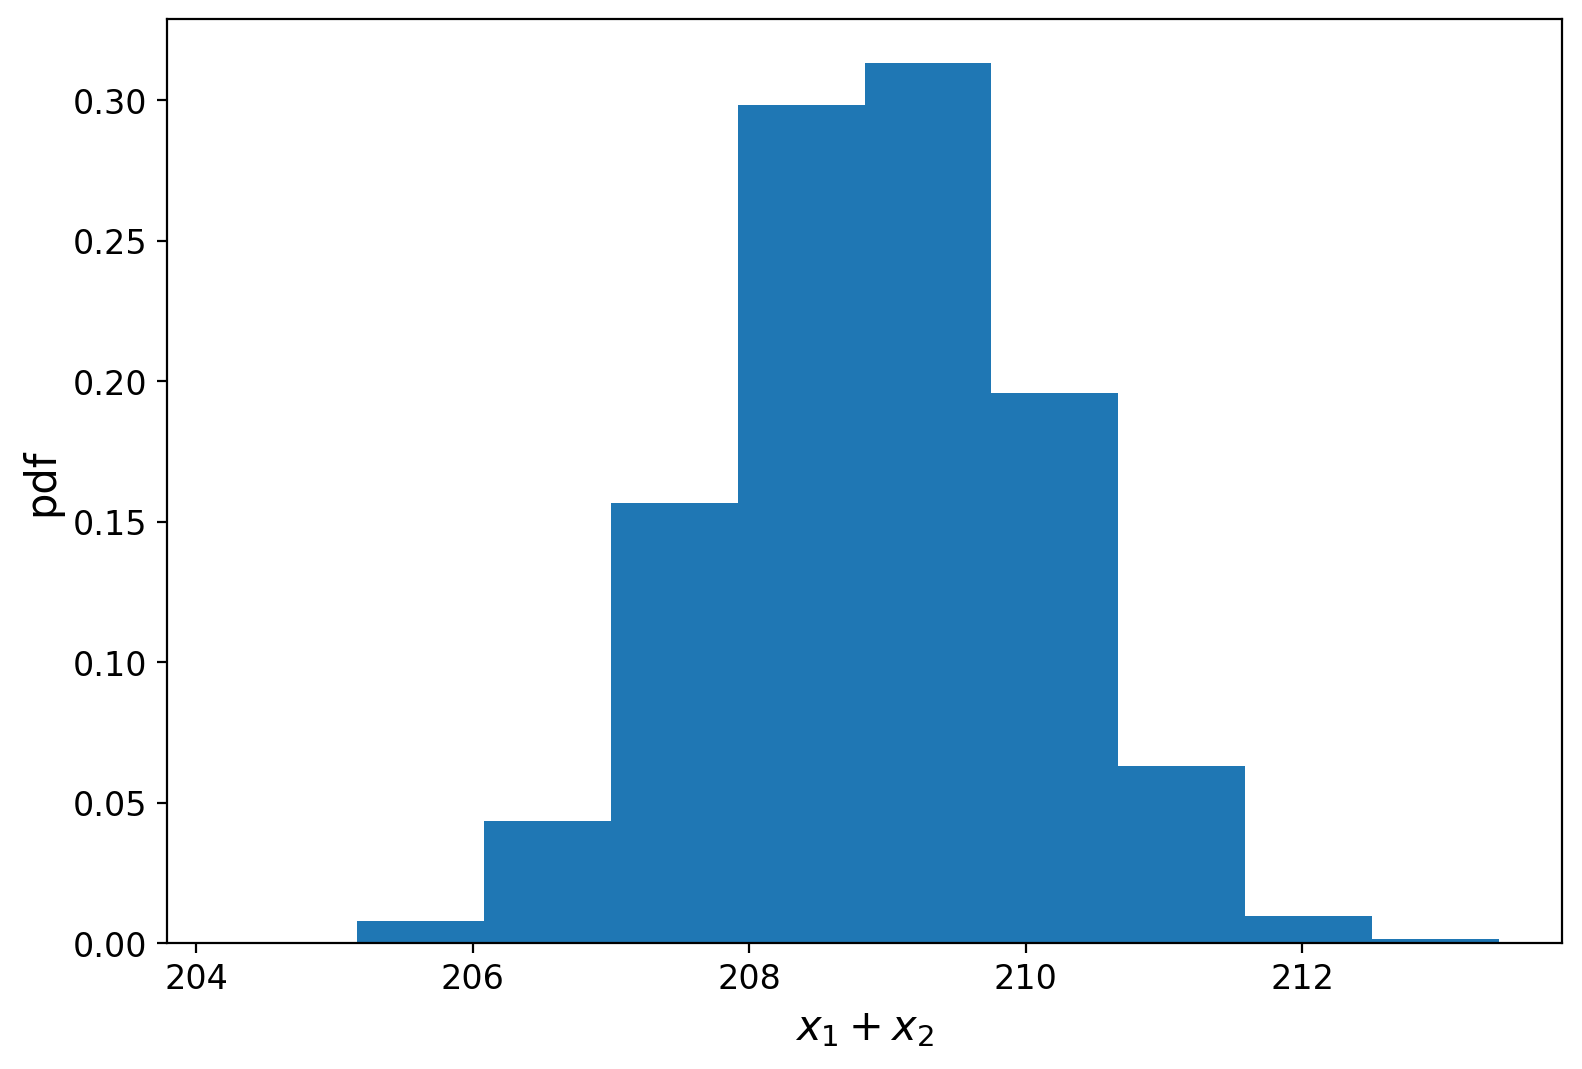

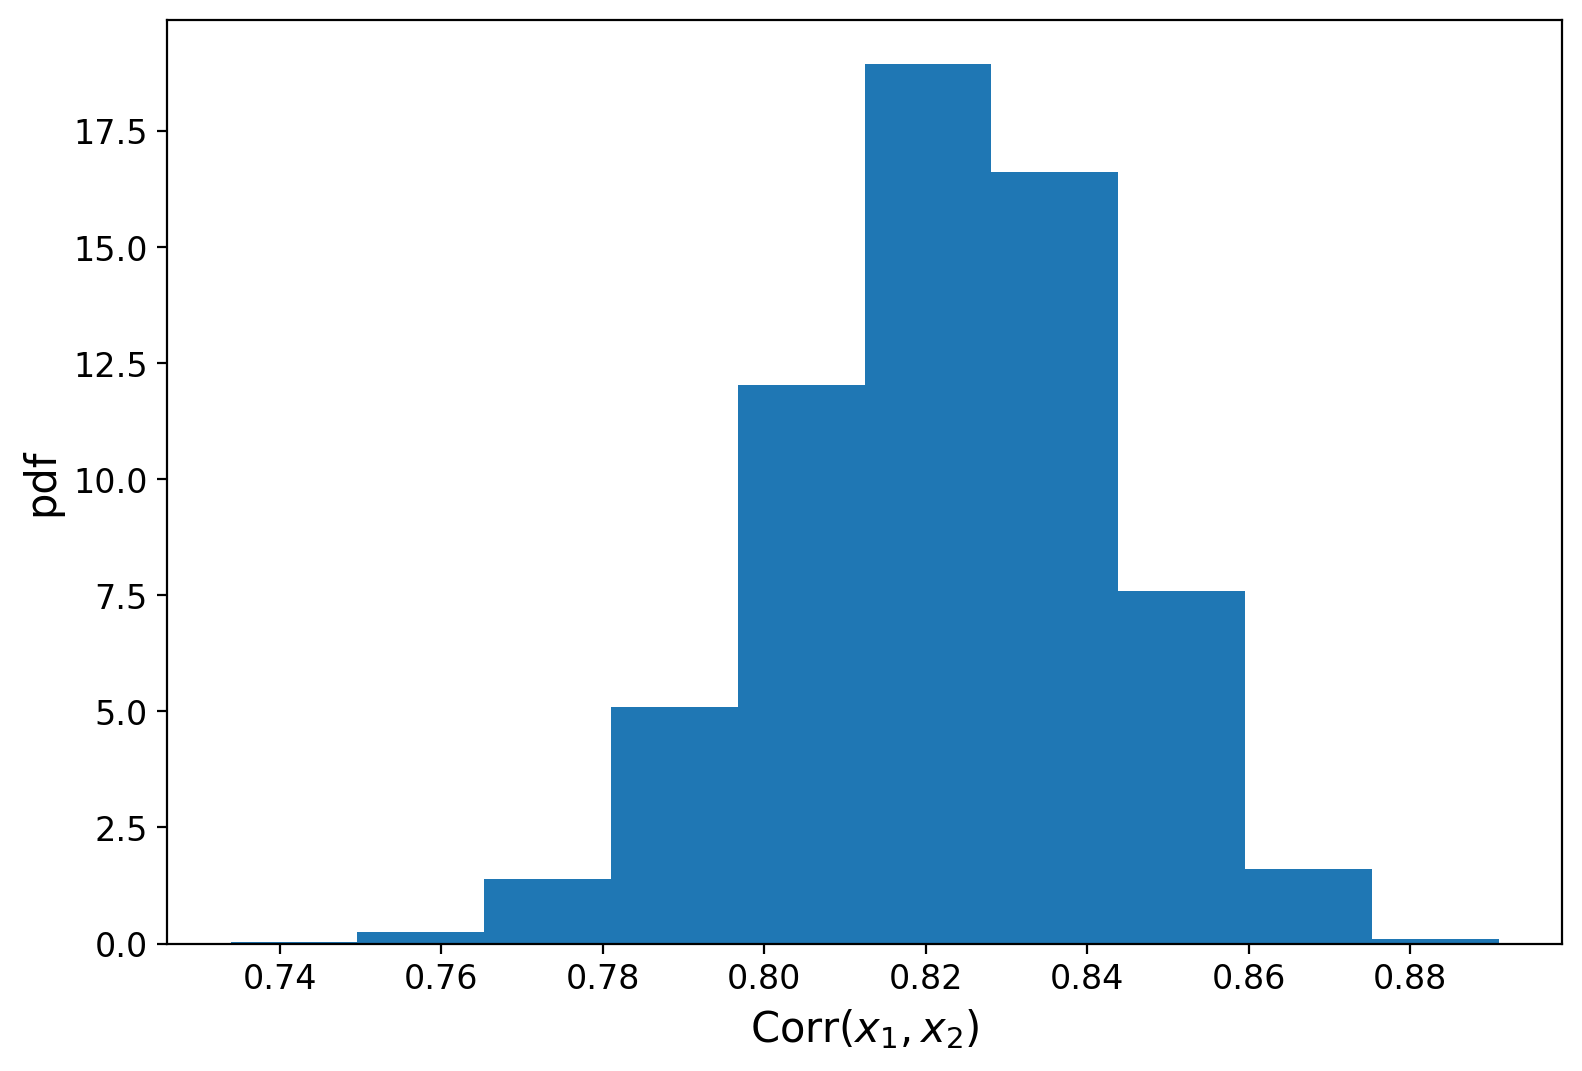

In [89]:
#>>>RUN: L21.5-runcell08

boot_sum   = []
boot_corr  = []
for _ in range(10000):
    #boot_sample = np.random.choice(out_data,replace = True, size = 500) # take a random sample each iteration
    boot_sample = out_data[np.random.choice(out_data.shape[0], 500, replace=True)]
    boot_sum.append(np.mean(boot_sample[:,0]+boot_sample[:,1]))
    boot_corr.append(np.corrcoef(boot_sample[:,0],boot_sample[:,1])[1,0])
boot_sum_np = np.array(boot_sum) # transform it into a numpy array for calculation
boot_corr_np = np.array(boot_corr)
print("Sum of Boot:",np.mean(boot_sum_np),"+/-",np.std(boot_sum_np),"-For Comparison sqrt(N) unc-",np.sqrt(np.mean(boot_sum_np)/500))
print("Corr of samples:",np.mean(boot_corr_np),"+/-",np.std(boot_corr_np))
print(boot_sum_np.shape)

plt.hist(boot_sum_np,density=True)
plt.xlabel("$x_{1}+x_{2}$")
plt.ylabel("pdf")
plt.show()

plt.hist(boot_corr_np,density=True)
plt.xlabel("Corr($x_{1},x_{2}$)")
plt.ylabel("pdf")
plt.show()

<a name='exercises_22_5'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_5) | [Next Section](#section_22_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.5.1</span>

Which of the following statements best describes the purpose of bootstrapping?

A) Bootstrapping is a technique for selecting a representative subset of the data to improve model training.\
B) Bootstrapping involves generating random datasets with subsets of the full input dataset in order to estimate the sampling distribution of a statistic.\
C) Bootstrapping is a method for normalizing the distribution of a dataset to ensure statistical validity.\
D) Bootstrapping is a process for identifying outliers in a dataset by iteratively removing extreme values.


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 21.5.2</span>

Let's test a different distribution and compare the uncertainties on the mean and standard deviation with a boostrapping approach. In the code below, we first sample 1000 data points from a Landau distribution, plot the histogram, and calculate the mean and standard deviation, just for show.

In the code that you must complete, repeat the direct sampling 50 times to estimate the overall mean and standard deviation, including their uncertainties. Then perform a 10,000-iteration bootstrap on the initial sample `vals` to estimate the mean and standard deviation with their uncertainties, and compare these results to those obtained from multiple sampling.

Report the mean and uncertainty from direct sampling and the mean and uncertainty with bootstrapping as a list `[mu1, mu1_unc, mu2, mu2_unc]` with the precision of one significant digit.

<br>

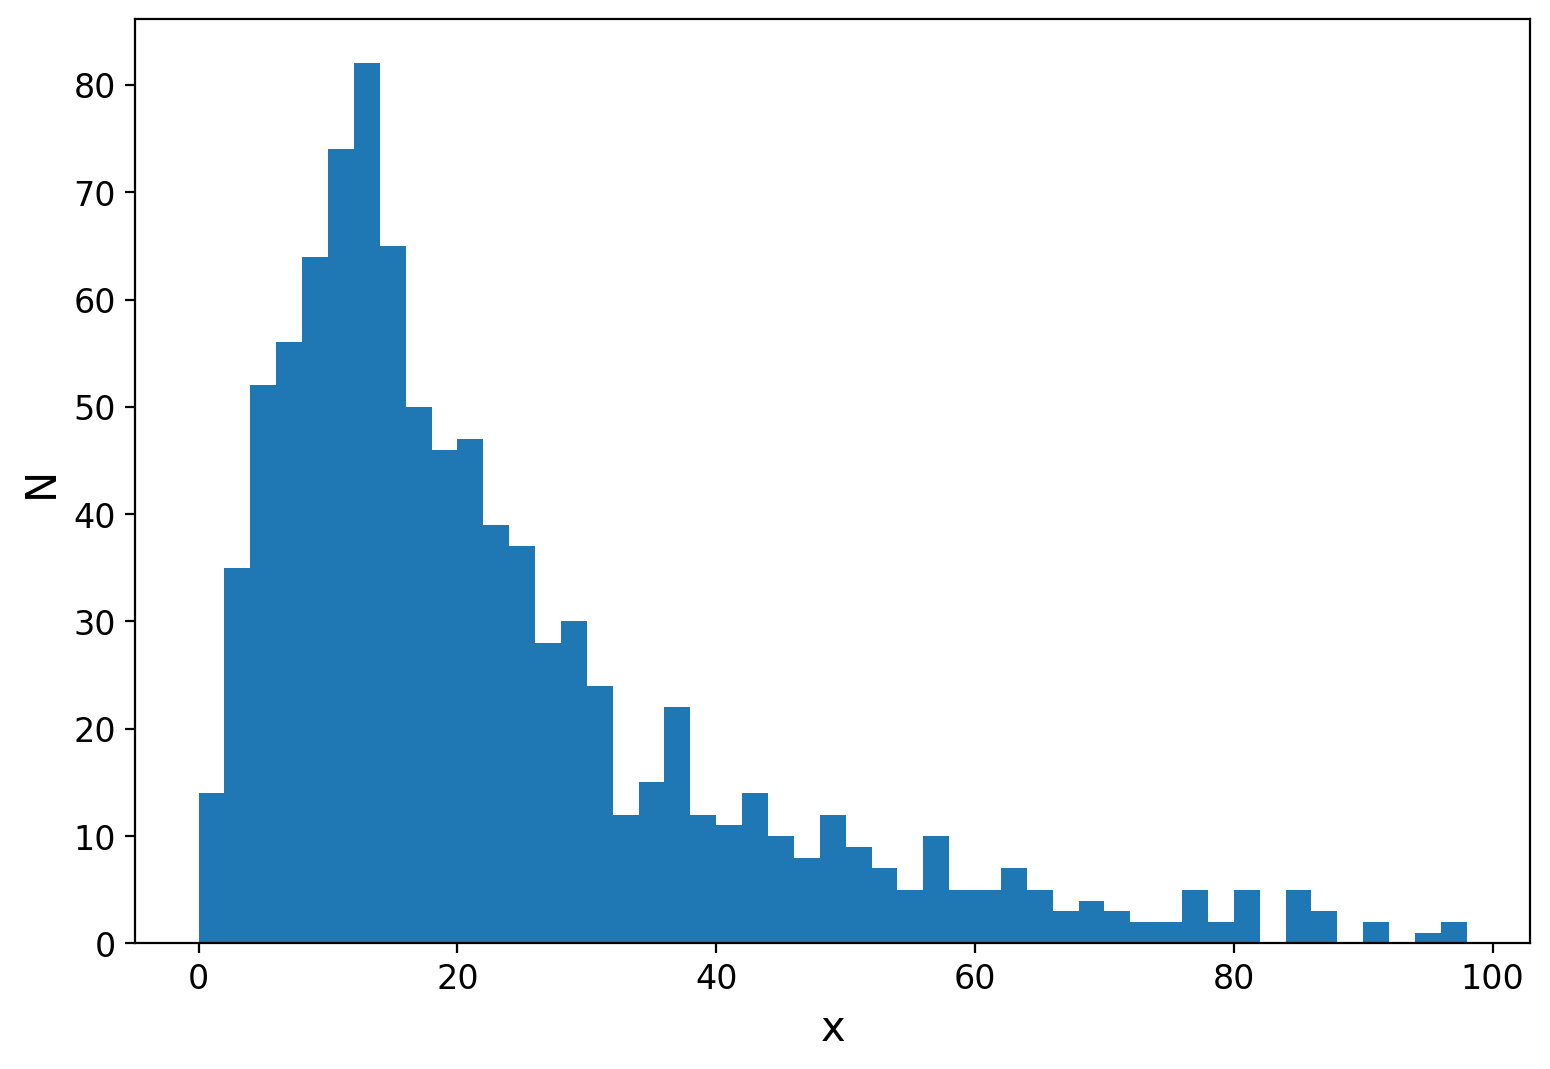

One Sample
Mean: 29.174590369339544  Std: 36.26873674943611

Multiple Samples
Mean from multiple samples: 28.738132878574365 +/- 1.3889693574998652
Std from multiple samples: 35.50621505922833 +/- 2.8698065436994935

Bootstrap
Bootstrap Mean: 29.17903654984627 +/- 1.1497807721929185
Bootstrap Std: 36.178534141925695 +/- 2.4588524928080493


In [90]:
#>>>EXERCISE: L21.5.2

from landaupy import landau

# Sample the Landau distribution once and plot
vals = landau.sample(10, 5, 1000)
plt.hist(vals, bins=np.arange(0, 100, 2))
plt.xlabel("x")
plt.ylabel("N")
plt.show()

# Calculate the mean and standard deviation
print("One Sample")
print("Mean:", np.mean(vals), " Std:", np.std(vals))
print("")

# Loop 50 times and compute the mean and uncertainty
# of the sample mean and sample std
samplemean = []
samplestd = []
for i in range(50):
    #sample 1000 pts from a Landau distribution for each run
    #append the lists with the mean and std from each run
    #YOUR CODE HERE
    tmpvals = landau. sample (10, 5, 1000)
    samplemean.append (np.mean (tmpvals))
    samplestd.append (np.std (tmpvals))


print("Multiple Samples")
print("Mean from multiple samples:", np.mean(samplemean), "+/-", np.std(samplemean))
print("Std from multiple samples:", np.mean(samplestd), "+/-", np.std(samplestd))
print("")


# Bootstrap to get the uncertainty on the mean and standard deviation
boot_means = []
boot_stds = []
for _ in range(10000):
  boot_sample = np. random. choice(vals, replace=True, size=1000) # Take a random sample each iteration
  boot_means.append (np.mean (boot_sample)) # Append the mean to boot_means
  boot_stds.append (np.std (boot_sample)) # Append the std to boot_std

print("Bootstrap")
print("Bootstrap Mean:", np.mean(boot_means), "+/-", np.std(boot_means))
print("Bootstrap Std:", np.mean(boot_stds), "+/-", np.std(boot_stds))




<a name='section_22_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.6 Bootstrapping For Neural Networks</h2>  

| [Top](#section_22_0) | [Previous Section](#section_22_5) |

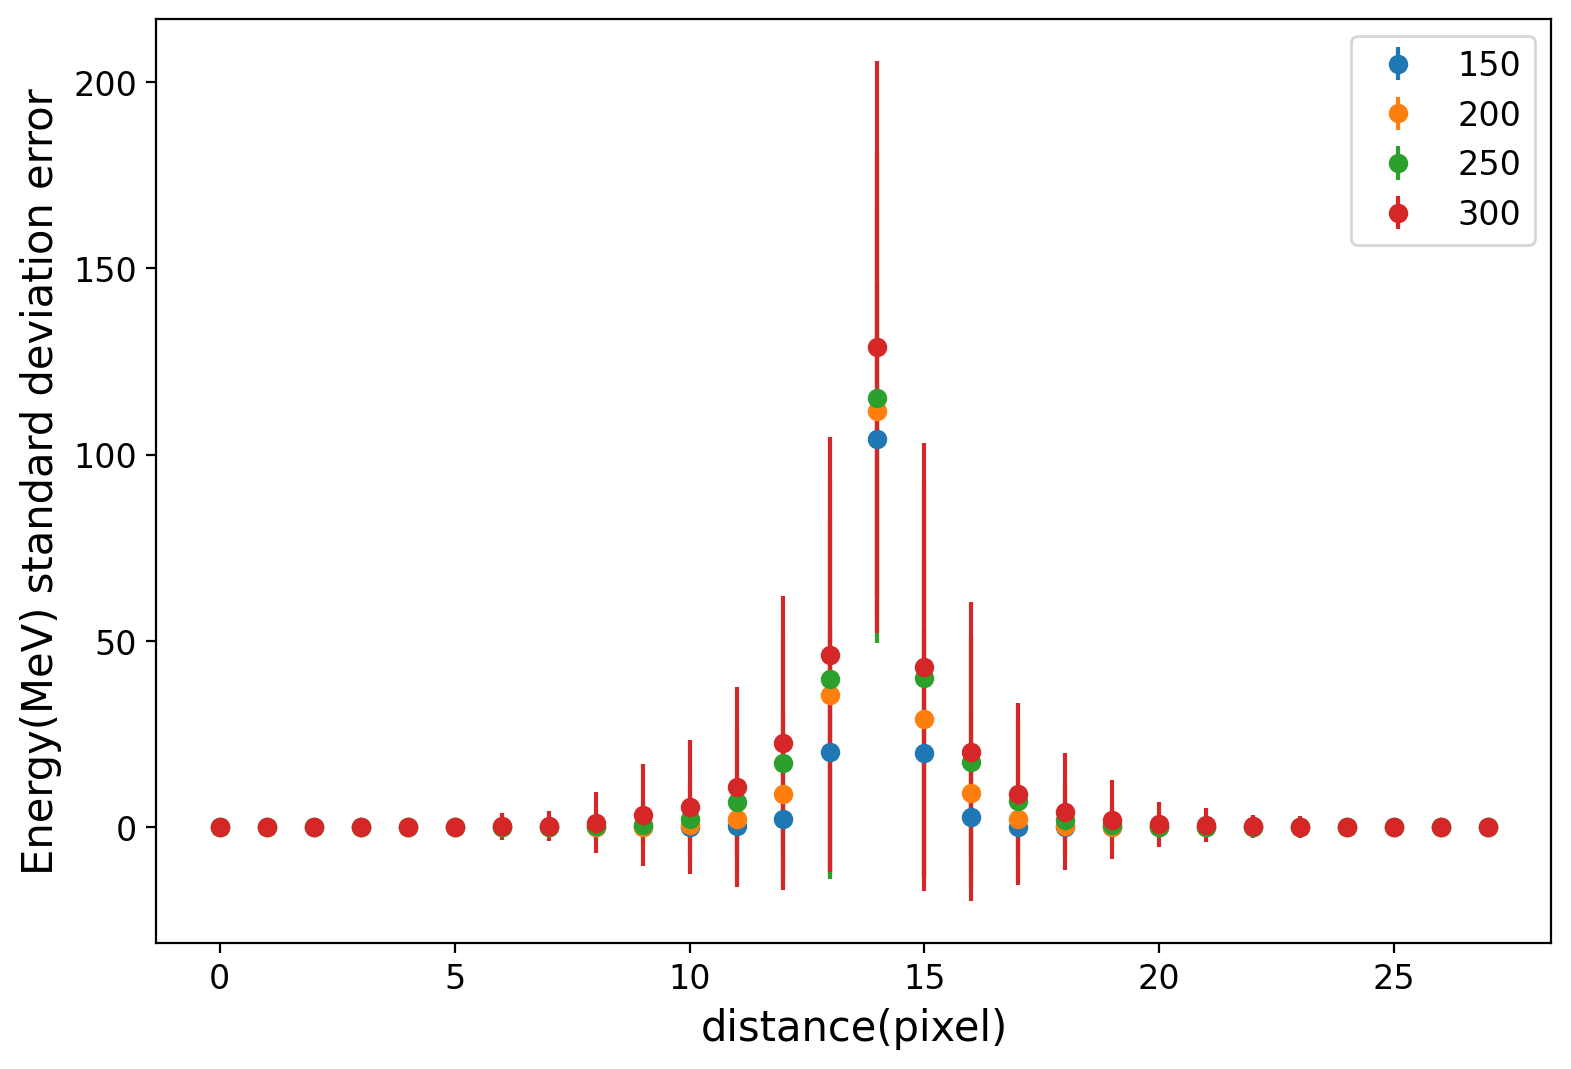

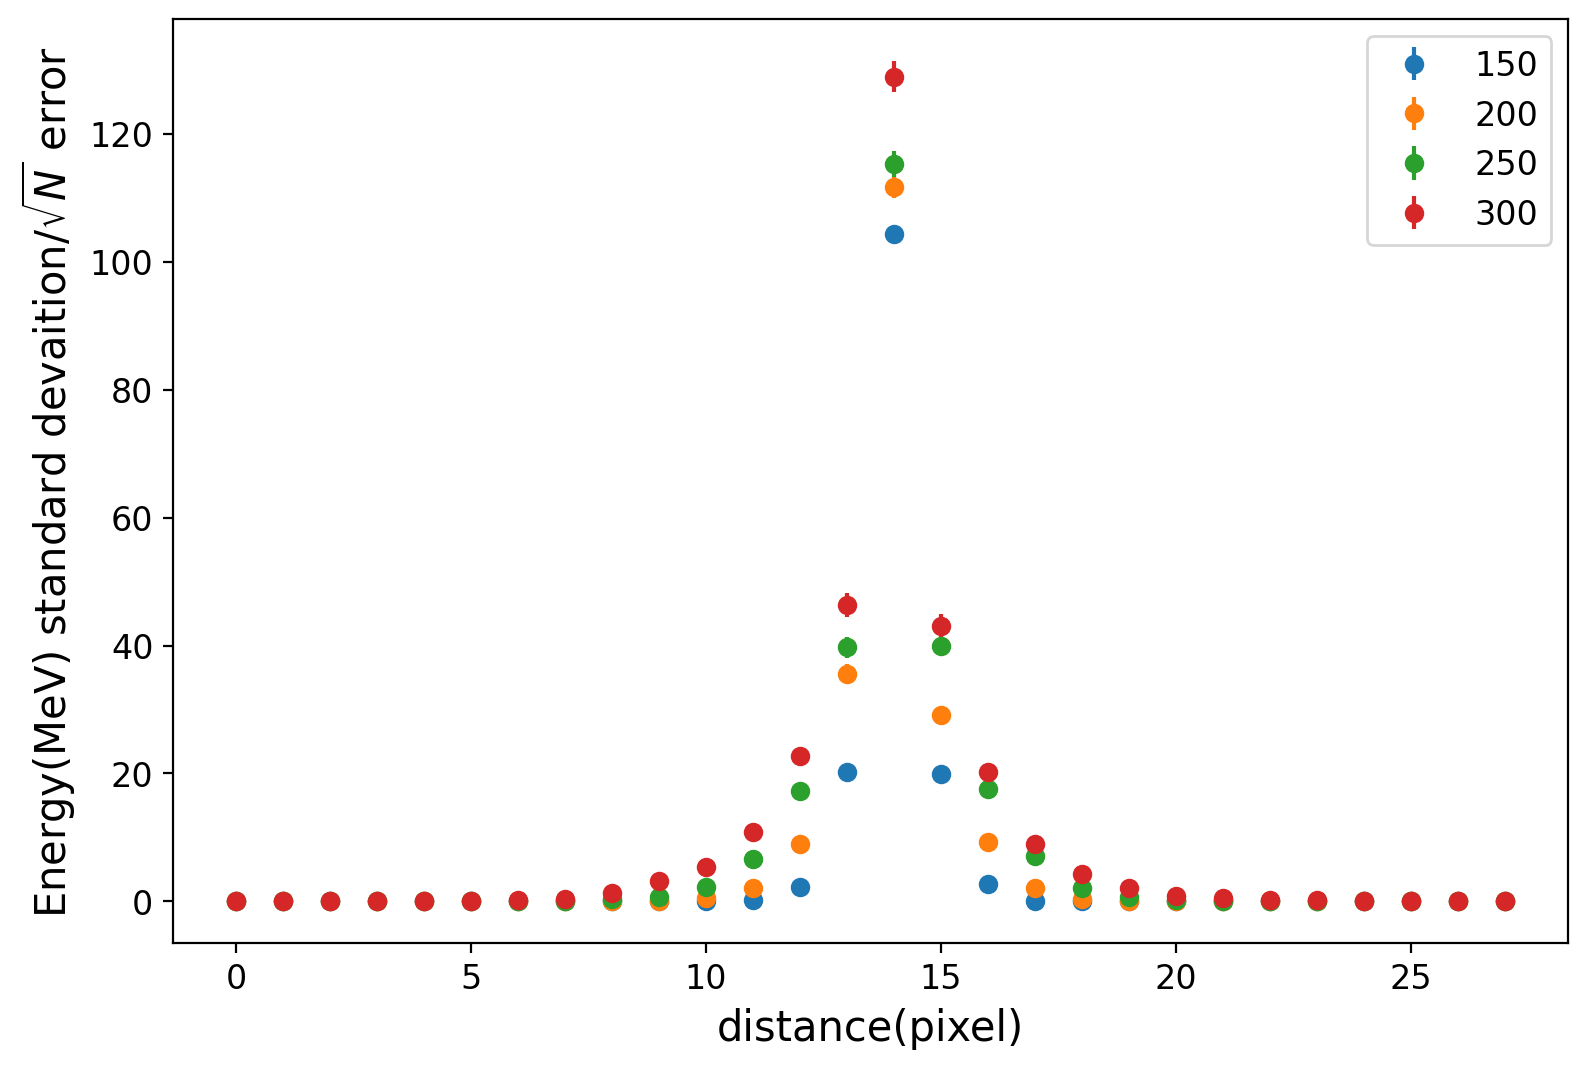

In [91]:
#>>>RUN: L21.6-runcell01

def makeDataet(iId,ixstep,iestep,iystep):
    print(ixstep.shape,iestep.shape,iystep.shape)
    outdata = np.hstack((ixstep,iystep,iestep))
    outdata = outdata.reshape(1000,3,ixstep.shape[1])
    return outdata

def profile(iInput):
    profile_out=np.sum(iInput,axis=3)
    return profile_out

out_profile150=profile(dimage150)
out_profile200=profile(dimage200)
out_profile250=profile(dimage250)
out_profile300=profile(dimage300)

test_150 = np.mean(out_profile150,axis=0)
test_200 = np.mean(out_profile200,axis=0)
test_250 = np.mean(out_profile250,axis=0)
test_300 = np.mean(out_profile300,axis=0)

test_150_std = np.std(out_profile150,axis=0)
test_200_std = np.std(out_profile200,axis=0)
test_250_std = np.std(out_profile250,axis=0)
test_300_std = np.std(out_profile300,axis=0)

test_150_stderr = np.std(out_profile150,axis=0)/np.sqrt(dimage150.shape[0])
test_200_stderr = np.std(out_profile200,axis=0)/np.sqrt(dimage200.shape[0])
test_250_stderr = np.std(out_profile250,axis=0)/np.sqrt(dimage250.shape[0])
test_300_stderr = np.std(out_profile300,axis=0)/np.sqrt(dimage300.shape[0])

plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_std,fmt='o',label='150')
plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_std,fmt='o',label='200')
plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_std,fmt='o',label='250')
plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_std,fmt='o',label='300')
plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV) standard deviation error')
plt.show()

plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_stderr,fmt='o',label='150')
plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_stderr,fmt='o',label='200')
plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_stderr,fmt='o',label='250')
plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_stderr,fmt='o',label='300')
plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV) standard devaition/$\sqrt{N}$ error')
plt.show()

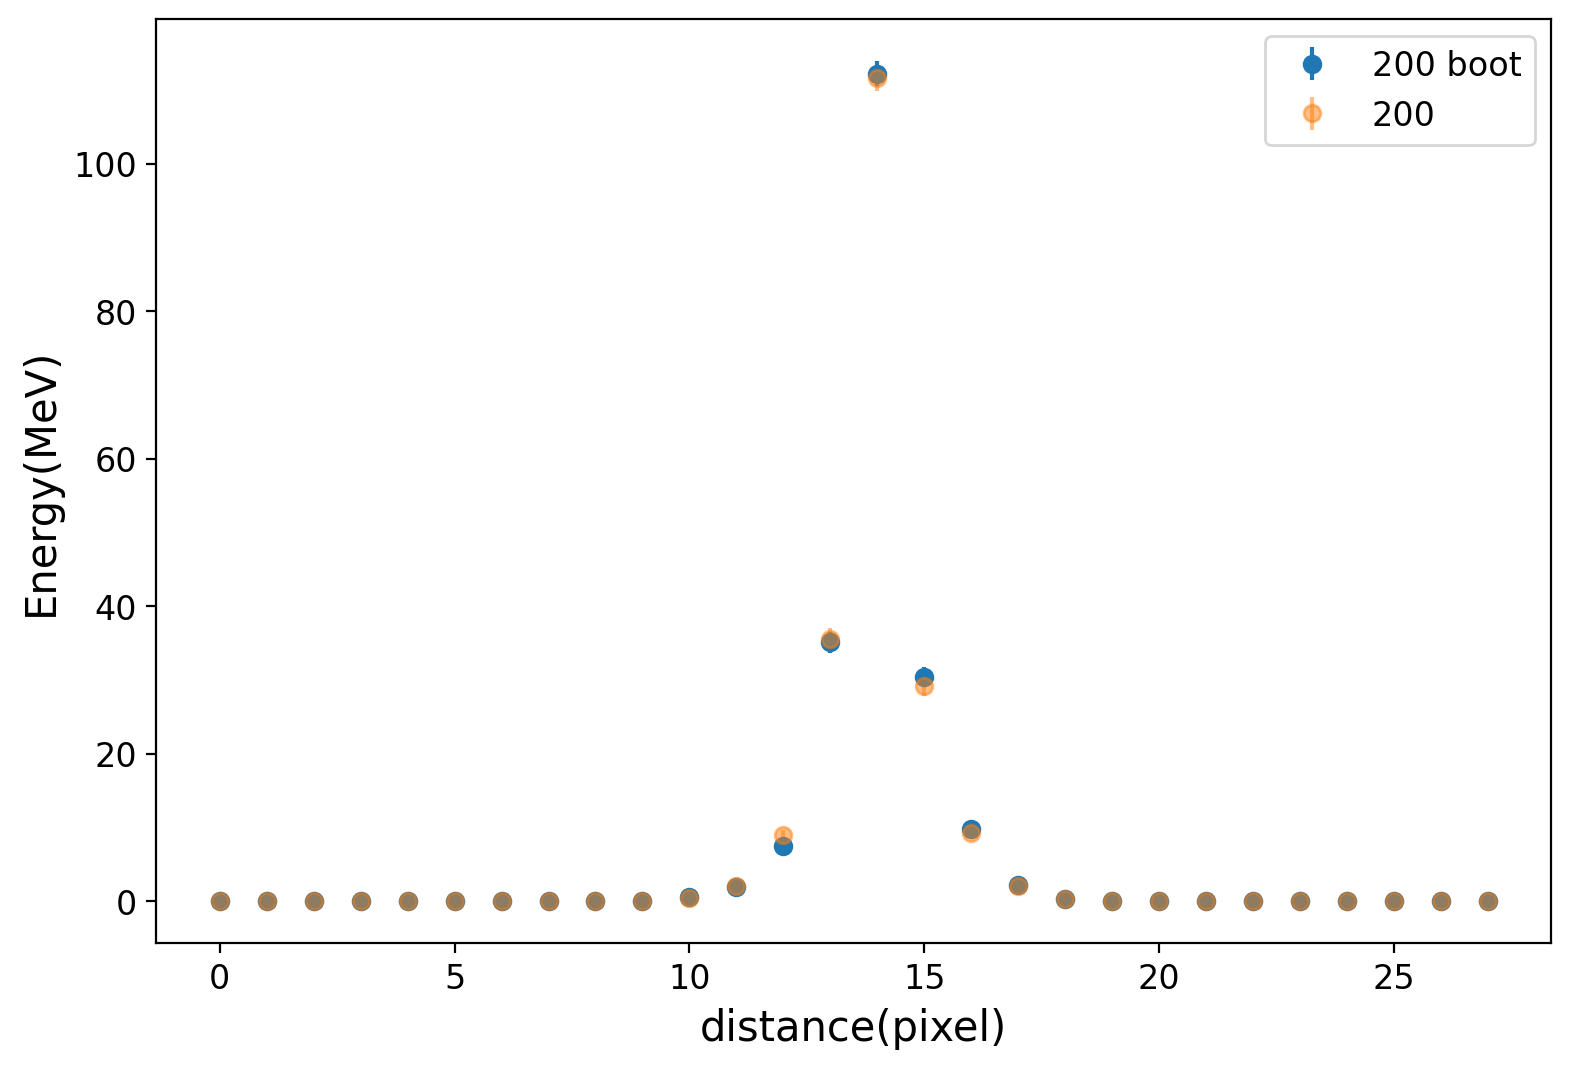

errors from boostrap: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.17511386e-18 2.99996731e-18 1.69552451e-01 3.22357019e-01
  6.21129327e-01 1.41713536e+00 1.68869586e+00 1.32389147e+00
  7.30523022e-01 3.32497817e-01 9.81601952e-02 3.11064594e-02
  1.65610884e-19 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
errors from sqrt(N): [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.32250831e-20
  1.54954062e-18 7.30685341e-02 1.56146215e-01 3.21281618e-01
  7.04855868e-01 1.48962828e+00 1.76552499e+00 1.35305719e+00
  7.36290065e-01 3.35369802e-01 1.11786054e-01 2.16447492e-02
  1.41954263e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [92]:
#>>>RUN: L21.6-runcell02

def profileVar(iData,iNSample):
    boot_profile = []
    for _ in range(iNSample):
        boot_sample = iData[np.random.choice(out_data.shape[0], 1000, replace=True)]
        boot_prof   = np.mean(profile(boot_sample),axis=0)
        boot_profile.append(boot_prof)
    boot_profile = np.array(boot_profile) # transform it into a numpy array for calculation
    return np.mean(boot_profile,axis=0),np.std(boot_profile,axis=0)

Nsamps=1000
dimage150_boot,dimage150_boot_err = profileVar(dimage150,Nsamps)
dimage200_boot,dimage200_boot_err = profileVar(dimage200,Nsamps)
dimage250_boot,dimage250_boot_err = profileVar(dimage250,Nsamps)
dimage300_boot,dimage300_boot_err = profileVar(dimage300,Nsamps)

#Uncomment to show all
#plt.errorbar(np.arange(28),dimage150_boot.flatten(),yerr=dimage150_boot_err,fmt='o',label='150 boot')
plt.errorbar(np.arange(28),dimage200_boot.flatten(),yerr=dimage200_boot_err,fmt='o',label='200 boot')
#plt.errorbar(np.arange(28),dimage250_boot.flatten(),yerr=dimage250_boot_err,fmt='o',label='250 boot')
#plt.errorbar(np.arange(28),dimage300_boot.flatten(),yerr=dimage300_boot_err,fmt='o',label='300 boot')

#Uncomment to show all
#plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_stderr,fmt='o',label='150',alpha=0.5)
plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_stderr,fmt='o',label='200',alpha=0.5)
#plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_stderr,fmt='o',label='250',alpha=0.5)
#plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_stderr,fmt='o',label='300',alpha=0.5)

plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()

print("errors from boostrap:",dimage200_boot_err)
print("errors from sqrt(N):",test_200_stderr)

3.1327993436996877 1.416624183764105


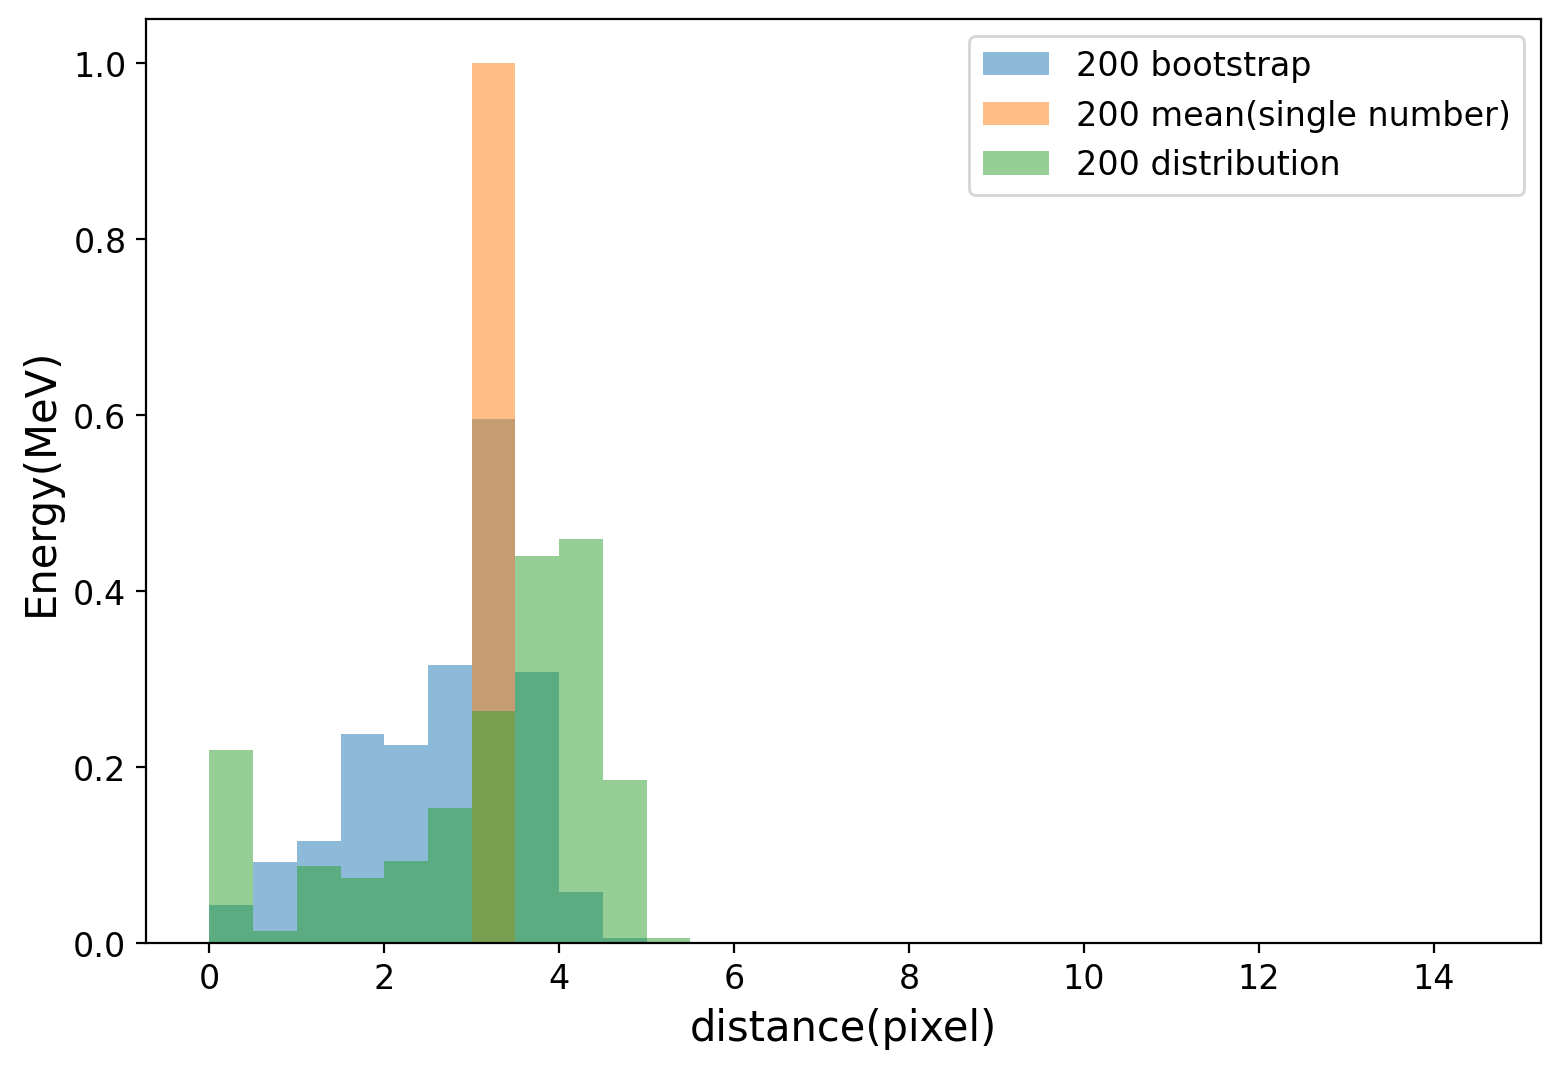

150  Val: 4.394145511405759 +/- 0.11026925979690629 boot 2.489576332752542 +/- 0.931147034279163
200  Val: 3.1327993436996877 +/- 0.04479759009171494 boot 2.686955103007691 +/- 0.9367475297502958
250  Val: 3.2598344159640726 +/- 0.09126868477651047 boot 2.550504849299536 +/- 0.7909712630900242
300  Val: 3.077474392987063 +/- 0.1394368045769643 boot 2.60440959178879 +/- 0.8071320002587393


In [93]:
#>>>RUN: L21.6-runcell03

#Compute our variable
def xmaxprofilecheck(iInput):
    profile_out=np.sum(iInput,axis=2)
    profile_out=np.reshape(profile_out,(iInput.shape[0],28))
    #maxbin=np.argmax(profile_out,axis=1)
    maxbin=np.unravel_index(np.argmax(profile_out, axis=1), profile_out.shape)
    Ein=np.sum(profile_out[:,0:2],axis=1)
    Eout=profile_out[maxbin]#+profile_out[:,maxbin+1]+profile_out[:,maxbin-1]
    ratio=Eout/Ein
    #print(Ein[0],Eout[0],Eout.shape)
    return ratio

#compute the mean and standard deviation
def xmaxprofile(iInput):
    ratio=xmaxprofilecheck(iInput)
    return np.mean(ratio),np.std(ratio)

#now bootstracp the profile and compute the meean and standar deviation
def xmaxprofileVar(iData,iNSample):
    boot_profile = []
    for _ in range(iNSample):
        boot_sample          = iData[np.random.choice(out_data.shape[0], 1000, replace=True)]
        boot_prof,boot_std   = xmaxprofile(boot_sample)
        boot_profile.append(boot_prof)
    boot_profile = np.array(boot_profile) # transform it into a numpy array for calculation
    #return np.mean(boot_profile,axis=0),np.std(boot_profile,axis=0)
    return boot_profile

xtest_150,xtest_150_std=xmaxprofile(dimage150)
xtest_200,xtest_200_std=xmaxprofile(dimage200)
xtest_250,xtest_250_std=xmaxprofile(dimage250)
xtest_300,xtest_300_std=xmaxprofile(dimage300)
print(xtest_200,xtest_200_std)

xtest_150_stderr = xtest_150_std/np.sqrt(dimage150.shape[0])
xtest_200_stderr = xtest_200_std/np.sqrt(dimage200.shape[0])
xtest_250_stderr = xtest_250_std/np.sqrt(dimage250.shape[0])
xtest_300_stderr = xtest_300_std/np.sqrt(dimage300.shape[0])

Nsamps=1000
dimage150_boot = xmaxprofileVar(dimage150,Nsamps)
dimage200_boot = xmaxprofileVar(dimage200,Nsamps)
dimage250_boot = xmaxprofileVar(dimage250,Nsamps)
dimage300_boot = xmaxprofileVar(dimage300,Nsamps)

#plt.hist(dimage150_boot.flatten(),density=True,label='150 boot',alpha=0.5)
plt.hist(dimage200_boot.flatten(),density=True,label='200 bootstrap',alpha=0.5,bins=np.arange(0,15,0.5))
#plt.hist(dimage250_boot.flatten(),density=True,label='250 boot',alpha=0.5,bins=np.arange(0,15,0.5))
#plt.hist(dimage300_boot.flatten(),density=True,label='300 boot',alpha=0.5,bins=np.arange(0,15,0.5))

#plt.hist(xtest_150.flatten(),label='150',alpha=0.5)
plt.hist(xtest_200.flatten(),label='200 mean(single number)',alpha=0.5,bins=np.arange(0,15,0.5))
#plt.hist(xtest_250.flatten(),label='250',alpha=0.5)
#plt.hist(xtest_300.flatten(),label='300',alpha=0.5)


xtest_200_check=xmaxprofilecheck(dimage200)
plt.hist(xtest_200_check.flatten(),density=True,label='200 distribution',alpha=0.5,bins=np.arange(0,15,0.5))

plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()

def printStats(ilabel,ival,ierr,iboot):
    print(ilabel,"Val:",ival,"+/-",ierr,"boot",np.mean(iboot),"+/-",np.std(iboot))

printStats("150 ",xtest_150,xtest_150_stderr,dimage150_boot)
printStats("200 ",xtest_200,xtest_200_stderr,dimage200_boot)
printStats("250 ",xtest_250,xtest_250_stderr,dimage250_boot)
printStats("300 ",xtest_300,xtest_300_stderr,dimage300_boot)

In [103]:
#>>>RUN: L21.6-runcell04

N=1000
dlimage150 = generate(d,N,cvae_proton_image,1.5)
dlimage200 = generate(d,N,cvae_proton_image,2.0)
dlimage250 = generate(d,N,cvae_proton_image,2.5)
dlimage300 = generate(d,N,cvae_proton_image,3.0)

Nsamps=1000
dlimage150_boot,dlimage150_boot_err = xmaxprofileVar(dlimage150,Nsamps)
dlimage200_boot,dlimage200_boot_err = xmaxprofileVar(dlimage200,Nsamps)
dlimage250_boot,dlimage250_boot_err = xmaxprofileVar(dlimage250,Nsamps)
dlimage300_boot,dlimage300_boot_err = xmaxprofileVar(dlimage300,Nsamps)

print("err:",dlimage150_boot_err)

#plt.errorbar(np.arange(28),dlimage150_boot.flatten(),yerr=dlimage150_boot_err,fmt='o',label='150')
#plt.errorbar(np.arange(28),dlimage200_boot.flatten(),yerr=dlimage200_boot_err,fmt='o',label='200')
#plt.errorbar(np.arange(28),dlimage250_boot.flatten(),yerr=dlimage250_boot_err,fmt='o',label='250')
#plt.errorbar(np.arange(28),dlimage300_boot.flatten(),yerr=dlimage300_boot_err,fmt='o',label='300')

#plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_stderr,fmt='o',label='150',alpha=0.5)
#plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_stderr,fmt='o',label='200',alpha=0.5)
#plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_stderr,fmt='o',label='250',alpha=0.5)
#plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_stderr,fmt='o',label='300',alpha=0.5)

plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()


ValueError: too many values to unpack (expected 2)

In [96]:
#>>>RUN: L21.6-runcell05

N=1000
dlimage150 = generate_base(4,N,proton_vae_image)
dlimage200 = generate(d,N,cvae_proton_image,2.0)
#dlimage250 = generate(d,N,cvae_proton_image,2.5)
#dlimage300 = generate(d,N,cvae_proton_image,3.0)

Nsamps=1000
xdlimage150_boot = xmaxprofileVar(dlimage150,Nsamps)
xdlimage200_boot = xmaxprofileVar(dlimage200,Nsamps)
#xdlimage250_boot = xmaxprofileVar(dlimage250,Nsamps)
#xdlimage300_boot = xmaxprofileVar(dlimage300,Nsamps)

print("err:",dlimage150_boot_err)

#plt.hist(xdlimage150_boot.flatten(),density=True,label='150 NN',alpha=0.5)
#plt.hist(dimage150_boot.flatten(),density=True,label='150 MC',alpha=0.5)

plt.hist(xdlimage200_boot.flatten(),density=True,label='200 NN',alpha=0.5)
plt.hist(dimage200_boot.flatten(),density=True,label='200 MC',alpha=0.5)

#plt.hist(xdlimage200_boot.flatten(),density=True,label='200',alpha=0.5)
#plt.hist(xdlimage250_boot.flatten(),density=True,label='250',alpha=0.5)
#plt.hist(xdlimage300_boot.flatten(),density=True,label='300',alpha=0.5)

plt.hist(xtest_150.flatten(),label='150-avg',alpha=0.5)
plt.hist(xtest_200.flatten(),label='200',alpha=0.5)
plt.hist(xtest_250.flatten(),label='250',alpha=0.5)
plt.hist(xtest_300.flatten(),label='300',alpha=0.5)

plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()


NameError: name 'generate_base' is not defined